# Capstone #4 - FMA: Unsupervised Music Clustering and Analysis

## Introduction:
For this capstone, I analyzed a [dataset](https://os.unil.cloud.switch.ch/fma/fma_metadata.zip) from the [Free Music Archive (FMA)](https://arxiv.org/abs/1612.01840), which contains several features of metadata for each item in a collection of more than 100,000 tracks of music. Within the compressed folder of musical data, four CSV files contain information related to tracks, genres, Librosa features, and Echonest features, respectively. 

Before any cleaning, the tracks dataset originally contained over 100,000 tracks and 53 features for each track, and the Echonest dataset contained over 13,000 tracks and 26 features for each track. In the Supervised Learning Capstone I elected to use the 100,000 track portion of the dataset, but in this Unsupervised Learning analysis, I instead combined the tracks and Echonest datasets, thereby providing a total dataset with over 10,000 tracks and 79 features per track.

With the goal of the tracks into clearly delineated groups, this project was divided into the following steps:
 - Import of libraries
 - Reading of initial track data
 - Reading of initial Echonest data
 - Combining of the datasets
 - Dataset cleaning
 - Feature engineering and selection
 - Feature analysis and visualization
 - Dataset visualization
 - Feature reduction via PCA, t-SNE, and UMAP
     - Unsupervised clustering via KMeans, MiniBatch KMeans, Dendograms, Agglomerative Clustering, and Gaussian Mixture Modeling
 - Comparison of silhouette scores adjusted rand index for each model
 - Definitions of most accurate clustering features

## Import Libraries

In [1]:
# Import libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import math
import time
import warnings
warnings.filterwarnings('ignore')

## Load Music Dataset

In [2]:
#Import dataset
music = pd.read_csv('C:/Users/Amichai/Documents/Thinkful/Capstone 4 - Unsupervised ML/fma_metadata/tracks.csv')
headers = [str(y) + '_' + str(z) for y,z in zip([x[0] for x in list(music.columns.str.split('.'))],list(music.iloc[0]))]
music.columns = headers

#Drop old column rows
music = music.drop([0,1])

music.head()

Unnamed: 0_nan album_comments   album_date_created  album_date_released  \
2              2              0  2008-11-26 01:44:45  2009-01-05 00:00:00   
3              3              0  2008-11-26 01:44:45  2009-01-05 00:00:00   
4              5              0  2008-11-26 01:44:45  2009-01-05 00:00:00   
5             10              0  2008-11-26 01:45:08  2008-02-06 00:00:00   
6             20              0  2008-11-26 01:45:05  2009-01-06 00:00:00   

  album_engineer album_favorites album_id  \
2            NaN               4        1   
3            NaN               4        1   
4            NaN               4        1   
5            NaN               4        6   
6            NaN               2        4   

                           album_information album_listens album_producer  \
2                                    <p></p>          6073            NaN   
3                                    <p></p>          6073            NaN   
4                                    <p></p>          6073            NaN   
5                                        NaN         47632            NaN   
6  <p> "spiritual songs" from Nicky Cook</p>          2710            NaN   

   ... track_information track_interest track_language_code  \
2  ...               NaN           4656                  en   
3  ...               NaN           1470                  en   
4  ...               NaN           1933                  en   
5  ...               NaN          54881                  en   
6  ...               NaN            978                  en   

                                       track_license track_listens  \
2  Attribution-NonCommercial-ShareAlike 3.0 Inter...          1293   
3  Attribution-NonCommercial-ShareAlike 3.0 Inter...           514   
4  Attribution-NonCommercial-ShareAlike 3.0 Inter...          1151   
5  Attribution-NonCommercial-NoDerivatives (aka M...         50135   
6  Attribution-NonCommercial-NoDerivatives (aka M...           361   

  track_lyricist track_number track_publisher track_tags      track_title  
2            NaN            3             NaN         []             Food  
3            NaN            4             NaN         []     Electric Ave  
4            NaN            6             NaN         []       This World  
5            NaN            1             NaN         []          Freeway  
6            NaN            3             NaN         []  Spiritual Level  

[5 rows x 53 columns]

In [3]:
music.columns

Index(['Unnamed: 0_nan', 'album_comments', 'album_date_created',
       'album_date_released', 'album_engineer', 'album_favorites', 'album_id',
       'album_information', 'album_listens', 'album_producer', 'album_tags',
       'album_title', 'album_tracks', 'album_type', 'artist_active_year_begin',
       'artist_active_year_end', 'artist_associated_labels', 'artist_bio',
       'artist_comments', 'artist_date_created', 'artist_favorites',
       'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_members', 'artist_name', 'artist_related_projects',
       'artist_tags', 'artist_website', 'artist_wikipedia_page', 'set_split',
       'set_subset', 'track_bit_rate', 'track_comments', 'track_composer',
       'track_date_created', 'track_date_recorded', 'track_duration',
       'track_favorites', 'track_genre_top', 'track_genres',
       'track_genres_all', 'track_information', 'track_interest',
       'track_language_code', 'track_license', 'track_listen

In [4]:
music.shape

(106574, 53)

The initial music dataset contained 106,574 tracks and 53 features per track.

In [5]:
genre = pd.read_csv('C:/Users/Amichai/Documents/Thinkful/Capstone 4 - Unsupervised ML/fma_metadata/genres.csv', header = 0)
print("# Unique Genres: ", len(genre['title']))
genre.sort_values('#tracks', ascending=False)[:25]

# Unique Genres:  163


genre_id  #tracks  parent               title  top_level
31         38    38154       0        Experimental         38
14         15    34413       0          Electronic         15
11         12    32923       0                Rock         12
162      1235    14938       0        Instrumental       1235
9          10    13845       0                 Pop         10
16         17    12706       0                Folk         17
22         25     9261      12                Punk         12
0           1     8693      38         Avant-Garde         38
20         21     8389       0             Hip-Hop         21
27         32     7268      38               Noise         38
66        107     7206    1235             Ambient       1235
48         76     7144      10    Experimental Pop         10
32         41     6110      38     Electroacoustic         38
24         27     6041      12               Lo-Fi         12
17         18     5913    1235          Soundtrack       1235
33         42     5723      15  Ambient Electronic         15
44         66     5432      12          Indie-Rock         12
1           2     5271       0       International          2
105       250     4261      38              Improv         38
65        103     4162      17   Singer-Songwriter         17
3           4     4126       0                Jazz          4
4           5     4106       0           Classical          5
53         85     3548      12              Garage         12
102       236     3472      15                 IDM         15
25         30     3237      38    Field Recordings         38

In [6]:
#Parent/ top-level genres:
print([genre['title'][genre['genre_id']==x] for x in list(np.unique(genre['top_level']))])

[1    International
Name: title, dtype: object, 2    Blues
Name: title, dtype: object, 3    Jazz
Name: title, dtype: object, 4    Classical
Name: title, dtype: object, 7    Old-Time / Historic
Name: title, dtype: object, 8    Country
Name: title, dtype: object, 9    Pop
Name: title, dtype: object, 11    Rock
Name: title, dtype: object, 12    Easy Listening
Name: title, dtype: object, 13    Soul-RnB
Name: title, dtype: object, 14    Electronic
Name: title, dtype: object, 16    Folk
Name: title, dtype: object, 19    Spoken
Name: title, dtype: object, 20    Hip-Hop
Name: title, dtype: object, 31    Experimental
Name: title, dtype: object, 162    Instrumental
Name: title, dtype: object]


### Echonest Data

In [7]:
echo = pd.read_csv('C:/Users/Amichai/Documents/Thinkful/Capstone 4 - Unsupervised ML/fma_metadata/echonest.csv')
headers = [str(y) + '_' + str(z) for y,z in zip(list(echo.iloc[0]), list(echo.iloc[1]))]
echo.columns = headers

#Drop old column rows
echo = echo.drop([0,1,2])
echo=echo.reset_index(drop=True)

#Drop temporal columns
drop_list = [x for x in list(echo.columns) if x.split('_')[0] == 'temporal' ]
echo = echo.drop(drop_list, axis=1)

echo.shape

(13129, 26)

In [8]:
echo.head()

nan_nan audio_features_acousticness audio_features_danceability  \
0       2                0.4166752327                0.6758939853   
1       3                0.3744077685                0.5286430621   
2       5                0.0435668989                0.7455658702   
3      10                0.9516699648                0.6581786543   
4     134                0.4522173071                0.5132380502   

  audio_features_energy audio_features_instrumentalness  \
0          0.6344762684                    0.0106280683   
1          0.8174611317                    0.0018511032   
2          0.7014699916                    0.0006967990   
3          0.9245251615                    0.9654270154   
4          0.5604099311                    0.0194426943   

  audio_features_liveness audio_features_speechiness audio_features_tempo  \
0            0.1776465712               0.1593100648       165.9220000000   
1            0.1058799438               0.4618181276       126.9570000000   
2            0.3731433124               0.1245953419       100.2600000000   
3            0.1154738842               0.0329852191       111.5620000000   
4            0.0965666940               0.5255193792       114.2900000000   

  audio_features_valence metadata_album_date  ... ranks_artist_discovery_rank  \
0           0.5766609880                 NaN  ...                         NaN   
1           0.2692402421                 NaN  ...                         NaN   
2           0.6216612236                 NaN  ...                         NaN   
3           0.9635898919          2008-03-11  ...             2635.0000000000   
4           0.8940722715                 NaN  ...                         NaN   

  ranks_artist_familiarity_rank ranks_artist_hotttnesss_rank  \
0                           NaN                          NaN   
1                           NaN                          NaN   
2                           NaN                          NaN   
3               2544.0000000000               397.0000000000   
4                           NaN                          NaN   

  ranks_song_currency_rank ranks_song_hotttnesss_rank  \
0                      NaN                        NaN   
1                      NaN                        NaN   
2                      NaN                        NaN   
3        115691.0000000000           67609.0000000000   
4                      NaN                        NaN   

  social_features_artist_discovery social_features_artist_familiarity  \
0                     0.3889898648                       0.3867400000   
1                     0.3889898648                       0.3867400000   
2                     0.3889898648                       0.3867400000   
3                     0.5573390067                       0.6142720000   
4                     0.3889898648                       0.3867400000   

  social_features_artist_hotttnesss social_features_song_currency  \
0                      0.4063700000                  0.0000000000   
1                      0.4063700000                  0.0000000000   
2                      0.4063700000                  0.0000000000   
3                      0.7983870000                  0.0051579926   
4                      0.4063700000                  0.0000000000   

  social_features_song_hotttnesss  
0                    0.0000000000  
1                    0.0000000000  
2                    0.0000000000  
3                    0.3545160000  
4                    0.0000000000  

[5 rows x 26 columns]

In [9]:
echo.columns

Index(['nan_nan', 'audio_features_acousticness', 'audio_features_danceability',
       'audio_features_energy', 'audio_features_instrumentalness',
       'audio_features_liveness', 'audio_features_speechiness',
       'audio_features_tempo', 'audio_features_valence', 'metadata_album_date',
       'metadata_album_name', 'metadata_artist_latitude',
       'metadata_artist_location', 'metadata_artist_longitude',
       'metadata_artist_name', 'metadata_release',
       'ranks_artist_discovery_rank', 'ranks_artist_familiarity_rank',
       'ranks_artist_hotttnesss_rank', 'ranks_song_currency_rank',
       'ranks_song_hotttnesss_rank', 'social_features_artist_discovery',
       'social_features_artist_familiarity',
       'social_features_artist_hotttnesss', 'social_features_song_currency',
       'social_features_song_hotttnesss'],
      dtype='object')

As mentioned in the introduction, I have chosen to combine the tracks and Echonest datasets. Although that removes over 90% of the rows of the dataset, it increases the number of initial features by 26, which I felt was a worthwhile trade-off in terms of an Unsupervised clustering project like this one.

### Dataset Merging and Cleaning

#### Combine the datasets by `track_id`

In [10]:
music = music.rename(columns={'Unnamed: 0_nan': 'track_id'})
echo = echo.rename(columns={'nan_nan': 'track_id'})

merged_df = music.merge(echo, how = 'inner', on = ['track_id'])
print(merged_df.shape)
merged_df.head()

(10892, 78)


track_id album_comments   album_date_created  album_date_released  \
0        2              0  2008-11-26 01:44:45  2009-01-05 00:00:00   
1        3              0  2008-11-26 01:44:45  2009-01-05 00:00:00   
2        5              0  2008-11-26 01:44:45  2009-01-05 00:00:00   
3       10              0  2008-11-26 01:45:08  2008-02-06 00:00:00   
4      134              0  2008-11-26 01:44:45  2009-01-05 00:00:00   

  album_engineer album_favorites album_id album_information album_listens  \
0            NaN               4        1           <p></p>          6073   
1            NaN               4        1           <p></p>          6073   
2            NaN               4        1           <p></p>          6073   
3            NaN               4        6               NaN         47632   
4            NaN               4        1           <p></p>          6073   

  album_producer  ... ranks_artist_discovery_rank  \
0            NaN  ...                         NaN   
1            NaN  ...                         NaN   
2            NaN  ...                         NaN   
3            NaN  ...             2635.0000000000   
4            NaN  ...                         NaN   

  ranks_artist_familiarity_rank ranks_artist_hotttnesss_rank  \
0                           NaN                          NaN   
1                           NaN                          NaN   
2                           NaN                          NaN   
3               2544.0000000000               397.0000000000   
4                           NaN                          NaN   

  ranks_song_currency_rank ranks_song_hotttnesss_rank  \
0                      NaN                        NaN   
1                      NaN                        NaN   
2                      NaN                        NaN   
3        115691.0000000000           67609.0000000000   
4                      NaN                        NaN   

  social_features_artist_discovery social_features_artist_familiarity  \
0                     0.3889898648                       0.3867400000   
1                     0.3889898648                       0.3867400000   
2                     0.3889898648                       0.3867400000   
3                     0.5573390067                       0.6142720000   
4                     0.3889898648                       0.3867400000   

  social_features_artist_hotttnesss social_features_song_currency  \
0                      0.4063700000                  0.0000000000   
1                      0.4063700000                  0.0000000000   
2                      0.4063700000                  0.0000000000   
3                      0.7983870000                  0.0051579926   
4                      0.4063700000                  0.0000000000   

  social_features_song_hotttnesss  
0                    0.0000000000  
1                    0.0000000000  
2                    0.0000000000  
3                    0.3545160000  
4                    0.0000000000  

[5 rows x 78 columns]

#### Clean `artist_name` and `merged_artist_name` and compare

In [11]:
merged_df['artist_name'] = [item.rstrip().upper().replace('&', 'AND').replace(' ANDAMP; ', ' AND ').replace('  ', ' ').replace('U.S.', 'UNITED STATES').replace('.','').replace('*','').replace('!','').replace(' + ', ' AND ').replace(' W/ ', ' WITH ').replace('FEAT ', 'FEATURING ').replace('-', ' ').replace('Ä', 'A').replace('Ö', 'O').replace('Ê', 'E').replace('É', 'E').replace('È', 'E').replace('THE ', '') if item.split()[0] == 'The' 
                            else item.rstrip().upper().replace('&', 'AND').replace(' ANDAMP; ', ' AND ').replace('  ', ' ').replace('U.S.', 'UNITED STATES').replace('.','').replace('*','').replace('!','').replace(' + ', ' AND ').replace(' W/ ', ' WITH ').replace('FEAT ', 'FEATURING ').replace('-', ' ').replace('Ä', 'A').replace('Ö', 'O').replace('Ê', 'E').replace('É', 'E').replace('È', 'E') for item in merged_df['artist_name']]

merged_df['metadata_artist_name'] = [item.rstrip().upper().replace('&', 'AND').replace(' ANDAMP; ', ' AND ').replace('  ', ' ').replace('U.S.', 'UNITED STATES').replace('.','').replace('*','').replace('!','').replace(' + ', ' AND ').replace(' W/ ', ' WITH ').replace('FEAT ', 'FEATURING ').replace('-', ' ').replace('Ä', 'A').replace('Ö', 'O').replace('Ê', 'E').replace('É', 'E').replace('È', 'E').replace('THE ', '') if item.split()[0] == 'The' 
                                     else item.rstrip().upper().replace('&', 'AND').replace(' ANDAMP; ', ' AND ').replace('  ', ' ').replace('U.S.', 'UNITED STATES').replace('.','').replace('*','').replace('!','').replace(' + ', ' AND ').replace(' W/ ', ' WITH ').replace('FEAT ', 'FEATURING ').replace('-', ' ').replace('Ä', 'A').replace('Ö', 'O').replace('Ê', 'E').replace('É', 'E').replace('È', 'E') for item in merged_df['metadata_artist_name']]

By replacing common abbreviations and symbols, removing excess whitespace, and converting all letters to uppercase, in addition to comparing the strings using a SequenceMatcher function, we can determine whether the artist names match between the merged dataframes. Finally, we can drop the tracks in which the artist names don't match, just to make sure that the dataframes were merged properly.

In [12]:
#Use Python's SequenceMatcher to fix slight misspellings in artist_name
#Ratio determines how similar the strings have to be
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

for naming in ['artist_name', 'metadata_artist_name']:
    unique_names = sorted(list(np.unique(merged_df[naming])), key=len)[::-1]  #names sorted by string length

    for i in range(len(unique_names)):
        print(unique_names[i])
        for j in range(i+1, len(unique_names)):
            if similar(unique_names[i], unique_names[j])>0.90:   #If the names have >90% similarity
                old_ind = np.where(merged_df[naming].str.contains(unique_names[j]))
                if i !=j:
                    print(unique_names[j])
                    merged_df[naming][old_ind[0]] = unique_names[j]
        print('________________________________')

    print(len(np.unique(merged_df[naming]))) 
    print('\n\n\n')

RANDALL SCARLATA, BARITONE/JENNIFER AYLMER, SOPRANO/LAURA WARD, PIANO
________________________________
LIEUT JIM EUROPE'S 369TH UNITED STATES INFANTRY HELL FIGHTERS BAND
________________________________
ALIENAQTOR, DISORDER OF RAGE (DXOXRX), FLANICX, AND ROD BRANDAO
________________________________
REV MADISON CLINTON PETERS AND THE EDISON MIXED QUARTET
________________________________
MUSICIANS FROM THE RAVINIA FESTIVAL STEAN'S INSTITUTE
________________________________
UNITED STATES ARMY OLD GUARD FIFE AND DRUM CORPS
________________________________
SNOWY O MCSNOWERSON AND THE OH SO SNOWLY SNOWERS
________________________________
COREY CEROVSEK, VIOLIN; PAAVALI JUMPPANEN, PIANO
________________________________
NEW YORK MILITARY BAND AND THE AMERICAN QUARTET
________________________________
THOMAS DIMUZIO/SCOTT ARFORD/CHRIS FITZPATRICK
________________________________
CHAPI CHAPO AND LES PETITES MUSIQUES DE PLUIE
________________________________
MIRIAM FRIED, VIOLIN; JONATHAN BISS, PI

________________________________
MICOLAND AND HOLLY BRETTON
________________________________
LORELLE MEETS THE OBSOLETE
________________________________
LEON SOMOV FEATURING JAZZU
________________________________
JEFFREY LEWIS AND THE RAIN
________________________________
JAD FAIR AND JASON WILLETT
________________________________
DECEPTICON BOOTLEG MACHINE
________________________________
COBRA (AVEC LOGO PANTHERE)
________________________________
ADA JONES AND BILLY MURRAY
________________________________
UNITED STATES MARINE BAND
________________________________
SUZI ANALOGUE AND STALLEY
________________________________
PREPARE TO MEET THY BROOM
________________________________
PICCOLA ORCHESTRA GAGARIN
________________________________
MONK TURNER AND FASCINOMA
________________________________
LOUIS LINGG AND THE BOMBS
________________________________
KING BRITT PRESENTS SCUBA
________________________________
KARBALA BUKAN FATAMORGANA
________________________________
JAUDAS' SOCIETY

________________________________
NO HOPE FOR THE KIDS
________________________________
MUST HAVE BEEN TOKYO
________________________________
LET FALL THE SPARROW
________________________________
KAZOO FUNK ORCHESTRA
________________________________
JONAH PARZEN JOHNSON
________________________________
J ARTHUR KEENES BAND
________________________________
FUNCTIONAL BLACKOUTS
________________________________
FRIGG A GO GO (FAGG)
________________________________
FLYING LUTTENBACHERS
________________________________
DR DAVID SUENDERMANN
________________________________
DER CHRISTER SCHYTTS
________________________________
CUSTODIAN OF RECORDS
________________________________
COCONUT MONKEYROCKET
________________________________
CHRISTIAN BJOERKLUND
________________________________
CHARLES ROSS TAGGART
________________________________
BROWNSTONE MEGAPHONE
________________________________
BLITZ THE AMBASSADOR
________________________________
BLEEPTOR V TELESCOPE
____________________________

________________________________
NAZZARENO ZACCONI
________________________________
MOORE AND GARDNER
________________________________
MONOKLE AND GALUN
________________________________
MIT CONCERT CHOIR
________________________________
MILDTAPE AND EBSA
________________________________
MARCO MESTICHELLA
________________________________
MAPS AND DIAGRAMS
________________________________
MACKAY/WATT/ESTEL
________________________________
LUCIDIKAH AND AWT
________________________________
LIGHT UNDER WATER
________________________________
LIFE IN A BLENDER
________________________________
LESBIAN AFTERNOON
________________________________
KINGS OF THE CITY
________________________________
KAVALA BRASS BAND
________________________________
JUNGLE IS NEUTRAL
________________________________
JOSEPH A PHILLIPS
________________________________
JASMINE LOVE BOMB
________________________________
INDIE ART WEDDING
________________________________
HENGKY STRAWBERRY
_______________________________

________________________________
JIM JONES REVUE
________________________________
JEREMY MACACHOR
________________________________
JAMES BLACKSHAW
________________________________
JAMES BEAUDREAU
________________________________
INVISIBLE CHINA
________________________________
ID AND BAOBINGA
________________________________
I AM THE LIQUOR
________________________________
HUMAN RESOURCES
________________________________
HENRY HOMESWEET
________________________________
HAYVANLAR ALEMI
________________________________
HARPOON FOREVER
________________________________
GOO GOO CLUSTER
________________________________
GOLDEN TRIANGLE
________________________________
GEORGE P WATSON
________________________________
GENTLEMAN JESSE
________________________________
FUNNY CRY HAPPY
________________________________
FRESH BODY SHOP
________________________________
FLY LAZARUS FLY
________________________________
FINDING FICTION
________________________________
FIGHTS MONSTERS
____________________

________________________________
DEAD LEAF ECHO
________________________________
DAVID H PORTER
________________________________
DARRELL WATERS
________________________________
DANISH DAYCARE
________________________________
DANIEL BACHMAN
________________________________
DALLAS KINCAID
________________________________
DADDY_SCRABBLE
________________________________
COMPUTER MAGIC
________________________________
CLAREMONT TRIO
________________________________
CHRIS KELSEY 4
________________________________
CHICO TRUJILLO
________________________________
CHARLES MANSON
________________________________
CHAPIN SISTERS
________________________________
CASA DEL MIRTO
________________________________
CARSIE BLANTON
________________________________
CARLOS GARDELS
________________________________
CAREER SUICIDE
________________________________
CANNIBAL PARTY
________________________________
BYRON G HARLAN
________________________________
BURNING BRIGHT
________________________________
BROKE F

________________________________
BONDE DO ROLE
________________________________
BLUNTSPEAKERS
________________________________
BLANKET MUSIC
________________________________
BIRDS OF MAYA
________________________________
BIG BANG BOOM
________________________________
BERT WILLIAMS
________________________________
BERND BURNSON
________________________________
BAD NEWS BATS
________________________________
AUSSITÔT MORT
________________________________
AUDIOTECHNICA
________________________________
ARTHUR FIELDS
________________________________
APES ON TAPES
________________________________
AMIL BYLECKIE
________________________________
ALONE IN 1982
________________________________
ALLISON CROWE
________________________________
ALEXANDER DAF
________________________________
AIN'T NO LOVE
________________________________
ADAM AND ALMA
________________________________
ACHING BEAUTY
________________________________
9TH SCIENTIST
________________________________
[META:HUMAN]
______________

________________________________
CAPTAIN AHAB
________________________________
BRUCE LENKEI
________________________________
BRONZE HORSE
________________________________
BROKEN CHORD
________________________________
BRANDON ROSS
________________________________
BORIS BALKAN
________________________________
BOOGIE WITCH
________________________________
BONNE APARTE
________________________________
BOHUMIR KRYL
________________________________
BOGDAN MARCU
________________________________
BJORN GANZER
________________________________
BITLUZHERBIP
________________________________
BILLY MURRAY
________________________________
BIG TROUBLES
________________________________
BESSIE SMITH
________________________________
BEASTIE BOYS
________________________________
BASKERVILLES
________________________________
BANANA CLIPZ
________________________________
ARCHITECT 25
________________________________
ANIMAL STYLE
________________________________
ANDREW HOWES
________________________________
A

________________________________
DINO FELIPE
________________________________
DEAD MANTRA
________________________________
DAVIDBOWMAN
________________________________
DAVID AMBER
________________________________
DAVE PUBLIC
________________________________
DAPAYK SOLO
________________________________
DANIEL MAZE
________________________________
CUTE LEPERS
________________________________
CROOKED ONE
________________________________
CRISTI CONS
________________________________
CREVULATORS
________________________________
CREPUSCULUM
________________________________
CRAZY GAMES
________________________________
COTTON CLUB
________________________________
CONSTRUKTOR
________________________________
CONNECTIONS
________________________________
COMPTROLLER
________________________________
CLOUDKICKER
________________________________
CLEVER ELSA
________________________________
CHIEF BOIMA
________________________________
CHAPELLE 59
________________________________
CHANDELIERS
__________

________________________________
CRIADCRIAS
________________________________
CONSTROBUZ
________________________________
COMMUNICON
________________________________
COACHWHIPS
________________________________
CHTIN MARA
________________________________
CHEAP TIME
________________________________
CHAPTER 24
________________________________
CARSON DAY
________________________________
BUD MELVIN
________________________________
BROWN BIRD
________________________________
BROTHER JT
________________________________
BRAD SUCKS
________________________________
BOY FRIEND
________________________________
BOX ELDERS
________________________________
BORN LOOSE
________________________________
BOLMONGANI
________________________________
BOCA CHICA
________________________________
BOBB BRUNO
________________________________
BOARDLORDS
________________________________
BLARVUSTER
________________________________
BIRD NAMES
________________________________
BINARPILOT
________________________________

________________________________
BLACK ELK
________________________________
BLACK ANT
________________________________
BIG TREAL
________________________________
BIG BLOOD
________________________________
BETA DOG杯
BETA DOG
________________________________
BERLINIST
________________________________
BEME SEED
________________________________
BE FOREST
________________________________
BARNACLED
________________________________
BAD TRIPS
________________________________
AXMUSIQUE
________________________________
AVIV MARK
________________________________
ASTHMABOY
________________________________
ARROGALLA
________________________________
APPLEYARD
________________________________
APARTMENT
________________________________
ANT NEELY
________________________________
ANA RADAR
________________________________
AMOKDRANG
________________________________
AL JOLSON
________________________________
AGRARIANS
________________________________
AGF/DELAY
________________________________
ADA JONES
__

________________________________
VIOLETT
________________________________
VICIOUS
________________________________
URINALS
________________________________
TRASH80
________________________________
TRAGEDY
________________________________
TRABAJO
________________________________
THE1983
________________________________
TEXTURE
________________________________
TEMPERS
________________________________
TAMARYN
________________________________
SZARRUK
________________________________
SURRAIN
________________________________
SUNBYRN
________________________________
SUN ZOO
________________________________
STEFANO
________________________________
STARRED
________________________________
STARKEY
________________________________
SOLID M
________________________________
SLÁINTE
________________________________
SLIDERS
________________________________
SINGAYA
________________________________
SHLOHMO
________________________________
SHINKEI
________________________________
SHIGETO
________________

________________________________
CRTVTR
________________________________
COHOBA
________________________________
COBSON
________________________________
CIERVO
________________________________
CHELEK
________________________________
CAMDEN
________________________________
BRIANS
________________________________
BREMER
________________________________
BONJAY
________________________________
BOMARR
________________________________
BOGDAN
________________________________
BAZAAR
________________________________
BASTER
________________________________
B FILM
________________________________
AVAREN
________________________________
ATAKKE
________________________________
ARRIAL
________________________________
ARITUS
________________________________
ANITEK
________________________________
AMORPH
________________________________
AMALFI
________________________________
ALCOVE
________________________________
AI ASO
________________________________
ABUNAI
________________________________
8BITCH


________________________________
PED
________________________________
OUO
________________________________
OOO
________________________________
OCS
________________________________
MWD
________________________________
MOU
________________________________
MHV
________________________________
MEN
________________________________
M16
________________________________
LOW
________________________________
LOP
________________________________
KAI
________________________________
ISM
________________________________
HOM
________________________________
HDM
________________________________
HCI
________________________________
FLU
________________________________
ET_
________________________________
END
________________________________
EGR
________________________________
DZA
________________________________
CDP
________________________________
BSK
________________________________
AWT
________________________________
APB
________________________________
AMU
________________________________
51%
_

________________________________
BRIAN JONESTOWN MASSACRE
________________________________
BEHOLD THE LIVING CORPSE
________________________________
BAROQUE TRUMPET ENSEMBLE
________________________________
ARCHBISHOP JASON POLLAND
________________________________
WOLFGANG AMADEUS MOZART
________________________________
VERY PROPER DRAGONFLIES
________________________________
STORM THE UNPREDICTABLE
________________________________
SMOKED MEAT FAX MACHINE
________________________________
SLEEPY TOWN MANUFACTURE
________________________________
PLASTIC CRIMEWAVE SOUND
________________________________
OLNEYVILLE SOUND SYSTEM
________________________________
NATIONAL PROMENADE BAND
________________________________
MYSTIC MORRISON VISIONS
________________________________
MOPPI JA AIVOKURKIAISET
________________________________
MIKE REP AND THE QUOTAS
________________________________
MIK LE DESAXE AND YUAIR
________________________________
MERCEDES AMG MIXED TAPE
___________________________

________________________________
INCOGNITO TRAVELLER
________________________________
ILLINOIS BRASS BAND
________________________________
I DRUG MOY GRUZOVIK
________________________________
I AM NOT LEFTHANDED
________________________________
HOMEMADE LOFI PSYCH
________________________________
HEIGHT WITH FRIENDS
________________________________
FRIENDS OR WHATEVER
________________________________
FERGUS AND GERONIMO
________________________________
FALCAO AND MONASHEE
________________________________
FABRIZIO CACCIAMALI
________________________________
EL NIÑO DEL PARKING
________________________________
DOUG HANING QUARTET
________________________________
DOROTHY'S MAGIC BAG
________________________________
DAOUD AND KRISTOBAL
________________________________
CLEANERS FROM VENUS
________________________________
CATH AND PHIL TYLER
________________________________
BLACKBIRD BLACKBIRD
________________________________
BEAR BONES, LAY LOW
________________________________
ASTHMATIC AST

________________________________
RANDALL SCARLATA
________________________________
RALEIGH MONCRIEF
________________________________
POWER UND BEAUTY
________________________________
PETER BIEDERMANN
________________________________
PATRICK J TOUHEY
________________________________
NUBES EN MI CASA
________________________________
NOBODY'S BIZNESS
________________________________
NANOWAR OF STEEL
________________________________
NAMELESS DANCERS
________________________________
MUUTTUVAT KASVOT
________________________________
MUTILATION RITES
________________________________
MUTANT SUPREMACY
________________________________
MAURICE BURKHART
________________________________
MARVELRY SKIMMER
________________________________
MARIANNE DISSARD
________________________________
MAKUNOUCHI BENTO
________________________________
LUNGS OF A GIANT
________________________________
LITTLE GLASS MEN
________________________________
LE VOLUME COURBE
________________________________
KYOTO CONNECTION


________________________________
ANIMALS AND MEN
________________________________
ALEXANDER STONE
________________________________
A SISTEM RIJEK?
________________________________
ZOMBIE RAIDERS
________________________________
ZOLTAN SOLOMON
________________________________
YVA LAS VEGASS
________________________________
YOUTHMANSTEPPA
________________________________
YOUSSOU N'DOUR
________________________________
WIRE ORCHESTRA
________________________________
WILLIAM FIELDS
________________________________
WE ARE THE ARM
________________________________
VOY A EXPLOTAR
________________________________
VITALIS POPOFF
________________________________
VESTA VICTORIA
________________________________
TRISTAN PERICH
________________________________
TRIO MEDIAEVAL
________________________________
TRAVELING BELL
________________________________
TOXIC LIPSTICK
________________________________
TOMAS PHILLIPS
________________________________
TOMAS FUJIWARA
________________________________
THRO

________________________________
VERNON LENOIR
________________________________
URGE OVERKILL
________________________________
UNIQUE MATTER
________________________________
ULISES HADJIS
________________________________
TREASURE MAPS
________________________________
TRAVIS TAYLOR
________________________________
TOM ACKLEBERG
________________________________
TIGER FLOWERS
________________________________
THE NEW LINES
________________________________
THAIONE DAVIS
________________________________
TENPENNY JOKE
________________________________
TELEIDOFUSION
________________________________
SUZI ANALOGUE
________________________________
SPOOKEY RUBEN
________________________________
SOPHIE TUCKER
________________________________
SONTAG SHOGUN
________________________________
SMOKING AFTER
________________________________
SLEEPING TREE
________________________________
SILENT STRIKE
________________________________
SIGMUND DROID
________________________________
SICK OF SARAH
_____________

________________________________
TRANSMITTERS
________________________________
TOUBAB KREWE
________________________________
TONY CASTLES
________________________________
THEE OH SEES
________________________________
THE LOST BOY
________________________________
THAVIUS BECK
________________________________
SWING NINJAS
________________________________
STA APOLÓNIA
________________________________
SPEEDY ORTIZ
________________________________
SPECTRE FOLK
________________________________
SON OF A BIT
________________________________
SOMEONE ELSE
________________________________
SILVER PINES
________________________________
SILVER ABUSE
________________________________
SILK FLOWERS
________________________________
SCOTT WILSON
________________________________
SCOTT JOPLIN
________________________________
SCOTT FIELDS
________________________________
SCHATTENWALD
________________________________
SAND PEBBLES
________________________________
REST IN PAIN
________________________________
R

________________________________
ALL THE HATS
________________________________
ALEKSI VIRTA
________________________________
ALEKSI EEBEN
________________________________
AK SLAUGHTER
________________________________
ACCIDENTALLY
________________________________
8 BIT WEAPON
________________________________
8 BIT NINJAS
________________________________
50 FOOT WAVE
________________________________
ZEZ CONFREY
________________________________
YUNG NITTLZ
________________________________
YOU ME TREE
________________________________
WUNDERBLOCK
________________________________
WRONG WORDS
________________________________
WITHOUT GOD
________________________________
WILDILDLIFE
WILDILDIFE
________________________________
WHO'S PANDA
________________________________
WHITE WIRES
________________________________
WHITE LIGHT
________________________________
WHITE HILLS
________________________________
WHITE FENCE
________________________________
WEYES BLOOD
________________________________
WEI

________________________________
BUSKERDROID
________________________________
BUSH TETRAS
________________________________
BURNING BOY
________________________________
BROUGHT LOW
________________________________
BROKEN HAZE
________________________________
BORFUL TANG
________________________________
BOBBIE PERU
________________________________
BLISS BLOOD
________________________________
BLIND BLAKE
________________________________
BLANKETSHIP
________________________________
BLANK REALM
________________________________
BLAKE TERES
________________________________
BLACK BONES
________________________________
BLACK ANVIL
________________________________
BIT SHIFTER
________________________________
BINARY CODE
________________________________
BILDMEISTER
________________________________
BENJI COSSA
________________________________
BEN DEVRIES
________________________________
ATLAS SOUND
________________________________
AS POTIRONT
________________________________
ARCHIPELAGO
__________

________________________________
B FILM LTD
________________________________
AYLA NEREO
________________________________
AUDIOTOOLZ
________________________________
ASA RANSOM
________________________________
AROTTENBIT
________________________________
ARGUMENTIX
________________________________
ANGELA AUX
________________________________
AMOEBA MEN
________________________________
AMBIENTEER
________________________________
ALIEN PIMP
________________________________
AKTIVEHATE
________________________________
ADAM KROLL
________________________________
AARON LYRD
ARON LYRD
________________________________
AARON DUNN
________________________________
8BIT BETTY
________________________________
1 800 BAND
________________________________
YAIR YONA
________________________________
WET MANGO
________________________________
WATFATMAN
________________________________
VOYAGEURS
________________________________
VON HAYES
________________________________
VLAD CAIA
____________________________

________________________________
ADA JONES
________________________________
ABACINATE
________________________________
A FAR CRY
________________________________
6TH SENSE
________________________________
60 TIGRES
________________________________
400 BLOWS
________________________________
00GENESIS
________________________________
'MERICANS
________________________________
ZOLIBORZ
________________________________
ZOELEELA
________________________________
ZIKRAYAT
________________________________
ZAP MAMA
________________________________
WYLDLIFE
________________________________
WORKDOGS
________________________________
WETNURSE
________________________________
WET HAIR
________________________________
WEERTHOF
________________________________
WANG INC
________________________________
VON KORF
________________________________
VOLFONIQ
________________________________
UPSTAIRS
________________________________
ULTRACAT
________________________________
TRICLOPS
__________________________

________________________________
SINGAYA
________________________________
SHLOHMO
________________________________
SHINKEI
________________________________
SHIGETO
________________________________
SHEARER
________________________________
SEIURTE
________________________________
SAVAGES
________________________________
RAPTURE
________________________________
RAINBRO
________________________________
QUIROGA
________________________________
PYRRHON
________________________________
PRIESTS
________________________________
PRAVEEN
________________________________
POORPOT
________________________________
ONTAYSO
________________________________
OM UNIT
________________________________
NEOTNAS
________________________________
MY MIND
________________________________
MUSETTA
________________________________
MONOLOG
________________________________
MONOKLE
________________________________
MOMBOJÓ
________________________________
MOLECUL
________________________________
MOANERS
________________

________________________________
BREMER
________________________________
BONJAY
________________________________
BOMARR
________________________________
BOGDAN
________________________________
BNEGÃO
________________________________
BAZAAR
________________________________
BASTER
________________________________
AZOORA
________________________________
AVAREN
________________________________
ATAKKE
________________________________
ARRIAL
________________________________
ARITUS
________________________________
ANITEK
________________________________
AMORPH
________________________________
AMALFI
________________________________
ALCOVE
________________________________
AI ASO
________________________________
ABUNAI
________________________________
8BITCH
________________________________
ØKAPI
________________________________
ZULAL
________________________________
ZEBRA
________________________________
ZAPAC
________________________________
YOLKS
________________________________
YEARS
______

In [13]:
merged_df[['metadata_artist_name', 'artist_name']][merged_df['metadata_artist_name']!=merged_df['artist_name']]

metadata_artist_name  \
204                                        FROM QUAGMIRE   
259                                        MARC A PULLEN   
260                                        MARC A PULLEN   
261                                        MARC A PULLEN   
262                                        MARC A PULLEN   
263                                        MARC A PULLEN   
264                                        MARC A PULLEN   
265                                        MARC A PULLEN   
266                                        MARC A PULLEN   
267                                        MARC A PULLEN   
268                                        MARC A PULLEN   
269                                        MARC A PULLEN   
270                                        MARC A PULLEN   
271                                        MARC A PULLEN   
373                                       KYLE BRUCKMANN   
374                                       KYLE BRUCKMANN   
385                                             LOW MODA   
386                                             LOW MODA   
814                                           MINK LUNGS   
901                                      WEIRDO/BEGEIRDO   
1108                                       FRIGG A GO GO   
1694                                 PUBLIC DOMAIN MUSIC   
1701                                         POLK MILLER   
1708                                      ARTHUR COLLINS   
1714                                         HELEN CLARK   
1716                                         HELEN CLARK   
1720                                 PUBLIC DOMAIN MUSIC   
1840                                       FRIGG A GO GO   
1841                                       FRIGG A GO GO   
1842                                       FRIGG A GO GO   
...                                                  ...   
10630                                         LA INEDITA   
10631                                         LA INEDITA   
10632                                         LA INEDITA   
10633                                         LA INEDITA   
10634                                         LA INEDITA   
10652                                            MARRACH   
10653                                            MARRACH   
10654                                            MARRACH   
10655                                            MARRACH   
10656                                            MARRACH   
10657                                            MARRACH   
10658                                            MARRACH   
10659                                            MARRACH   
10660                                            MARRACH   
10661                                            MARRACH   
10662                                            MARRACH   
10666                                            DOWSERS   
10685                                             LONERS   
10745                                       BILLY MURRAY   
10764  JAMES REESE EUROPE'S 369TH UNITED STATES INFAN...   
10771                                        KING OLIVER   
10773                                      MARY STAFFORD   
10780                              ORIGINAL MEMPHIS FIVE   
10781                                       BILLY MURRAY   
10834                                           JAYSONIC   
10835                                          BLOOD GOD   
10836                                          BLOOD GOD   
10837                                          BLOOD GOD   
10867                                         B FILM LTD   
10868                                         B FILM LTD   

                                             artist_name  
204                                            DORA BLEU  
259                                              FANATIC  
260                                              FANATIC  
261                                              FANATIC  
262                 

In [14]:
#Use SequenceMatcher to fix differences in artist names between datasets
#If one string exists within the other, or if there's a high enough 
#similarity, retain the track

merged_df = merged_df.reset_index(drop=True)

for row in range(len(merged_df)):
    if merged_df['artist_name'][row] in merged_df['metadata_artist_name'][row]:
        merged_df['artist_name'][row] = merged_df['metadata_artist_name'][row]
    elif merged_df['metadata_artist_name'][row] in merged_df['artist_name'][row]:
        merged_df['metadata_artist_name'][row] = merged_df['artist_name'][row]
    elif similar(merged_df['metadata_artist_name'][row], merged_df['artist_name'][row])>0.8:
        if len(merged_df['metadata_artist_name'][row])>len(merged_df['artist_name'][row]):
            merged_df['artist_name'][row] = merged_df['metadata_artist_name'][row]
        else:
            merged_df['metadata_artist_name'][row] = merged_df['artist_name'][row]   

In [16]:
merged_df[['metadata_artist_name', 'artist_name']][merged_df['metadata_artist_name']!=merged_df['artist_name']]

metadata_artist_name  \
204                FROM QUAGMIRE   
259                MARC A PULLEN   
260                MARC A PULLEN   
261                MARC A PULLEN   
262                MARC A PULLEN   
263                MARC A PULLEN   
264                MARC A PULLEN   
265                MARC A PULLEN   
266                MARC A PULLEN   
267                MARC A PULLEN   
268                MARC A PULLEN   
269                MARC A PULLEN   
270                MARC A PULLEN   
271                MARC A PULLEN   
814                   MINK LUNGS   
1694         PUBLIC DOMAIN MUSIC   
1720         PUBLIC DOMAIN MUSIC   
2172                   ARON LYRD   
2175                   ARON LYRD   
2176                   ARON LYRD   
2179                   ARON LYRD   
2180                   ARON LYRD   
2181                   ARON LYRD   
2182                   ARON LYRD   
2184                   ARON LYRD   
2185                   ARON LYRD   
2187                   ARON LYRD   
2283                         OCS   
2313           GETATCHEW MEKURYA   
2371               CLAUDIO ARRAU   
...                          ...   
6823              ALLEN WILLIAMS   
6824      CHILDREN SONGS COMPANY   
7913      BAROQUE FLUTE ENSEMBLE   
7914    BAROQUE TRUMPET ENSEMBLE   
7915    BAROQUE TRUMPET ENSEMBLE   
7916    BAROQUE TRUMPET ENSEMBLE   
7926           SMITH PRODUCTIONS   
8025               PANDORA'S BOX   
8061                 MARC DUCRET   
8472         PUBLIC DOMAIN MUSIC   
8536                  WATCHMAKER   
8537                  WATCHMAKER   
8538                  WATCHMAKER   
8539                  WATCHMAKER   
8540                  WATCHMAKER   
8541                  WATCHMAKER   
8542                  WATCHMAKER   
8543                  WATCHMAKER   
8544                  WATCHMAKER   
8546                  WATCHMAKER   
8547                  WATCHMAKER   
10200                       EDAN   
10337                      D MAN   
10363           WILLIAM ALBRIGHT   
10364                  ANT COUCH   
10422  LAURI TAHKA JA ELONKERJUU   
10666                    DOWSERS   
10685                     LONERS   
10781               BILLY MURRAY   
10834                   JAYSONIC   

                                            artist_name  
204                                           DORA BLEU  
259                                             FANATIC  
260                                             FANATIC  
261                                             FANATIC  
262                                             FANATIC  
263                                             FANATIC  
264                                             FANATIC  
265                                             FANATIC  
266                                             FANATIC  
267                                             FANATIC  
268                                             FANATIC  
269                                             FANATIC  
270                                             FANATIC  
271                                             FANATIC  
814                                   GLOVE COMPARTMENT  
1694                                      JOHN J KIMMEL  
1720              THOMAS CHALMERS AND ELIZABETH SPENCER  
2172                              MATH AND PHYSICS CLUB  
2175                   OLD CODGER (WITH R STEVIE MOORE)  
2176                                FAIRSLEY DIFFERENCE  
2179                                          APARTMENT  
2180                                       MESSER CHUPS  
2181                                PRINCIPLE FETTERMAN  
2182                              MATH AND PHYSICS CLUB  
2184                                       MESSER CHUPS  
2185                                FAIRSLEY DIFFERENCE  
2187                                          APARTMENT  
2283                                       THEE OH SEES  
2313            GETATCHEW MEKURIA AND THE EX AND GUESTS  
2371                                   

In [15]:
#Only save rows with matching artist names
merged_df = merged_df[merged_df['metadata_artist_name']==merged_df['artist_name']]

merged_df = merged_df.reset_index(drop=True)
merged_df = merged_df.drop('metadata_artist_name', axis=1)
merged_df.shape

(10739, 77)

Once the artist names have been compared and the non-matching rows have been dropped from the merged dataframe, the resultant dataframe has over 10,000 tracks and 77 features.

#### Only retain tracks with a non-null `track_genre_top` entry
The target information from the dataset is being retained solely for comparisons to the final model, so that the Adjusted Rand Index can be calculated. Because this is an Unsupervised Learning problem, however, the target feature will not be used in building our models.

In [1379]:
music = music[pd.notnull(music['track_genre_top'])]

In [1380]:
music = music.reset_index(drop=True)
music.head()

track_id album_comments   album_date_created  album_date_released  \
0        2              0  2008-11-26 01:44:45  2009-01-05 00:00:00   
1        3              0  2008-11-26 01:44:45  2009-01-05 00:00:00   
2        5              0  2008-11-26 01:44:45  2009-01-05 00:00:00   
3       10              0  2008-11-26 01:45:08  2008-02-06 00:00:00   
4      134              0  2008-11-26 01:44:45  2009-01-05 00:00:00   

  album_engineer album_favorites album_id album_information album_listens  \
0            NaN               4        1           <p></p>          6073   
1            NaN               4        1           <p></p>          6073   
2            NaN               4        1           <p></p>          6073   
3            NaN               4        6               NaN         47632   
4            NaN               4        1           <p></p>          6073   

  album_producer  ... ranks_artist_discovery_rank  \
0            NaN  ...                         NaN   
1            NaN  ...                         NaN   
2            NaN  ...                         NaN   
3            NaN  ...             2635.0000000000   
4            NaN  ...                         NaN   

  ranks_artist_familiarity_rank ranks_artist_hotttnesss_rank  \
0                           NaN                          NaN   
1                           NaN                          NaN   
2                           NaN                          NaN   
3               2544.0000000000               397.0000000000   
4                           NaN                          NaN   

  ranks_song_currency_rank ranks_song_hotttnesss_rank  \
0                      NaN                        NaN   
1                      NaN                        NaN   
2                      NaN                        NaN   
3        115691.0000000000           67609.0000000000   
4                      NaN                        NaN   

  social_features_artist_discovery social_features_artist_familiarity  \
0                     0.3889898648                       0.3867400000   
1                     0.3889898648                       0.3867400000   
2                     0.3889898648                       0.3867400000   
3                     0.5573390067                       0.6142720000   
4                     0.3889898648                       0.3867400000   

  social_features_artist_hotttnesss social_features_song_currency  \
0                      0.4063700000                  0.0000000000   
1                      0.4063700000                  0.0000000000   
2                      0.4063700000                  0.0000000000   
3                      0.7983870000                  0.0051579926   
4                      0.4063700000                  0.0000000000   

  social_features_song_hotttnesss  
0                    0.0000000000  
1                    0.0000000000  
2                    0.0000000000  
3                    0.3545160000  
4                    0.0000000000  

[5 rows x 77 columns]

In [1381]:
unique_gens = list(np.unique(list(music['track_genre_top'])))
dummy_gen = [unique_gens.index(x) for x in music['track_genre_top']]
music['Dummy_genre_top'] = dummy_gen

#### Initial Dataset Summary

In [1382]:
#Drop id columns
music = music.drop(['track_id', 'album_id', 'artist_id'], axis = 1)

#Drop rows that are all NaN, then reset index
music = music.dropna(how='all')
music = music.reset_index(drop=True)

#Check if successful
music.head()

album_comments   album_date_created  album_date_released album_engineer  \
0              0  2008-11-26 01:44:45  2009-01-05 00:00:00            NaN   
1              0  2008-11-26 01:44:45  2009-01-05 00:00:00            NaN   
2              0  2008-11-26 01:44:45  2009-01-05 00:00:00            NaN   
3              0  2008-11-26 01:45:08  2008-02-06 00:00:00            NaN   
4              0  2008-11-26 01:44:45  2009-01-05 00:00:00            NaN   

  album_favorites album_information album_listens album_producer album_tags  \
0               4           <p></p>          6073            NaN         []   
1               4           <p></p>          6073            NaN         []   
2               4           <p></p>          6073            NaN         []   
3               4               NaN         47632            NaN         []   
4               4           <p></p>          6073            NaN         []   

            album_title  ... ranks_artist_familiarity_rank  \
0  AWOL - A Way Of Life  ...                           NaN   
1  AWOL - A Way Of Life  ...                           NaN   
2  AWOL - A Way Of Life  ...                           NaN   
3     Constant Hitmaker  ...               2544.0000000000   
4  AWOL - A Way Of Life  ...                           NaN   

  ranks_artist_hotttnesss_rank ranks_song_currency_rank  \
0                          NaN                      NaN   
1                          NaN                      NaN   
2                          NaN                      NaN   
3               397.0000000000        115691.0000000000   
4                          NaN                      NaN   

  ranks_song_hotttnesss_rank social_features_artist_discovery  \
0                        NaN                     0.3889898648   
1                        NaN                     0.3889898648   
2                        NaN                     0.3889898648   
3           67609.0000000000                     0.5573390067   
4                        NaN                     0.3889898648   

  social_features_artist_familiarity social_features_artist_hotttnesss  \
0                       0.3867400000                      0.4063700000   
1                       0.3867400000                      0.4063700000   
2                       0.3867400000                      0.4063700000   
3                       0.6142720000                      0.7983870000   
4                       0.3867400000                      0.4063700000   

  social_features_song_currency social_features_song_hotttnesss  \
0                  0.0000000000                    0.0000000000   
1                  0.0000000000                    0.0000000000   
2                  0.0000000000                    0.0000000000   
3                  0.0051579926                    0.3545160000   
4                  0.0000000000                    0.0000000000   

  Dummy_genre_top  
0               5  
1               5  
2               5  
3              10  
4               5  

[5 rows x 75 columns]

In [1383]:
music.columns

Index(['album_comments', 'album_date_created', 'album_date_released',
       'album_engineer', 'album_favorites', 'album_information',
       'album_listens', 'album_producer', 'album_tags', 'album_title',
       'album_tracks', 'album_type', 'artist_active_year_begin',
       'artist_active_year_end', 'artist_associated_labels', 'artist_bio',
       'artist_comments', 'artist_date_created', 'artist_favorites',
       'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_members', 'artist_name', 'artist_related_projects',
       'artist_tags', 'artist_website', 'artist_wikipedia_page', 'set_split',
       'set_subset', 'track_bit_rate', 'track_comments', 'track_composer',
       'track_date_created', 'track_date_recorded', 'track_duration',
       'track_favorites', 'track_genre_top', 'track_genres',
       'track_genres_all', 'track_information', 'track_interest',
       'track_language_code', 'track_license', 'track_listens',
       'track_lyricist', 'track_number'

In [1384]:
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7691 entries, 0 to 7690
Data columns (total 75 columns):
album_comments                        7691 non-null object
album_date_created                    7598 non-null object
album_date_released                   5454 non-null object
album_engineer                        1840 non-null object
album_favorites                       7691 non-null object
album_information                     6136 non-null object
album_listens                         7691 non-null object
album_producer                        1800 non-null object
album_tags                            7691 non-null object
album_title                           7691 non-null object
album_tracks                          7691 non-null object
album_type                            7514 non-null object
artist_active_year_begin              2035 non-null object
artist_active_year_end                343 non-null object
artist_associated_labels              1615 non-null object
artist_bi

In [1385]:
#Descriptive stats:
music.describe(include='all')

album_comments   album_date_created  album_date_released  \
count           7691.0                 7598                 5454   
unique            19.0                 1465                  733   
top                0.0  2009-05-14 07:10:28  2009-01-01 00:00:00   
freq            3357.0                   68                  114   
mean               NaN                  NaN                  NaN   
std                NaN                  NaN                  NaN   
min                NaN                  NaN                  NaN   
25%                NaN                  NaN                  NaN   
50%                NaN                  NaN                  NaN   
75%                NaN                  NaN                  NaN   
max                NaN                  NaN                  NaN   

       album_engineer album_favorites  \
count            1840            7691   
unique            116              33   
top      Diane Farris               0   
freq              168            1842   
mean              NaN             NaN   
std               NaN             NaN   
min               NaN             NaN   
25%               NaN             NaN   
50%               NaN             NaN   
75%               NaN             NaN   
max               NaN             NaN   

                                        album_information  album_listens  \
count                                                6136         7691.0   
unique                                               1105         1427.0   
top     <p>From Roger McGuinn's <a href="http://www.ib...           -1.0   
freq                                                   68           72.0   
mean                                                  NaN            NaN   
std                                                   NaN            NaN   
min                                                   NaN            NaN   
25%                                                   NaN            NaN   
50%                                                   NaN            NaN   
75%                                                   NaN            NaN   
max                                                   NaN            NaN   

       album_producer album_tags       album_title  ...  \
count            1800       7691              7691  ...   
unique            121        131              1487  ...   
top           Terre T         []  Folk Den Project  ...   
freq              151       6824                68  ...   
mean              NaN        NaN               NaN  ...   
std               NaN        NaN               NaN  ...   
min               NaN        NaN               NaN  ...   
25%               NaN        NaN               NaN  ...   
50%               NaN        NaN               NaN  ...   
75%               NaN        NaN               NaN  ...   
max               NaN        NaN               NaN  ...   

        ranks_artist_familiarity_rank ranks_artist_hotttnesss_rank  \
count                          1674.0                       1674.0   
unique                          818.0                        818.0   
top                          103783.0                      54825.0   
freq                             19.0                         19.0   
mean                              NaN                          NaN   
std                               NaN                          NaN   
min                               NaN                          NaN   
25%                               NaN                          NaN   
50%                               NaN                          NaN   
75%                               NaN                          NaN   
max                               NaN                          NaN   

       ranks_song_currency_rank ranks_song_hotttnesss_rank  \
count                      1224                       1330   
unique                      890                        841   
top          1871529.0000000000         4898193.0

#### Missing Value (NaN) Removal or Interpolation

In [1386]:
#Check if any values are NaN and need to be fixed
mlst = list((music.isnull().sum()/music.isnull().count()).sort_values(ascending=False))
zind = mlst.index(0) #find the first feature with no missing values

print((music.isnull().sum()/music.isnull().count()).sort_values(ascending=False)[:zind])

track_lyricist                   0.998180
track_publisher                  0.992589
artist_active_year_end           0.955402
track_composer                   0.950852
track_information                0.931868
artist_wikipedia_page            0.896502
artist_related_projects          0.844884
ranks_song_currency_rank         0.840853
ranks_song_hotttnesss_rank       0.827071
metadata_album_date              0.807957
metadata_album_name              0.799636
artist_associated_labels         0.790014
ranks_artist_discovery_rank      0.782343
ranks_artist_hotttnesss_rank     0.782343
ranks_artist_familiarity_rank    0.782343
album_producer                   0.765960
album_engineer                   0.760759
track_date_recorded              0.753218
artist_active_year_begin         0.735405
track_language_code              0.538292
artist_members                   0.475231
artist_latitude                  0.371473
artist_longitude                 0.371473
album_date_released              0

In [1387]:
#Remove columns that contain more than 10% NaN values
drop_list = []
for col in list(music.columns):
    if (music.isnull().sum()/music.isnull().count())[col] > 0.1:
        drop_list.append(col)
        
music = music.drop(drop_list, axis=1)    

#Check if NaN removal was successful
mlst = list((music.isnull().sum()/music.isnull().count()).sort_values(ascending=False))
zind = mlst.index(0)

print((music.isnull().sum()/music.isnull().count()).sort_values(ascending=False)[:zind])

album_type             0.023014
album_date_created     0.012092
track_license          0.006371
artist_date_created    0.004811
track_title            0.000130
dtype: float64


#### Feature Cleaning, Engineering, and Selection

In [1388]:
#Remove non-useful features (or ones that are too difficult to work with)
non_useful = ['track_title', 'set_split', 'set_subset', 'track_number', 'album_title', 'metadata_release', 'track_tags', 'artist_tags', 'album_tags', 'track_license', 'track_genres_all']
music = music.drop(non_useful, axis=1)

#Remaining columns:
music.columns

Index(['album_comments', 'album_date_created', 'album_favorites',
       'album_listens', 'album_tracks', 'album_type', 'artist_comments',
       'artist_date_created', 'artist_favorites', 'artist_name',
       'track_bit_rate', 'track_comments', 'track_date_created',
       'track_duration', 'track_favorites', 'track_genre_top', 'track_genres',
       'track_interest', 'track_listens', 'audio_features_acousticness',
       'audio_features_danceability', 'audio_features_energy',
       'audio_features_instrumentalness', 'audio_features_liveness',
       'audio_features_speechiness', 'audio_features_tempo',
       'audio_features_valence', 'social_features_artist_discovery',
       'social_features_artist_familiarity',
       'social_features_artist_hotttnesss', 'social_features_song_currency',
       'social_features_song_hotttnesss', 'Dummy_genre_top'],
      dtype='object')

In [1389]:
#Feature cleaning
#Clean feature names to make them more understandable
for col in list(music.columns):
    if col.split('_')[-1] in ['comments', 'favorites', 'listens', 'tracks']:
        music[col.split('_')[0] + '_num_' + col.split('_')[-1]] = music[col]
        music = music.drop(col, axis=1)
        
music.columns

Index(['album_date_created', 'album_type', 'artist_date_created',
       'artist_name', 'track_bit_rate', 'track_date_created', 'track_duration',
       'track_genre_top', 'track_genres', 'track_interest',
       'audio_features_acousticness', 'audio_features_danceability',
       'audio_features_energy', 'audio_features_instrumentalness',
       'audio_features_liveness', 'audio_features_speechiness',
       'audio_features_tempo', 'audio_features_valence',
       'social_features_artist_discovery',
       'social_features_artist_familiarity',
       'social_features_artist_hotttnesss', 'social_features_song_currency',
       'social_features_song_hotttnesss', 'Dummy_genre_top',
       'album_num_comments', 'album_num_favorites', 'album_num_listens',
       'album_num_tracks', 'artist_num_comments', 'artist_num_favorites',
       'track_num_comments', 'track_num_favorites', 'track_num_listens'],
      dtype='object')

In [1390]:
#Create new features to make dates usable
for col in ['album_date_created', 'artist_date_created', 'track_date_created']:
    year = []
    month = []
    for i in range(len(music[col])):
        try:
            year.append(float(music[col][i].split('-')[0]))
        except: 
            year.append(np.nan)
        try:
            month.append(float(music[col][i].split('-')[1]))
        except:
            month.append(np.nan)

    music[col.split('_')[0] + '_year_' + col.split('_')[-1]] = year
    music[col.split('_')[0] + '_month_' + col.split('_')[-1]] = month
    music = music.drop(col, axis=1)

music.columns

Index(['album_type', 'artist_name', 'track_bit_rate', 'track_duration',
       'track_genre_top', 'track_genres', 'track_interest',
       'audio_features_acousticness', 'audio_features_danceability',
       'audio_features_energy', 'audio_features_instrumentalness',
       'audio_features_liveness', 'audio_features_speechiness',
       'audio_features_tempo', 'audio_features_valence',
       'social_features_artist_discovery',
       'social_features_artist_familiarity',
       'social_features_artist_hotttnesss', 'social_features_song_currency',
       'social_features_song_hotttnesss', 'Dummy_genre_top',
       'album_num_comments', 'album_num_favorites', 'album_num_listens',
       'album_num_tracks', 'artist_num_comments', 'artist_num_favorites',
       'track_num_comments', 'track_num_favorites', 'track_num_listens',
       'album_year_created', 'album_month_created', 'artist_year_created',
       'artist_month_created', 'track_year_created', 'track_month_created'],
      dtype='

In [1391]:
#Convert string values to floats
for col in music.columns.drop(['album_type', 'artist_name', 'track_genre_top', 'track_genres']):
    music[col] = [float(item) for item in music[col]]

Above, we converted string numerical items in each column into their appropriate float version, since the original encoding of the CSV put them in a non-useful format. Finally, we need to replace 0 and -1 values with NaN, then remove or interpolate those missing values

In [1392]:
#If a list has 0 or -1 as values, those are the same as NaNs
for col in music.columns.drop(['album_type', 'artist_name', 'track_genre_top', 'track_genres', 'Dummy_genre_top']):
    x = [float(x) for x in music[col]]
    x = np.array([np.nan if (y==-1 or y==0) else y for y in x])
    print(col, len(x[np.isnan(x)]))
    music[col] = list(x)

    
print('\n')

mlst = list((music.isnull().sum()/music.isnull().count()).sort_values(ascending=False))
zind = mlst.index(0)
print((music.isnull().sum()/music.isnull().count()).sort_values(ascending=False)[:zind])

track_bit_rate 11
track_duration 0
track_interest 0
audio_features_acousticness 0
audio_features_danceability 0
audio_features_energy 0
audio_features_instrumentalness 19
audio_features_liveness 0
audio_features_speechiness 0
audio_features_tempo 0
audio_features_valence 0
social_features_artist_discovery 22
social_features_artist_familiarity 0
social_features_artist_hotttnesss 24
social_features_song_currency 4956
social_features_song_hotttnesss 4878
album_num_comments 6485
album_num_favorites 3678
album_num_listens 93
album_num_tracks 300
artist_num_comments 5261
artist_num_favorites 1233
track_num_comments 7533
track_num_favorites 2657
track_num_listens 0
album_year_created 93
album_month_created 93
artist_year_created 37
artist_month_created 37
track_year_created 0
track_month_created 0


track_num_comments                   0.979457
album_num_comments                   0.843193
artist_num_comments                  0.684046
social_features_song_currency        0.644390
social_featu

In [1393]:
#Second round of NaN removal
drop_list = []
for col in list(music.columns):
    if (music.isnull().sum()/music.isnull().count())[col] > 0.1:
        drop_list.append(col)
        
music = music.drop(drop_list, axis=1)    

#Check if NaN removal was successful
mlst = list((music.isnull().sum()/music.isnull().count()).sort_values(ascending=False))
zind = mlst.index(0)

print((music.isnull().sum()/music.isnull().count()).sort_values(ascending=False)[:zind])

album_num_tracks                     0.039007
album_type                           0.023014
album_month_created                  0.012092
album_year_created                   0.012092
album_num_listens                    0.012092
artist_month_created                 0.004811
artist_year_created                  0.004811
social_features_artist_hotttnesss    0.003121
social_features_artist_discovery     0.002860
audio_features_instrumentalness      0.002470
track_bit_rate                       0.001430
dtype: float64


In [1394]:
#Remove non-useful track_genres feature
music = music.drop('track_genres', axis=1)

In [1395]:
#Interpolate missing date values by existing date values
month_cols = ['album_month_created', 'artist_month_created']
year_cols = ['album_year_created', 'artist_year_created']

unique_years = music['track_year_created'].unique()
for year in unique_years:
    music.loc[music['track_year_created'] == year, year_cols] = round(music.loc[music['track_year_created'] == year, year_cols].interpolate(),0)
    

unique_months = music['track_month_created'].unique()
for month in unique_months:
    music.loc[music['track_month_created'] == month, month_cols] = round(music.loc[music['track_month_created'] == month, month_cols].interpolate(),0)
    
#Percentage of remaining missing values per category:
mlst = list((music.isnull().sum()/music.isnull().count()).sort_values(ascending=False))
zind = mlst.index(0)

print((music.isnull().sum()/music.isnull().count()).sort_values(ascending=False)[:zind])

album_num_tracks                     0.039007
album_type                           0.023014
album_num_listens                    0.012092
social_features_artist_hotttnesss    0.003121
social_features_artist_discovery     0.002860
audio_features_instrumentalness      0.002470
track_bit_rate                       0.001430
dtype: float64


In [1396]:
#Interpolate remaining missing values
columns = ['album_type', 'album_num_tracks', 'album_num_listens', 'track_bit_rate', 'audio_features_instrumentalness', 'social_features_artist_hotttnesss', 'social_features_artist_discovery', 'social_features_artist_familiarity']

unique_years = music['track_year_created'].unique()
for col in columns:
    for year in unique_years:
        music[col][music['track_year_created'] == year] = music[col][music['track_year_created'] == year].replace(np.nan, music[col][music['track_year_created'] == year].mode()[0])
        
#Percentage of remaining missing values per category:
print((music.isnull().sum()/music.isnull().count()).sort_values(ascending=False))


#It turns out that we didn't really have to do the missing value filling by year for album_type, because 'Album', [0], as a type is the vast majority of all album_type variables

track_month_created                   0.0
audio_features_tempo                  0.0
artist_name                           0.0
track_bit_rate                        0.0
track_duration                        0.0
track_genre_top                       0.0
track_interest                        0.0
audio_features_acousticness           0.0
audio_features_danceability           0.0
audio_features_energy                 0.0
audio_features_instrumentalness       0.0
audio_features_liveness               0.0
audio_features_speechiness            0.0
audio_features_valence                0.0
track_year_created                    0.0
social_features_artist_discovery      0.0
social_features_artist_familiarity    0.0
social_features_artist_hotttnesss     0.0
Dummy_genre_top                       0.0
album_num_listens                     0.0
album_num_tracks                      0.0
track_num_listens                     0.0
album_year_created                    0.0
album_month_created               

As you can see, we have finally removed or interpolated all of the missing values in the dataset. Our final step is to one-hot encode our useful categorical variables into binary dummy features, with a new feature for each option of the categorical (i.e. `album_type_Album` vs. `album_type_Live Performance`)

In [1397]:
for col in ['album_type', 'track_month_created', 'track_year_created']:
    dummies = pd.get_dummies(music[col], prefix = col)
    music = pd.concat([music, dummies], axis=1)

In [1400]:
music.columns

Index(['album_type', 'artist_name', 'track_bit_rate', 'track_duration',
       'track_genre_top', 'track_interest', 'audio_features_acousticness',
       'audio_features_danceability', 'audio_features_energy',
       'audio_features_instrumentalness', 'audio_features_liveness',
       'audio_features_speechiness', 'audio_features_tempo',
       'audio_features_valence', 'social_features_artist_discovery',
       'social_features_artist_familiarity',
       'social_features_artist_hotttnesss', 'Dummy_genre_top',
       'album_num_listens', 'album_num_tracks', 'track_num_listens',
       'album_year_created', 'album_month_created', 'artist_year_created',
       'artist_month_created', 'track_year_created', 'track_month_created',
       'album_type_Album', 'album_type_Live Performance',
       'album_type_Radio Program', 'album_type_Single Tracks',
       'track_month_created_1.0', 'track_month_created_2.0',
       'track_month_created_3.0', 'track_month_created_4.0',
       'track_month_

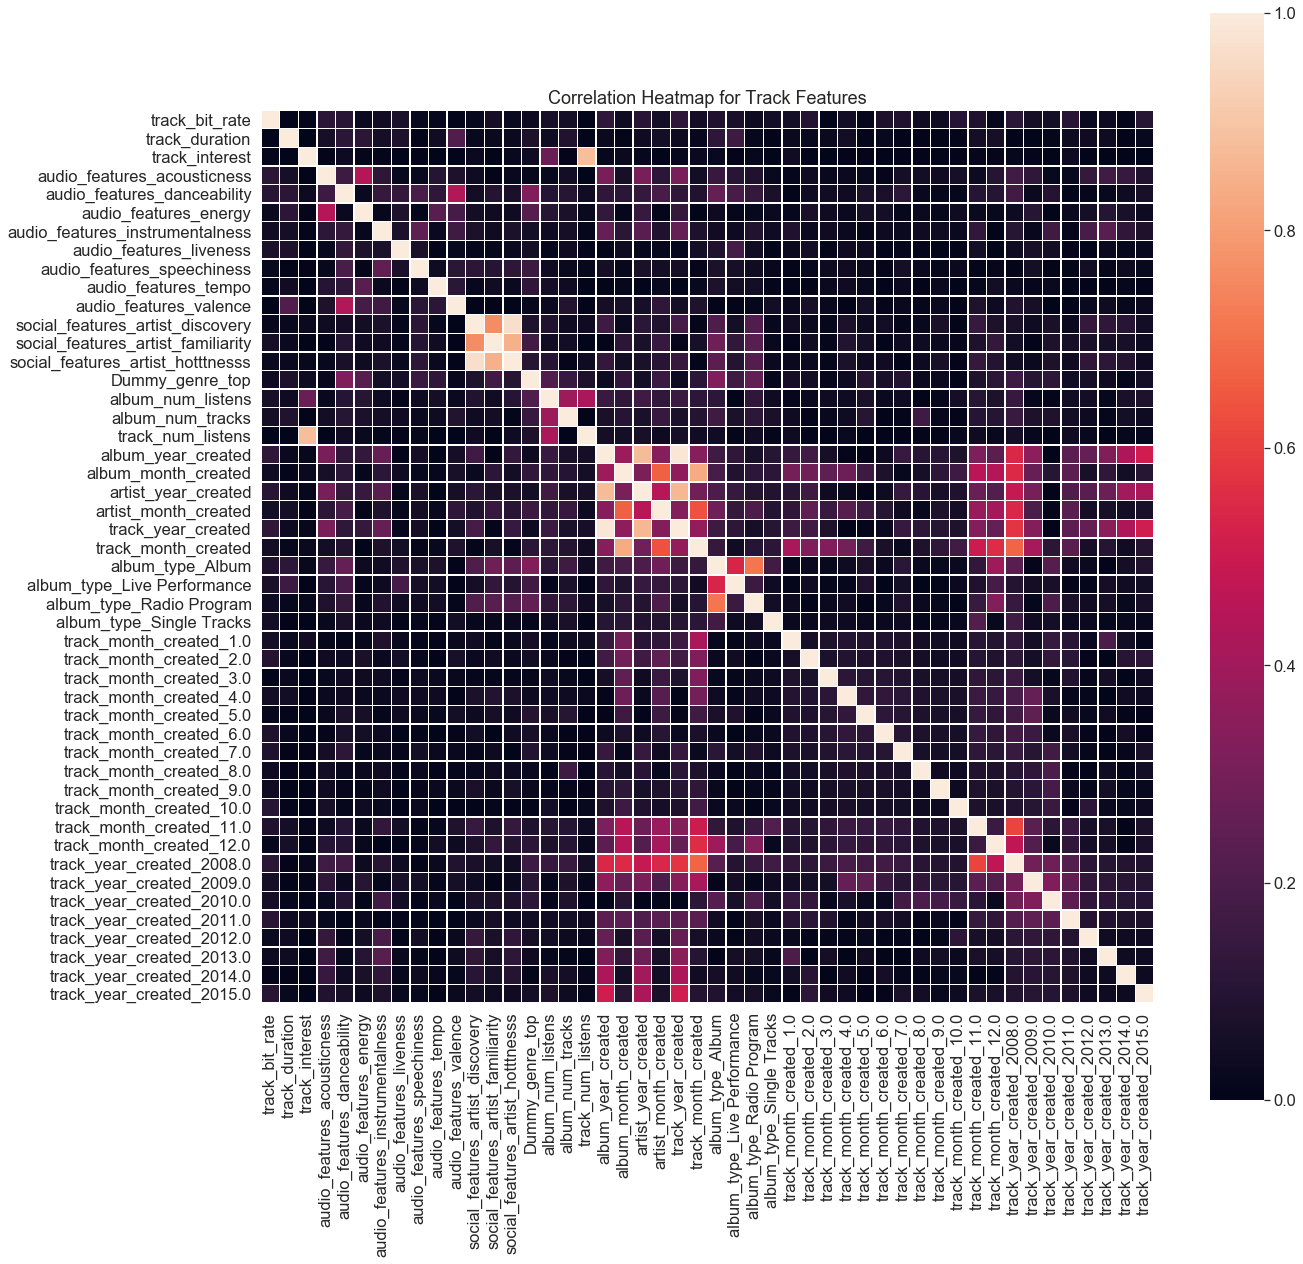

In [1402]:
#Compare feature similarities 
#Compare the numerically encoded variables and their correlations via a heatmap
plt.figure(figsize=(20,20))
sns.heatmap(abs(music.corr()), square=True, linewidths=.5, annot=False)
plt.title('Correlation Heatmap for Track Features')
plt.show()


We can see in this heatmap that there are high correlations between the respective date features, which means we only really need to retain one set without unnecessarily over-complicating the model. Additionally, `track_interest` has a high correlation with `track_num_listens` and `social_features_artist_discovery` has a high correlation with both `social_features_artist_familiarity` and `social_features_artist_hotttnesss`, so those features can be dropped to simplify the dataset even more.

In [1403]:
music = music.drop(['album_year_created', 'album_month_created', 'artist_year_created', 'artist_month_created', 'track_interest', 'social_features_artist_discovery'], axis=1)

The functions defined below take in a dataframe and sort the features into 'Binary Categorical', 'String Categorical', 'Non-Binary Numerical Categorical', and 'Numerical Continuous' by analyzing the number of unique items within each feature, and the average difference between the values (or strings) within each list of unique items.

In [1167]:
def uniqueSorting(data):
    uniques = pd.DataFrame()
    uni_col = []
    num_uni = []
    avgdiff_uni = []

    for col in list(data.columns):
        try:
            uni_col.append(list(np.unique(data[col])))
            num_uni.append(len(np.unique(data[col])))
        except:
            uni_col.append(list((data[col]).unique()[pd.notnull(list((data[col]).unique()))]))
            num_uni.append(len((data[col]).unique()[pd.notnull(list((data[col]).unique()))]))

        try:
            avgdiff_uni.append(np.mean(np.diff(np.unique(data[col]))))
        except: 
            avgdiff_uni.append('N/A')

    uniques['Category'] = list(data.columns)
    uniques['Unique Values'] = uni_col
    uniques['Num Uniques'] = num_uni
    uniques['Avg Diff Among Uniques'] = avgdiff_uni
    
    return uniques

In [1168]:
def catSorting(data):
    uniques = uniqueSorting(data)
    
    drop_cols = [uniques['Category'][i] for i in range(len(uniques)) if uniques['Num Uniques'][i] == 1]
    data = data.drop(drop_cols, axis=1)
    
    uniques = uniqueSorting(data)

    #Separate features by type
    #String Categoricals:
    str_cat_cols = []
    for col in list(data.columns): 
        if (list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] == 'N/A'):
            str_cat_cols.append(col)

    #Binary Categoricals:
    bin_cat_cols = []
    for col in list(data.columns):
        if (col not in str_cat_cols):   
            if (list(uniques[uniques['Category']==col]['Num Uniques'])[0] == 2):
                bin_cat_cols.append(col)

    #Numerical Categorical features:
    cat_cols = []
    for col in list(data.columns):
        if ((col not in str_cat_cols) and (col not in bin_cat_cols)):   
            if (list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] == 1):
                cat_cols.append(col)

    #Continuous features:
    cont_cols = []
    for col in list(data.columns):
        if ((col not in cat_cols) and (col not in str_cat_cols) and (col not in bin_cat_cols)):
            cont_cols.append(col)

    print('String Categorical Features: \n', str_cat_cols)

    print('\nBinary Dummy Categorical Features: \n', bin_cat_cols)

    print('\nNumerical Categorical Features: \n', cat_cols)

    print('\nContinuous Features: \n', cont_cols)
    
    return data, str_cat_cols, bin_cat_cols, cat_cols, cont_cols

In [1404]:
music, str_cat_cols, bin_cat_cols, cat_cols, cont_cols = catSorting(music)

String Categorical Features: 
 ['album_type', 'artist_name', 'track_genre_top']

Binary Dummy Categorical Features: 
 ['album_type_Album', 'album_type_Live Performance', 'album_type_Radio Program', 'album_type_Single Tracks', 'track_month_created_1.0', 'track_month_created_2.0', 'track_month_created_3.0', 'track_month_created_4.0', 'track_month_created_5.0', 'track_month_created_6.0', 'track_month_created_7.0', 'track_month_created_8.0', 'track_month_created_9.0', 'track_month_created_10.0', 'track_month_created_11.0', 'track_month_created_12.0', 'track_year_created_2008.0', 'track_year_created_2009.0', 'track_year_created_2010.0', 'track_year_created_2011.0', 'track_year_created_2012.0', 'track_year_created_2013.0', 'track_year_created_2014.0', 'track_year_created_2015.0']

Numerical Categorical Features: 
 ['Dummy_genre_top', 'track_year_created', 'track_month_created']

Continuous Features: 
 ['track_bit_rate', 'track_duration', 'audio_features_acousticness', 'audio_features_danceab

## Dataset Analysis and Visualization

### Distributions of the Continuous Features

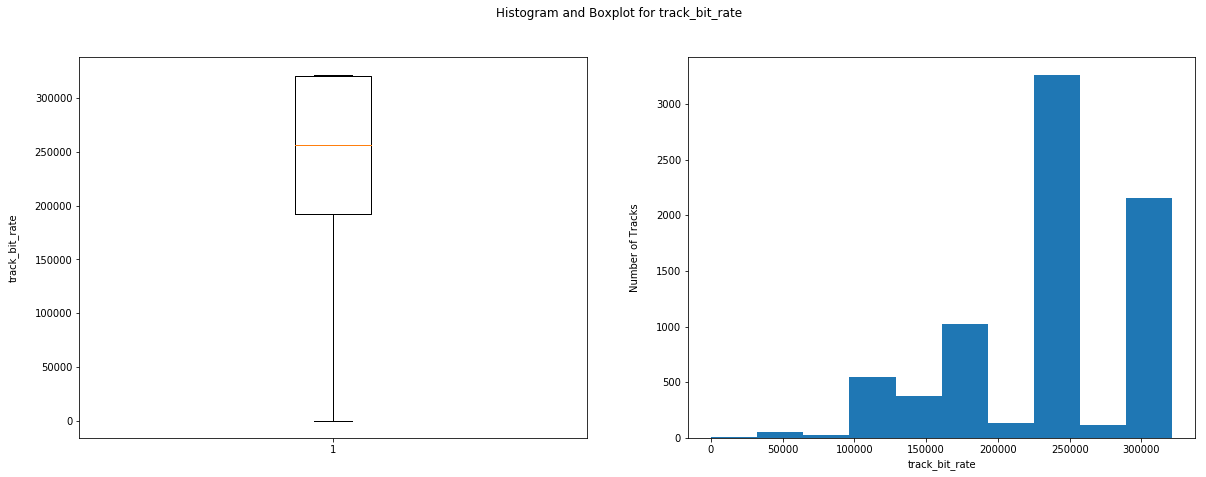

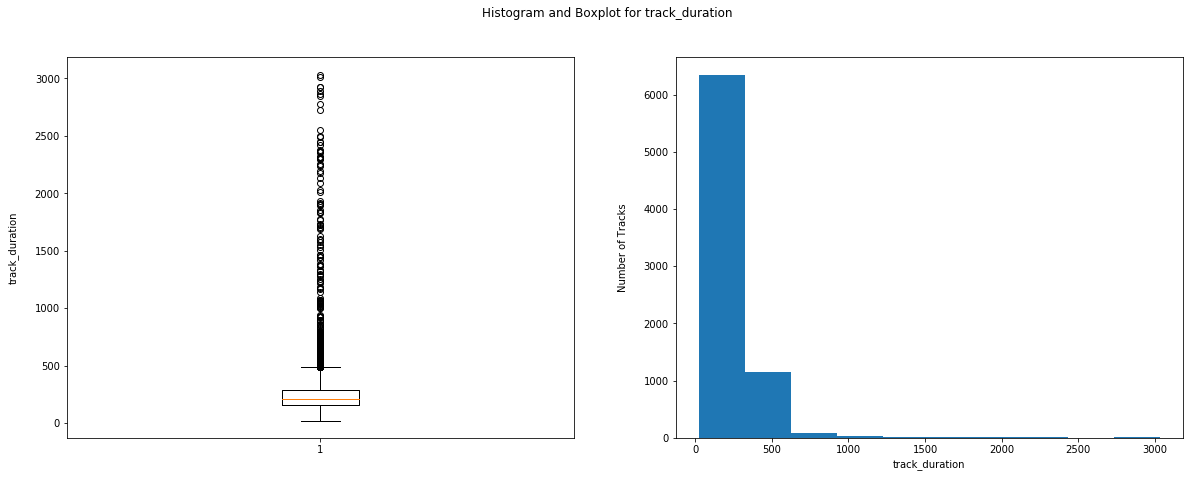

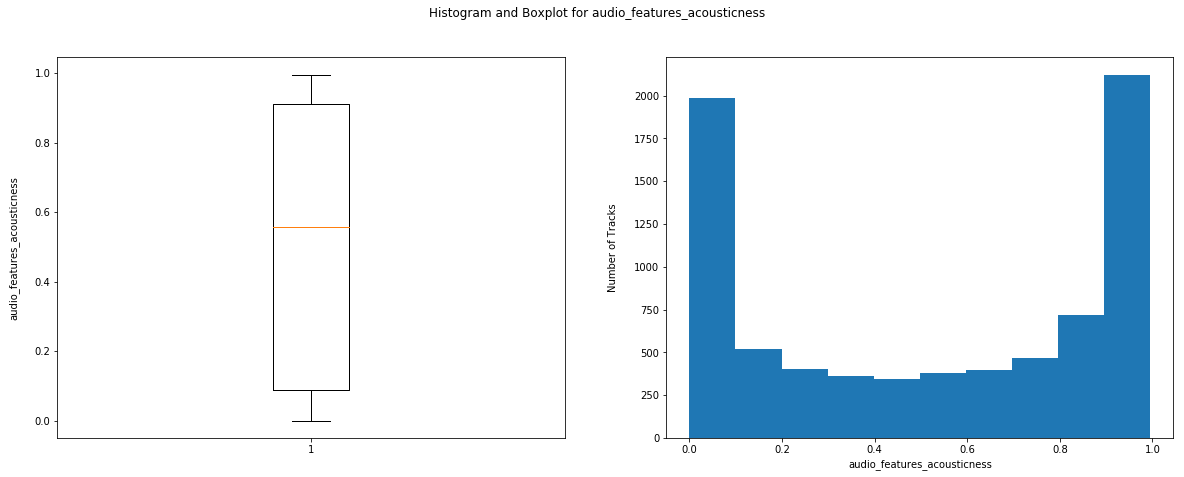

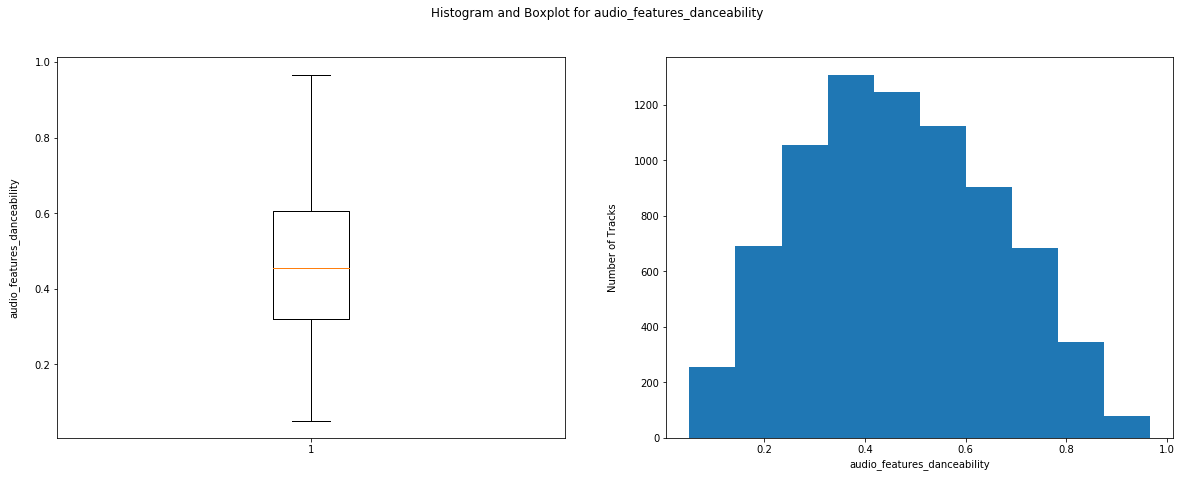

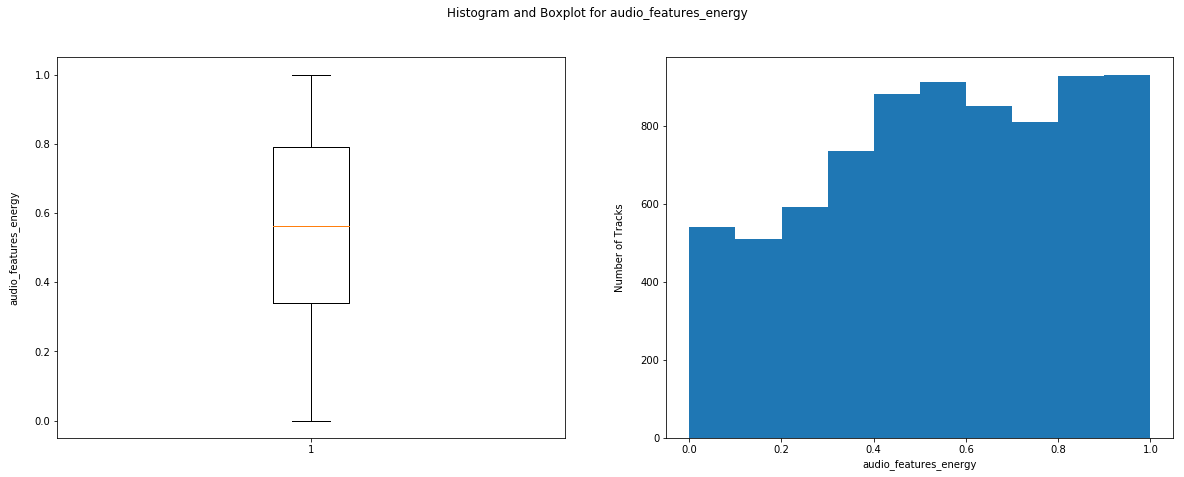

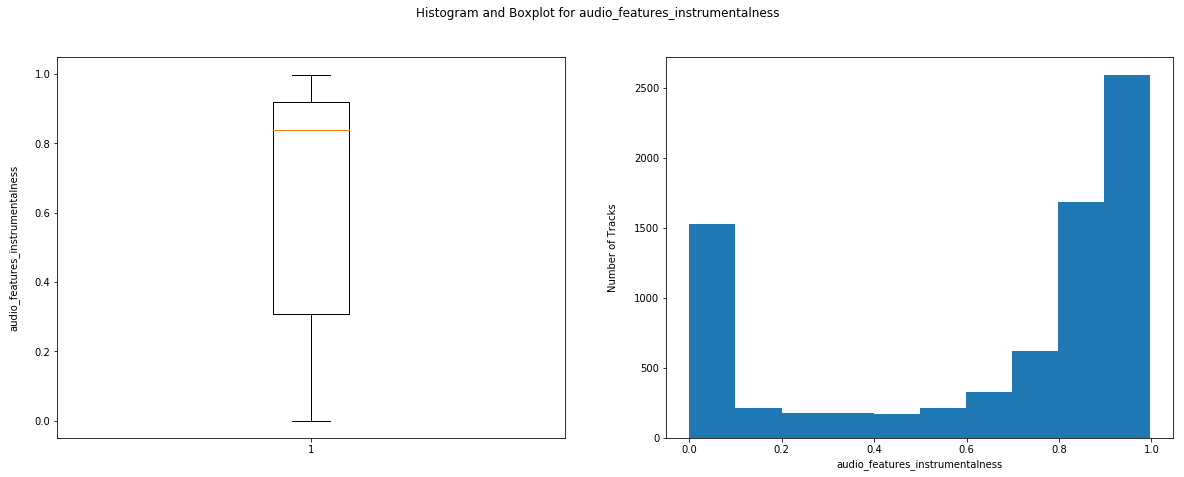

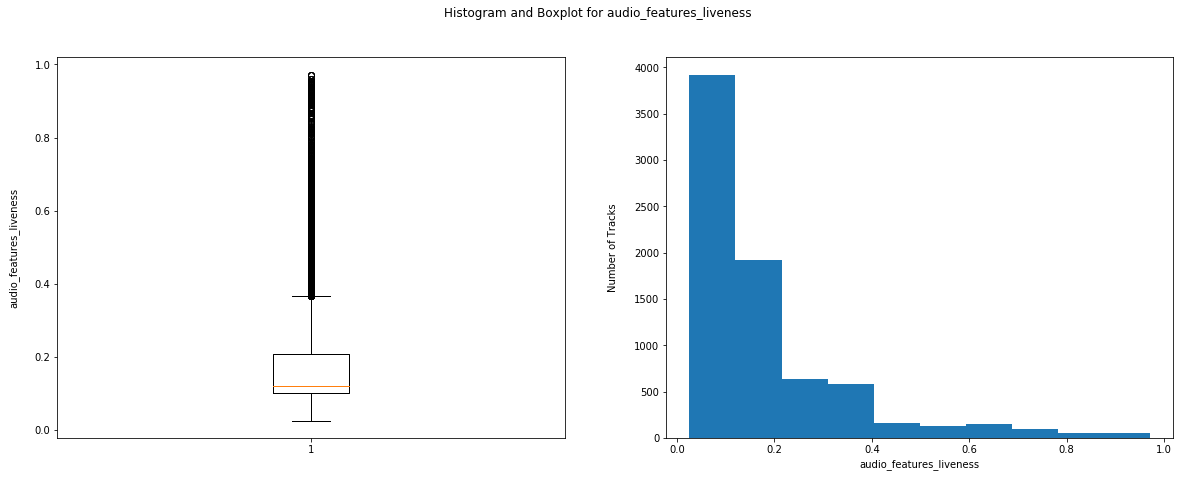

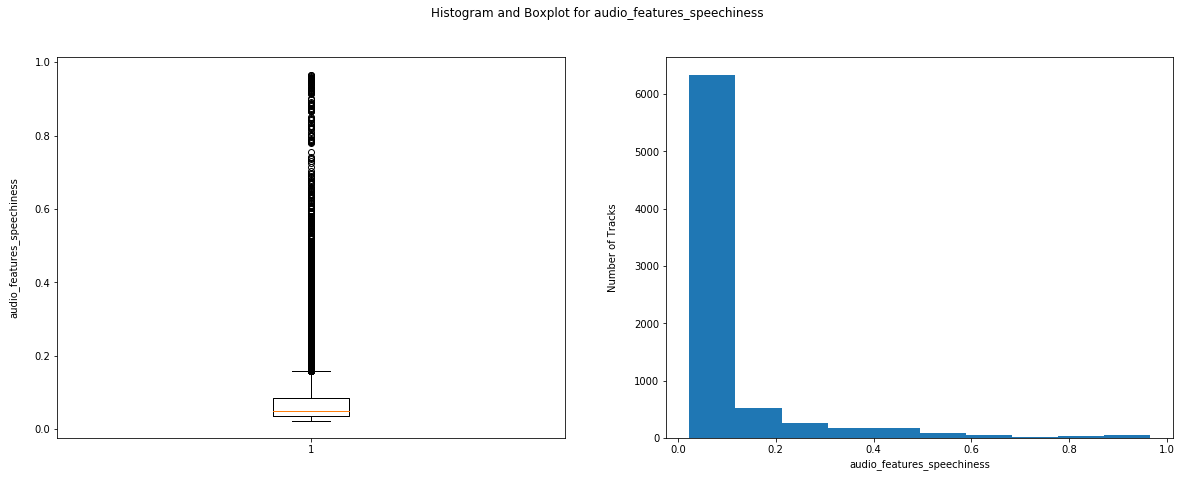

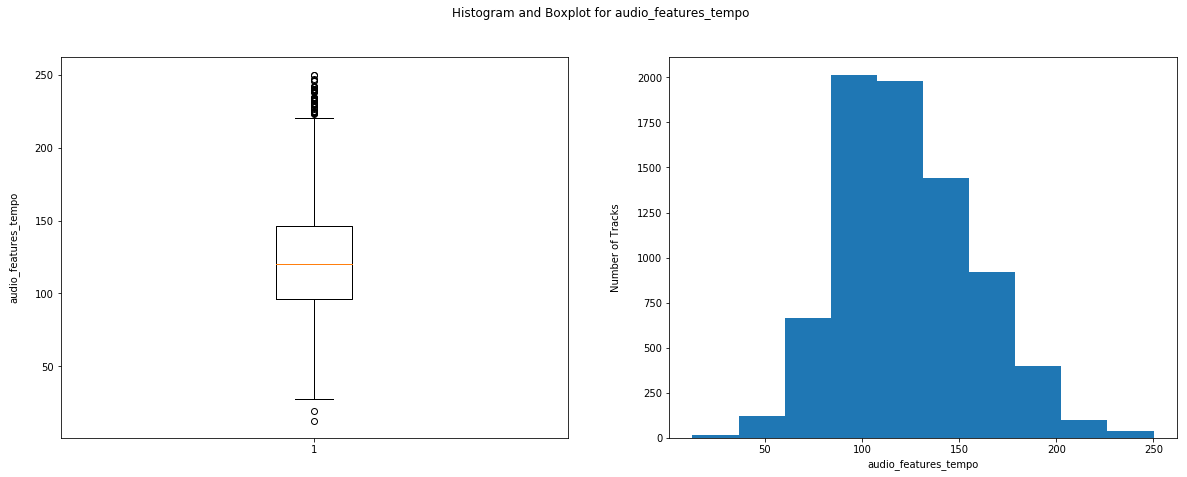

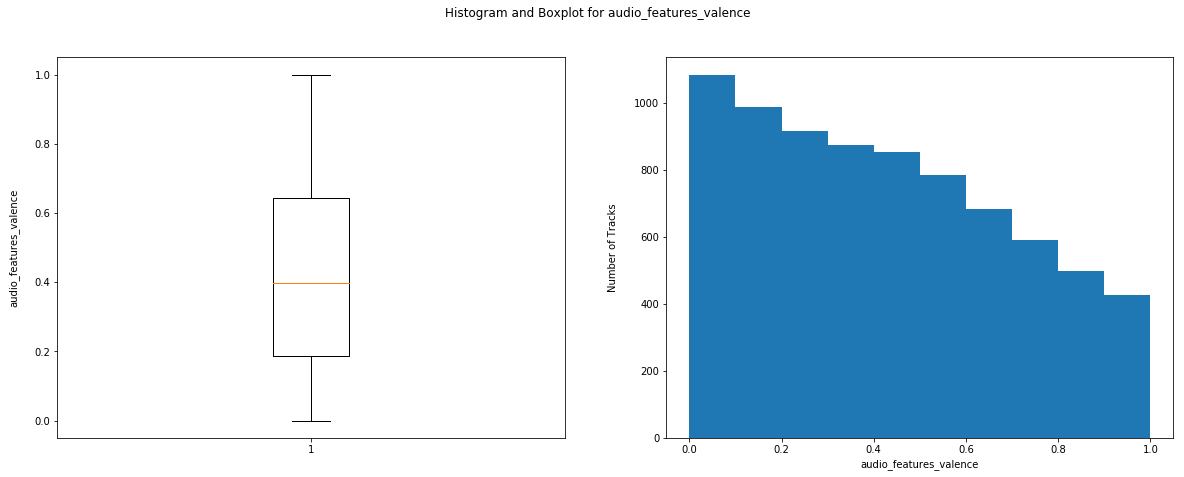

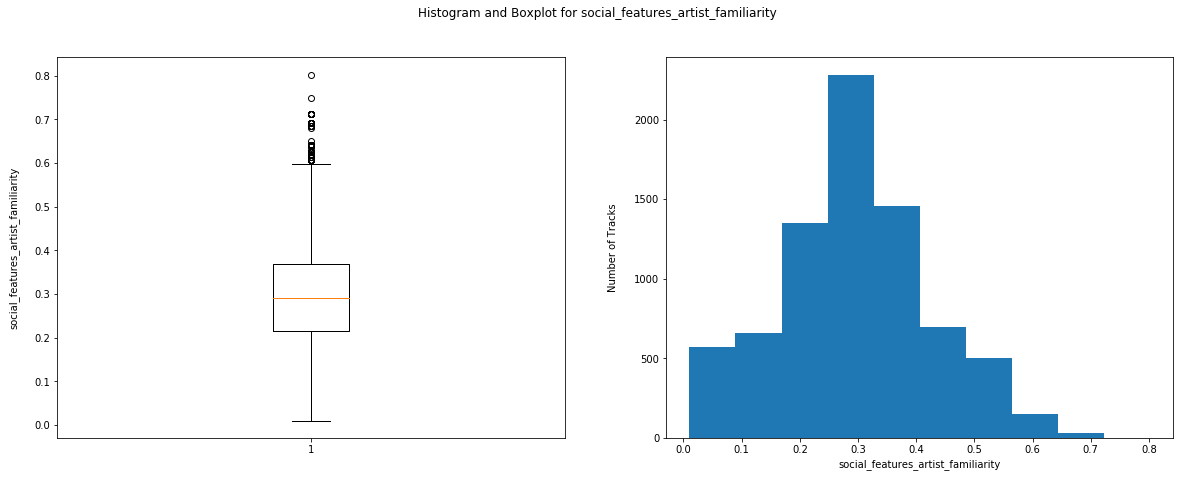

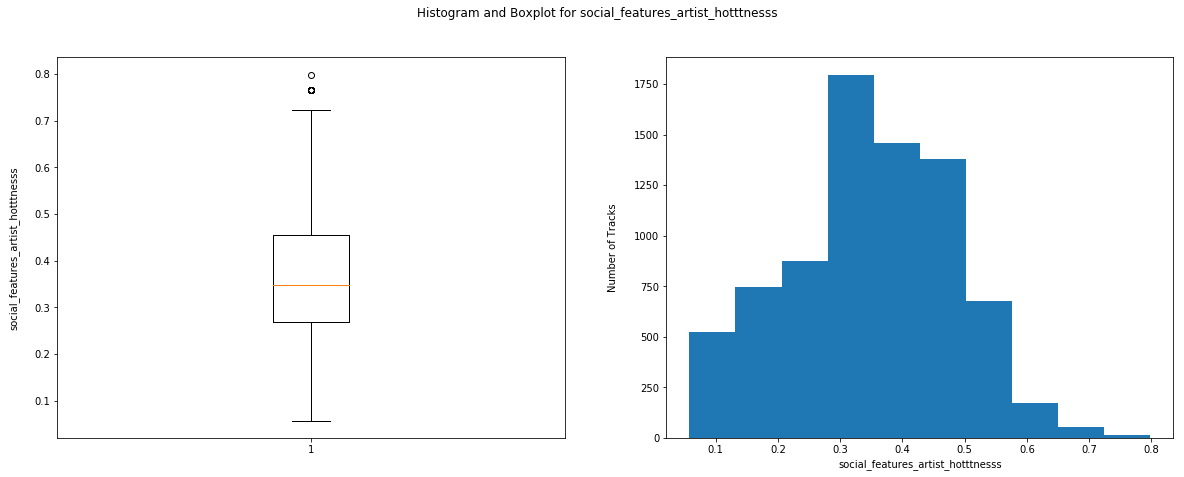

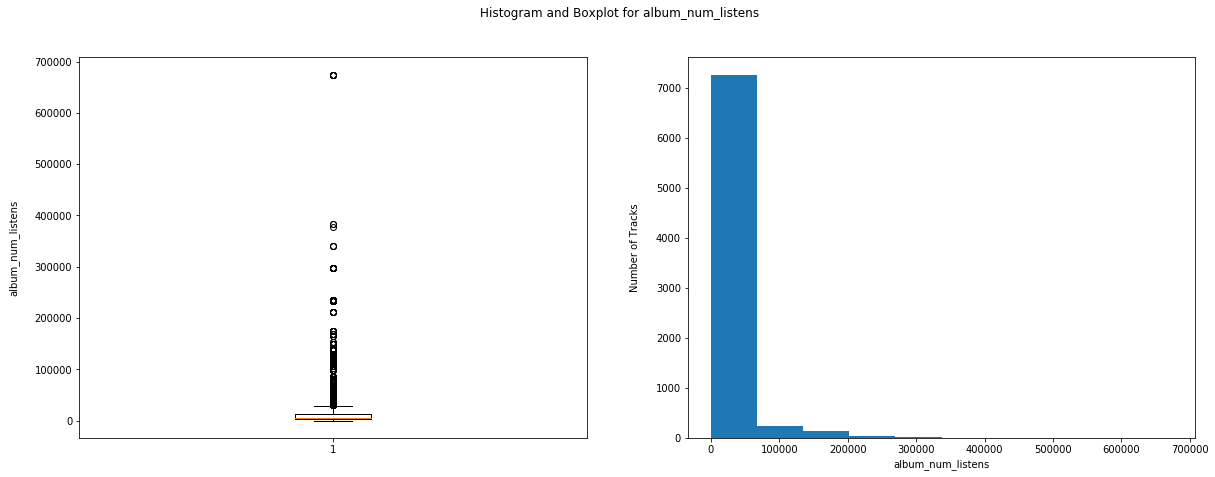

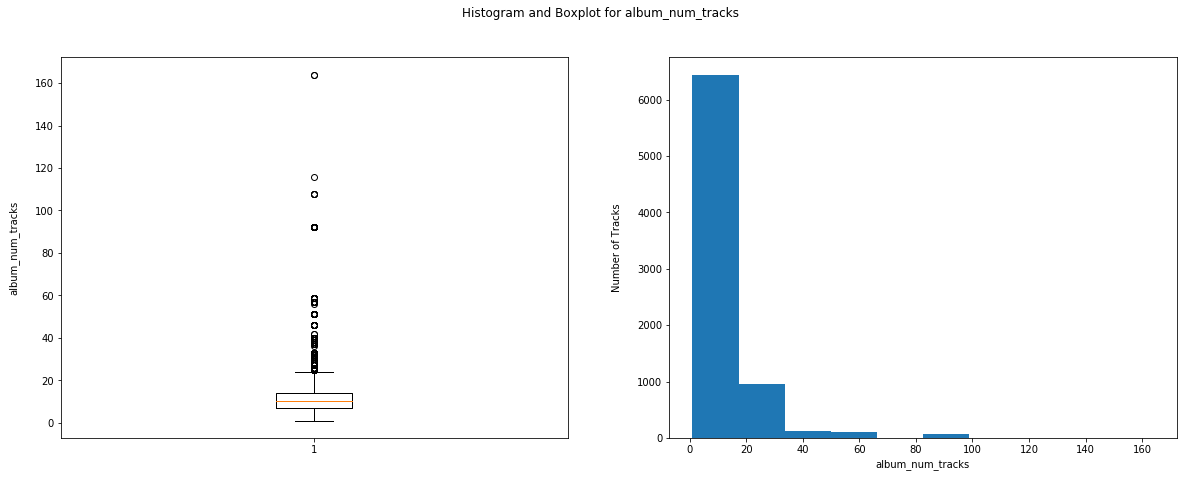

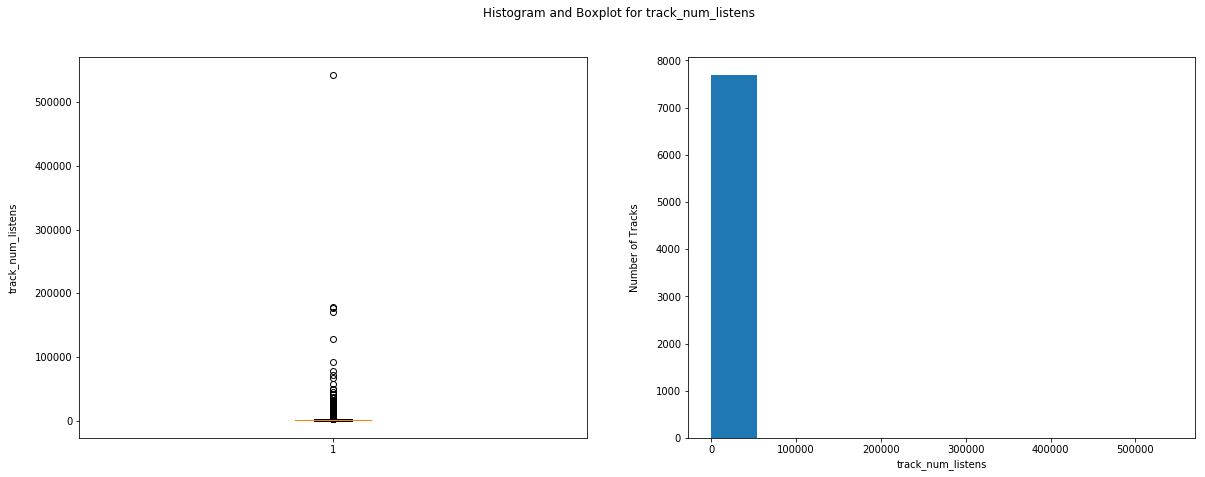

In [587]:
%matplotlib inline
#Distributions of features
for col in cont_cols:
    plt.figure(figsize=(20, 7))
    
    plt.subplot(1,2,1)
    plt.boxplot(music[col])
    plt.xlabel('')
    plt.ylabel(col +'\n')
    
    plt.subplot(1,2,2)    
    plt.hist(music[col])
    plt.xlabel(col)
    plt.ylabel('Number of Tracks\n')
    
    plt.suptitle('Histogram and Boxplot for ' + col + '\n')
    plt.show()

### Distributions of the Categorical Features

In [1165]:
cc = cat_cols[:-2]
cc

['track_year_created', 'track_month_created', 'Dummy_album_type']

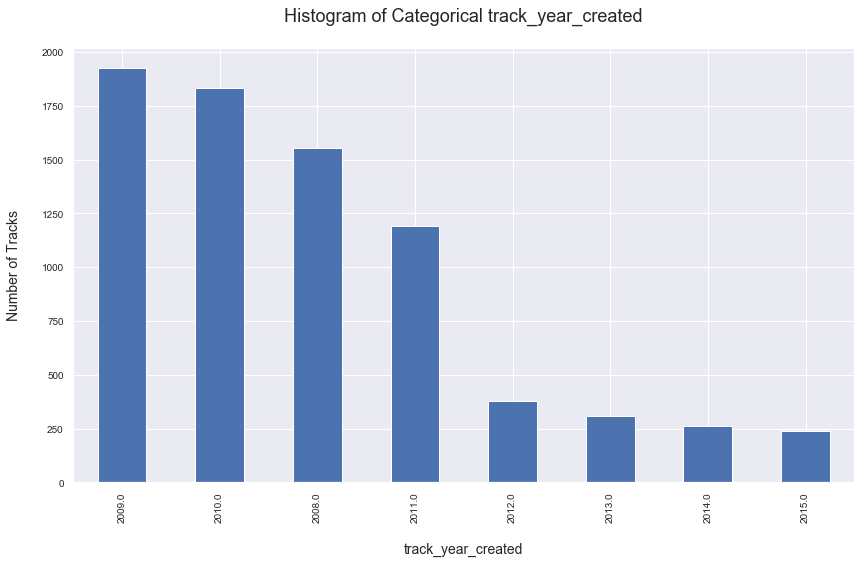

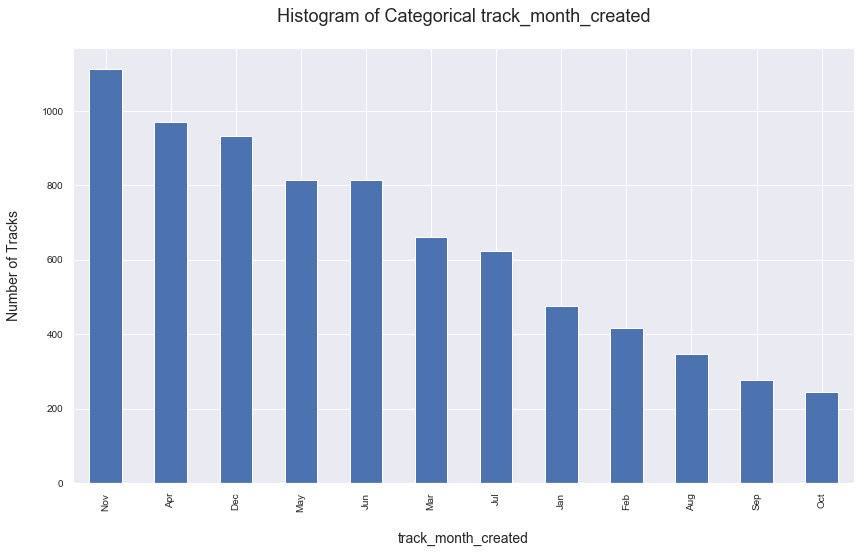

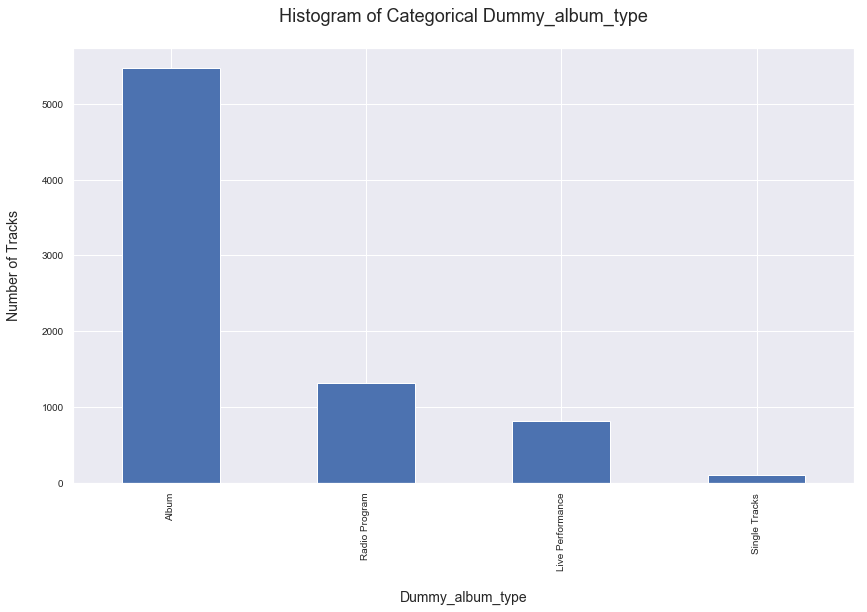

In [1166]:
#Analyze all of the categorical variables
#Bar chart with count on the y-axis and categorical variable on the x-axis
plt.figure(figsize=(50, 50))

unique_years = list(np.unique(music['track_year_created']))
unique_months = ['Jan', 'Feb', 'Mar', 'Apr',  'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
unique_type = list(np.unique(music['album_type']))

xax_labs = [unique_years, unique_months, unique_type]
for i in range(len(cc)):
    ax = music[cc[i]].value_counts().plot(kind='bar', figsize=(14,8), fontsize = 10)
    ax.set_title("Histogram of Categorical " + cc[i] + "\n", fontsize=18)
    ax.set_xlabel("\n"+cc[i], fontsize=14)
    lab = [item.get_text() for item in ax.get_xticklabels()]
    lab = [int(item.split('.')[0]) for item in lab]
    ax.set_xticklabels([xax_labs[i][ind - min(lab)] for ind in lab], rotation=90)
    ax.set_ylabel("Number of Tracks\n", fontsize=14)
    plt.show()
    
    plt.show()

As you can see in the above plots, we have some potential issues with our dataset. In terms of the categorical features, the issue is one of class imbalance, in that there isn't an even split between the different categories. While that may cause issues in the future, let's not worry about that for the time being. For the continuous features, the main issue is that many of the features have a lot of outliers that are skewing the data distributions. Fortunately, we can deal with that issue through Winsorization.

## Continuous Features - Outlier Removal via Winsorization

In [864]:
#Determine extent of outliers using Tukey's method
outlier_loc = []
top_outlier_percent = []
bottom_outlier_percent = []

for col in list(cont_cols):
    q75, q25 = np.percentile(music[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    if (len((np.where(music[col] > max_val))[0]) > 0):
        if (len((np.where(music[col] < min_val))[0]) > 0):
            loc_now = 'both ends'
        else:
            loc_now = 'top'
    else:
        loc_now = 'bottom'
    
    outlier_loc.append(loc_now)
    print("Percentage of outliers in {}, located at {} of range: {}".format(col, loc_now, len((np.where((music[col] > max_val) |(music[col] < min_val))[0]))/len(music)))
    
    top_percent = len((np.where((music[col] > max_val))[0]))/len(music)
    #Get values to the closest whole percent
    top_outlier_percent.append(math.ceil(top_percent*100)/100)
    
    bottom_percent = len((np.where((music[col] < min_val))[0]))/len(music)
    #Get values to the closest whole percent
    bottom_outlier_percent.append(math.ceil(bottom_percent*100)/100)


Percentage of outliers in track_bit_rate, located at bottom of range: 0.0
Percentage of outliers in track_duration, located at top of range: 0.04875828890911455
Percentage of outliers in audio_features_acousticness, located at bottom of range: 0.0
Percentage of outliers in audio_features_danceability, located at bottom of range: 0.0
Percentage of outliers in audio_features_energy, located at bottom of range: 0.0
Percentage of outliers in audio_features_instrumentalness, located at bottom of range: 0.0
Percentage of outliers in audio_features_liveness, located at top of range: 0.10674814718502146
Percentage of outliers in audio_features_speechiness, located at top of range: 0.1393836952281888
Percentage of outliers in audio_features_tempo, located at both ends of range: 0.006761149395397218
Percentage of outliers in audio_features_valence, located at bottom of range: 0.0
Percentage of outliers in social_features_artist_familiarity, located at top of range: 0.014432453517097907
Percentag

In [865]:
#Show calculated outlier parameters to be used for winsorization
out_df = pd.DataFrame()

out_df['variable name'] = list(cont_cols)
out_df['top outliers'] = top_outlier_percent
out_df['bottom outliers'] = bottom_outlier_percent
out_df['outlier location'] = outlier_loc

out_df

variable name  top outliers  bottom outliers  \
0                       track_bit_rate          0.00             0.00   
1                       track_duration          0.05             0.00   
2          audio_features_acousticness          0.00             0.00   
3          audio_features_danceability          0.00             0.00   
4                audio_features_energy          0.00             0.00   
5      audio_features_instrumentalness          0.00             0.00   
6              audio_features_liveness          0.11             0.00   
7           audio_features_speechiness          0.14             0.00   
8                 audio_features_tempo          0.01             0.01   
9               audio_features_valence          0.00             0.00   
10  social_features_artist_familiarity          0.02             0.00   
11   social_features_artist_hotttnesss          0.01             0.00   
12                   album_num_listens          0.12             0.00   
13                    album_num_tracks          0.09             0.00   
14                   track_num_listens          0.10             0.00   

   outlier location  
0            bottom  
1               top  
2            bottom  
3            bottom  
4            bottom  
5            bottom  
6               top  
7               top  
8         both ends  
9            bottom  
10              top  
11              top  
12              top  
13              top  
14              top

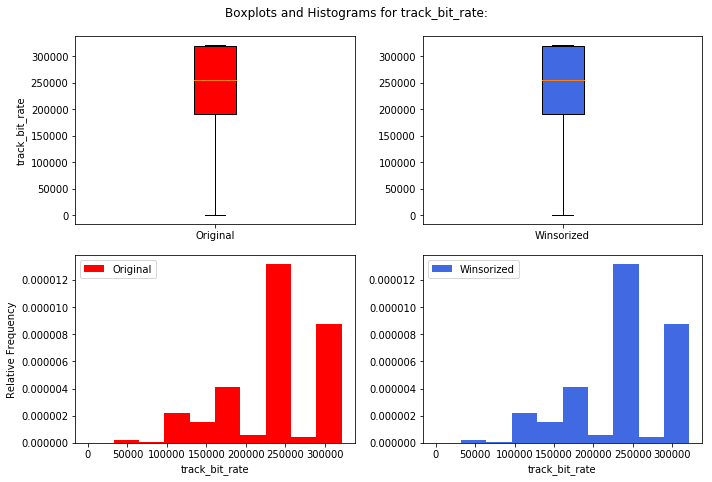

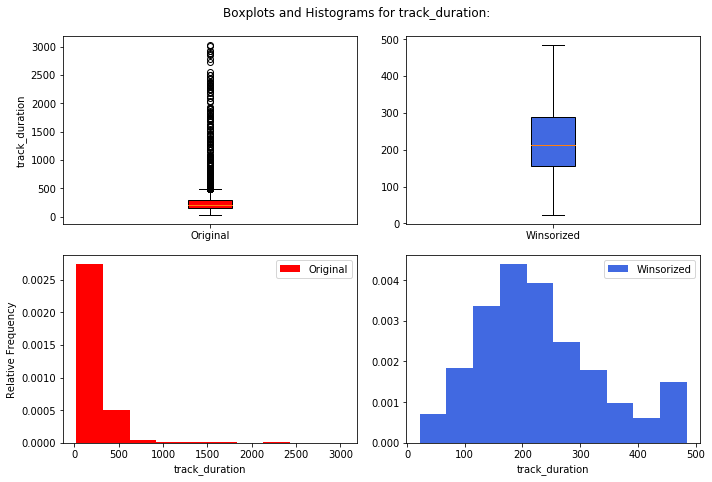

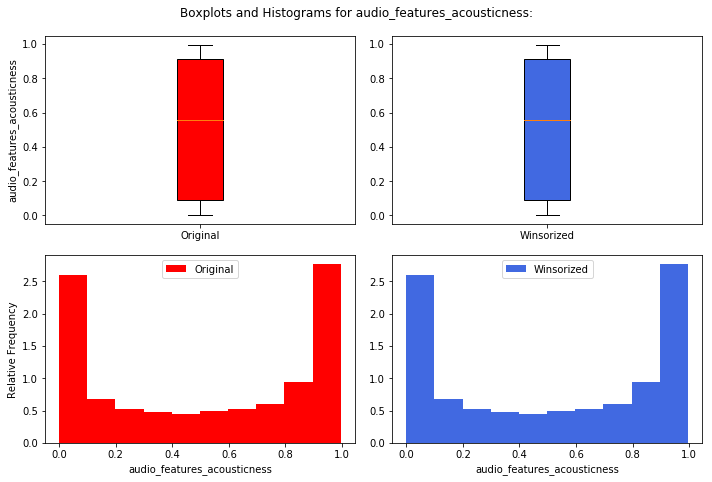

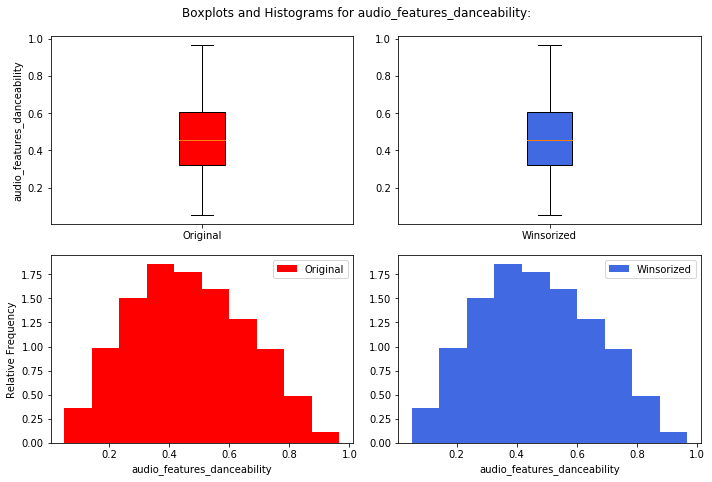

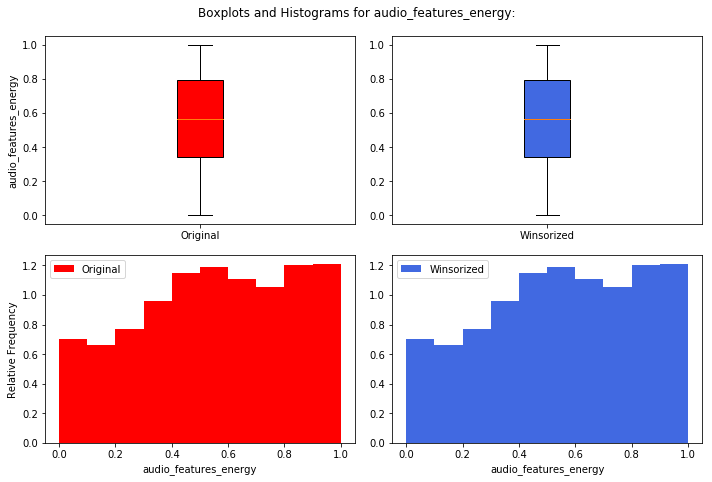

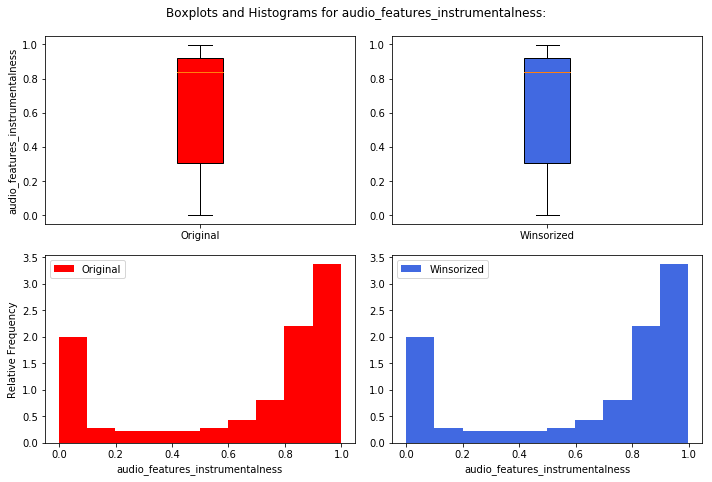

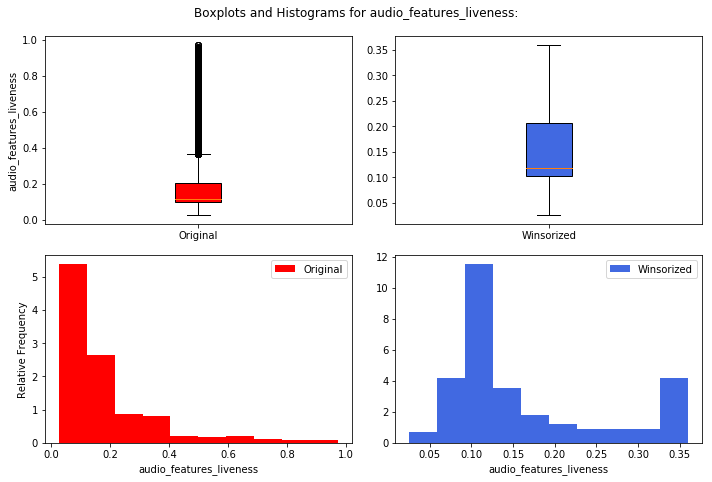

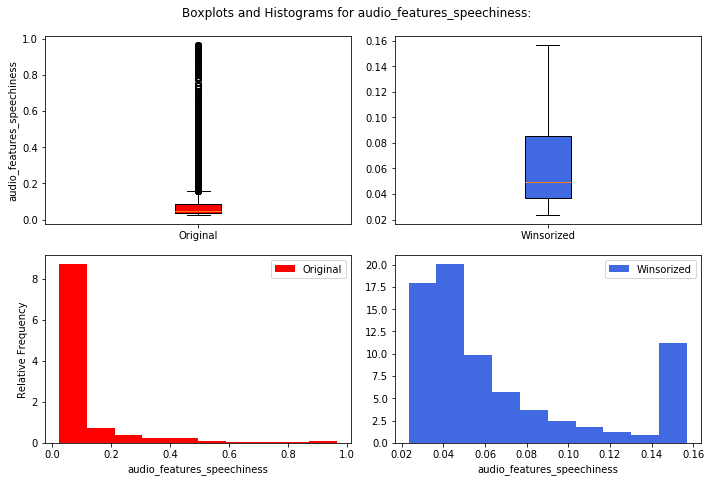

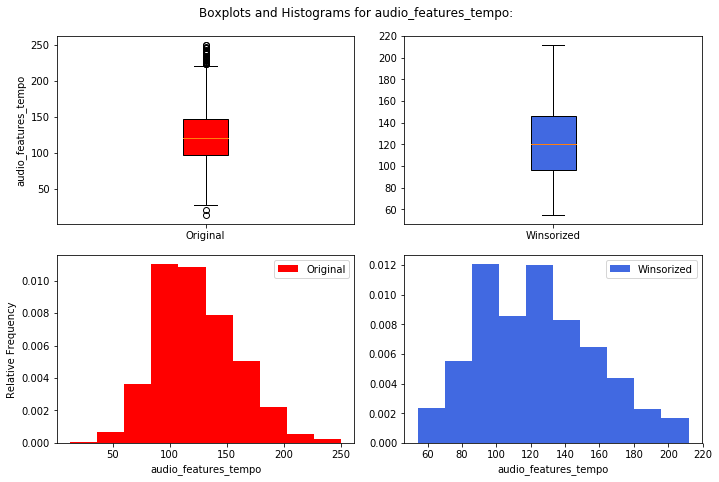

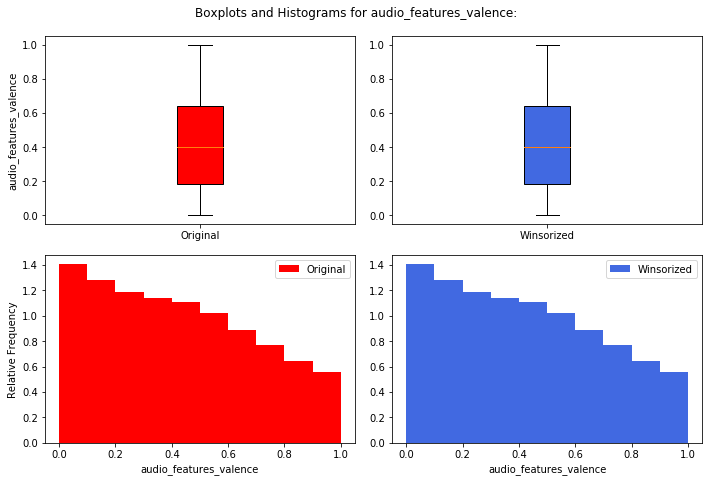

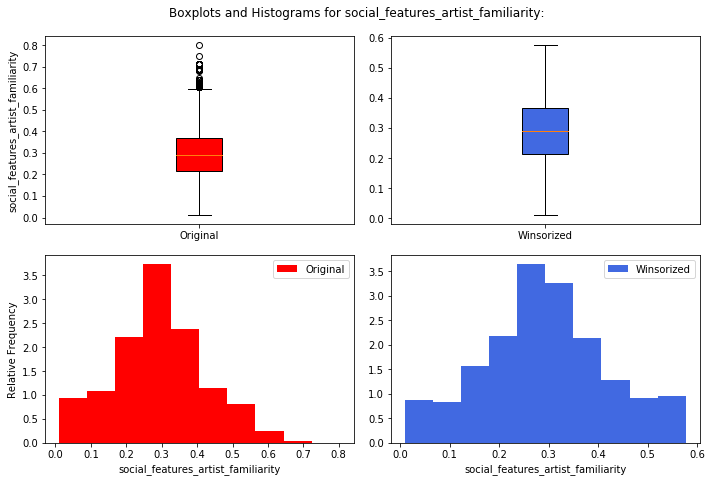

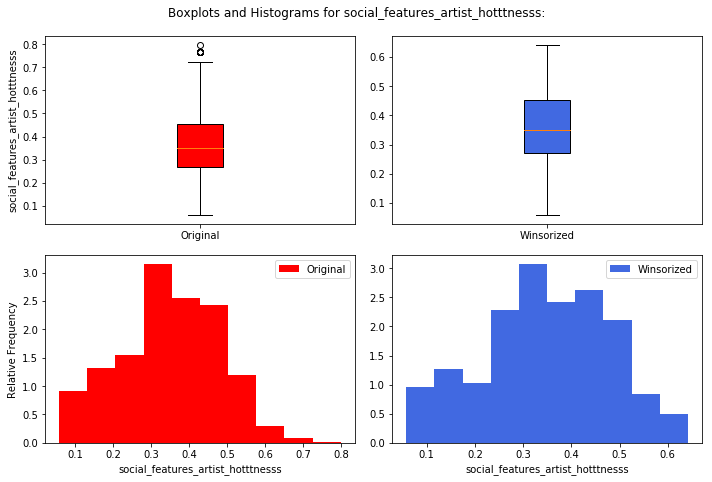

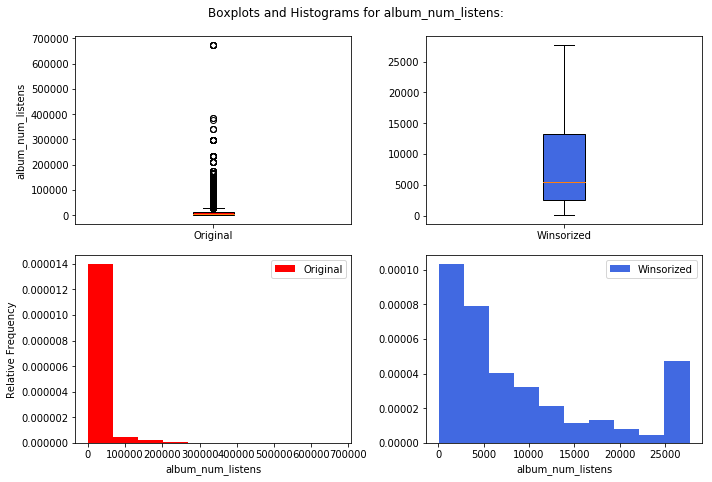

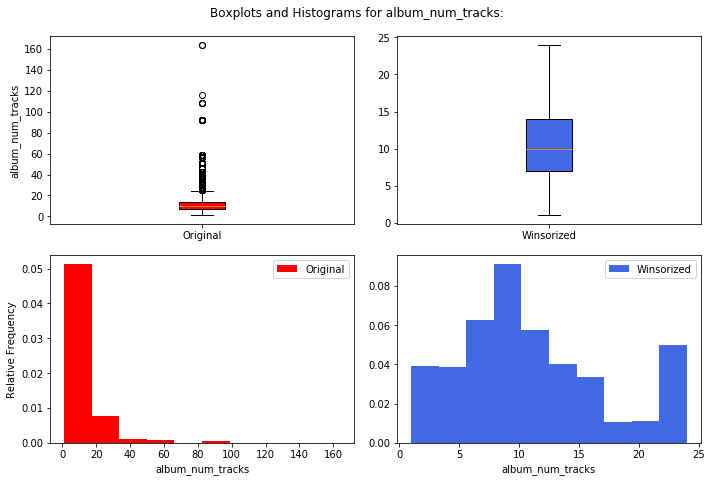

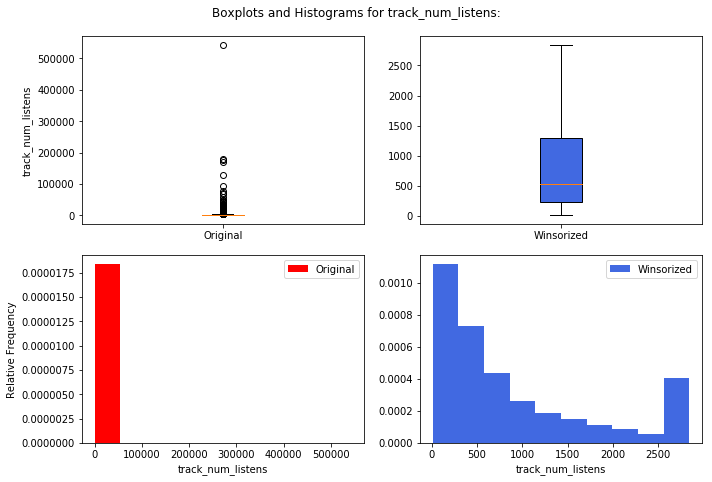

In [866]:
#Transform/remove the outliers, using winsorize()
from scipy.stats.mstats import winsorize

winsorized_cols = pd.DataFrame()

cols = cont_cols
for i in range(len(cols)):
    winsorized_cols[cols[i]] = winsorize(music[cols[i]], (bottom_outlier_percent[i], top_outlier_percent[i]))

#Analyze the effects of winsorization on boxplots/histograms:
for col in cols:
    plt.figure(figsize=(10,7))
    plt.subplot(2,2,1)
    box = plt.boxplot([music[col]], patch_artist=True, labels = ['Original'])
    plt.ylabel(col)
    colors = ['red']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.subplot(2,2,2)
    box = plt.boxplot([winsorized_cols[col]], patch_artist=True, labels = ['Winsorized'])
    colors = ['royalblue']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)


    plt.subplot(2,2,3)
    plt.hist([music[col]], color='red', label = ['Original'], normed=True)
    plt.xlabel(col)
    plt.ylabel('Relative Frequency')
    plt.legend()  

    plt.subplot(2,2,4)
    plt.hist([winsorized_cols[col]], color='royalblue', label = ['Winsorized'], normed=True)
    plt.xlabel(col)
    plt.legend()
    
    
    plt.suptitle('Boxplots and Histograms for ' + col + ':')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    

In [868]:
music = music.reset_index(drop=True)
music_new = winsorized_cols.copy()
music_new.columns = [str('Winsorized ' + item) for item in list(cont_cols)]

for col in music.columns.drop(cont_cols):
    music_new[col] = music[col]

#Description of winsorized dataframe statistics
music_new.describe()

Winsorized track_bit_rate  Winsorized track_duration  \
count                7691.000000                7691.000000   
mean               248498.971005                 230.552984   
std                 60973.240561                 107.060567   
min                   192.000000                  22.000000   
25%                192000.000000                 155.000000   
50%                256000.000000                 212.000000   
75%                320000.000000                 288.000000   
max                321550.000000                 485.000000   

       Winsorized audio_features_acousticness  \
count                            7.691000e+03   
mean                             5.160037e-01   
std                              3.848713e-01   
min                              9.035000e-07   
25%                              8.788122e-02   
50%                              5.578407e-01   
75%                              9.124709e-01   
max                              9.957965e-01   

       Winsorized audio_features_danceability  \
count                             7691.000000   
mean                                 0.465719   
std                                  0.191626   
min                                  0.051307   
25%                                  0.320503   
50%                                  0.454155   
75%                                  0.606235   
max                                  0.966883   

       Winsorized audio_features_energy  \
count                       7691.000000   
mean                           0.551078   
std                            0.277040   
min                            0.000020   
25%                            0.340439   
50%                            0.563715   
75%                            0.791991   
max                            0.999964   

       Winsorized audio_features_instrumentalness  \
count                                7.691000e+03   
mean                                 6.376555e-01   
std                                  3.639693e-01   
min                                  1.000000e-10   
25%                                  3.071900e-01   
50%                                  8.373353e-01   
75%                                  9.193023e-01   
max                                  9.980162e-01   

       Winsorized audio_features_liveness  \
count                         7691.000000   
mean                             0.164630   
std                              0.095554   
min                              0.025297   
25%                              0.101911   
50%                              0.118917   
75%                              0.207551   
max                              0.360354   

       Winsorized audio_features_speechiness  Winsorized audio_features_tempo  \
count                            7691.000000                      7691.000000   
mean                                0.068738                       123.440478   
std                                 0.043420                        34.154614   
min                                 0.023234                        54.326000   
25%                                 0.037028                        96.036500   
50%                                 0.049366                       120.377000   
75%                                 0.085290                       146.490500   
max                                 0.156981                       211.846000   

       Winsorized audio_features_valence  ...  track_month_created_11.0  \
count                        7691.000000  ...               7691.000000   
mean                            0.424739  ...                  0.144715   
std                             0.273499  ...                  0.351836   
min                             0.000010  ...                  0.000000   
25%                             0.186261  ...                  0.000000   
50%                             0.399021  ...                  0.000000   
75%                         

In [869]:
music_new.head()

Winsorized track_bit_rate  Winsorized track_duration  \
0                   256000.0                      168.0   
1                   256000.0                      237.0   
2                   256000.0                      206.0   
3                   192000.0                      161.0   
4                   256000.0                      207.0   

   Winsorized audio_features_acousticness  \
0                                0.416675   
1                                0.374408   
2                                0.043567   
3                                0.951670   
4                                0.452217   

   Winsorized audio_features_danceability  Winsorized audio_features_energy  \
0                                0.675894                          0.634476   
1                                0.528643                          0.817461   
2                                0.745566                          0.701470   
3                                0.658179                          0.924525   
4                                0.513238                          0.560410   

   Winsorized audio_features_instrumentalness  \
0                                    0.010628   
1                                    0.001851   
2                                    0.000697   
3                                    0.965427   
4                                    0.019443   

   Winsorized audio_features_liveness  Winsorized audio_features_speechiness  \
0                            0.177647                               0.156981   
1                            0.105880                               0.156981   
2                            0.360354                               0.124595   
3                            0.115474                               0.032985   
4                            0.096567                               0.156981   

   Winsorized audio_features_tempo  Winsorized audio_features_valence  ...  \
0                          165.922                           0.576661  ...   
1                          126.957                           0.269240  ...   
2                          100.260                           0.621661  ...   
3                          111.562                           0.963590  ...   
4                          114.290                           0.894072  ...   

   track_month_created_11.0  track_month_created_12.0  \
0                         1                         0   
1                         1                         0   
2                         1                         0   
3                         1                         0   
4                         1                         0   

   track_year_created_2008.0  track_year_created_2009.0  \
0                          1                          0   
1                          1                          0   
2                          1                          0   
3                          1                          0   
4                          1                          0   

   track_year_created_2010.0 track_year_created_2011.0  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         0   

  track_year_created_2012.0 track_year_created_2013.0  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   track_year_created_2014.0  track_year_created_2015.0  
0                          0                          0  
1                          0                          0  
2                          0                          0  
3                          0       

Our newly derived dataset will have fewer issues when we get to the modeling portion of this project, since the outliers have now been removed. Below, I generated some boxplots to determine if there was a significant difference in the distributions of each continuous variable, once separated by category, particularly month_created, year_created, and album_type.

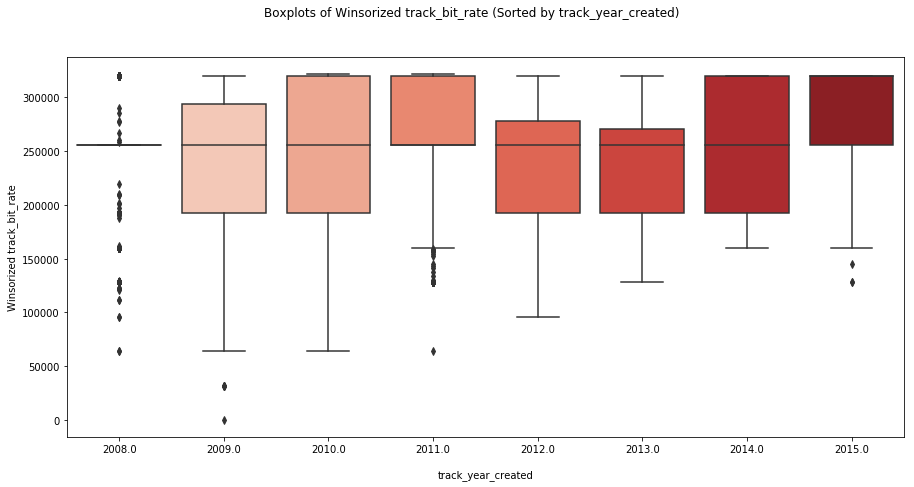

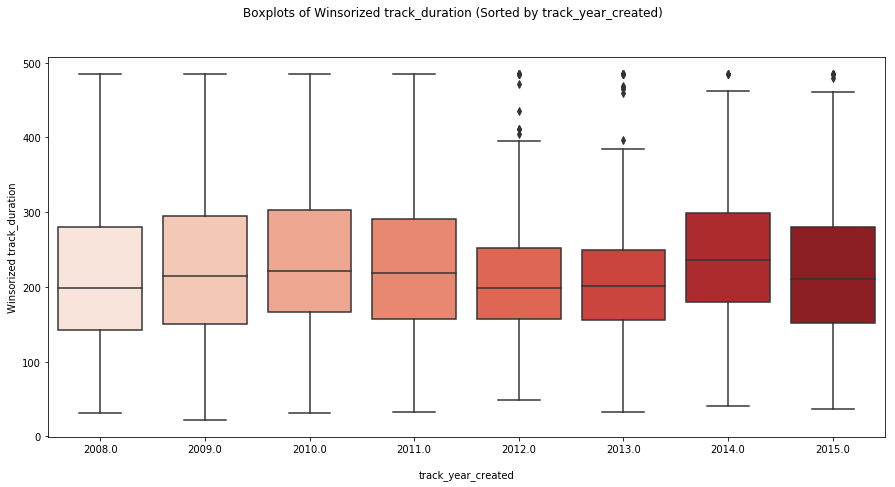

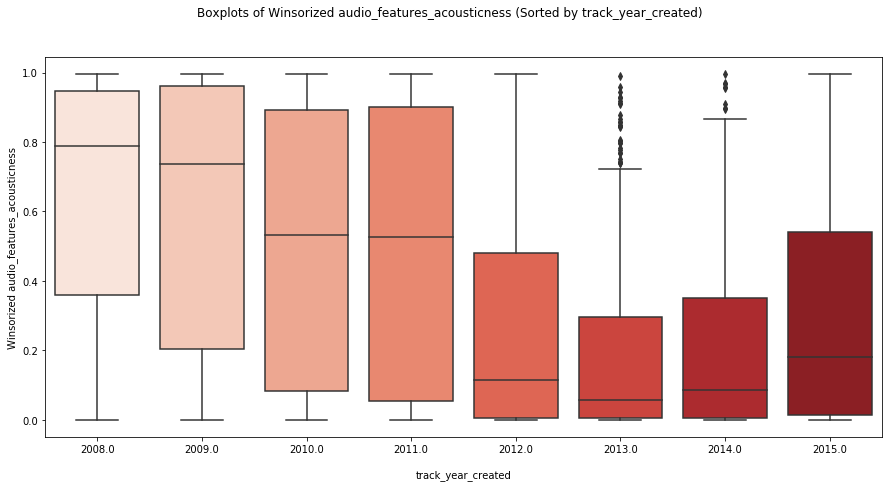

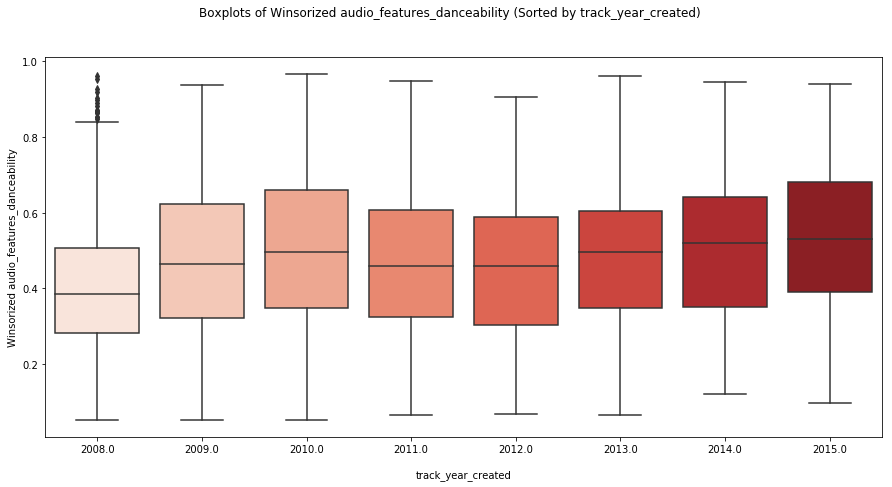

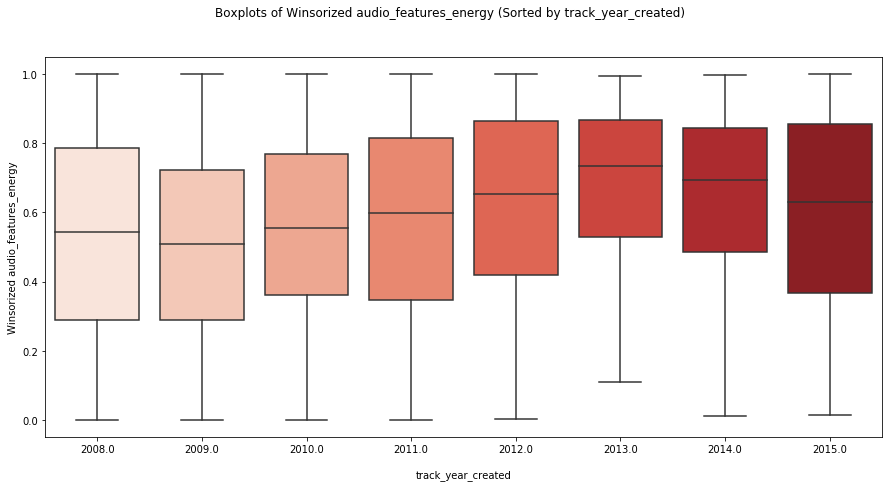

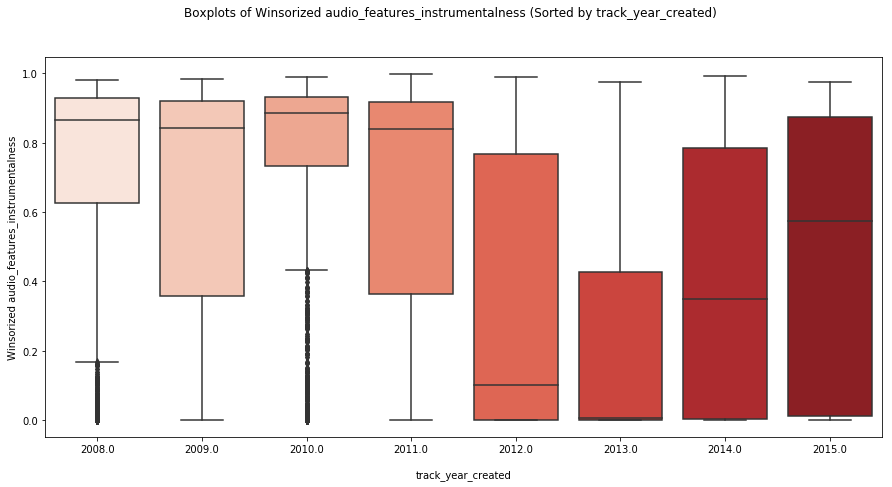

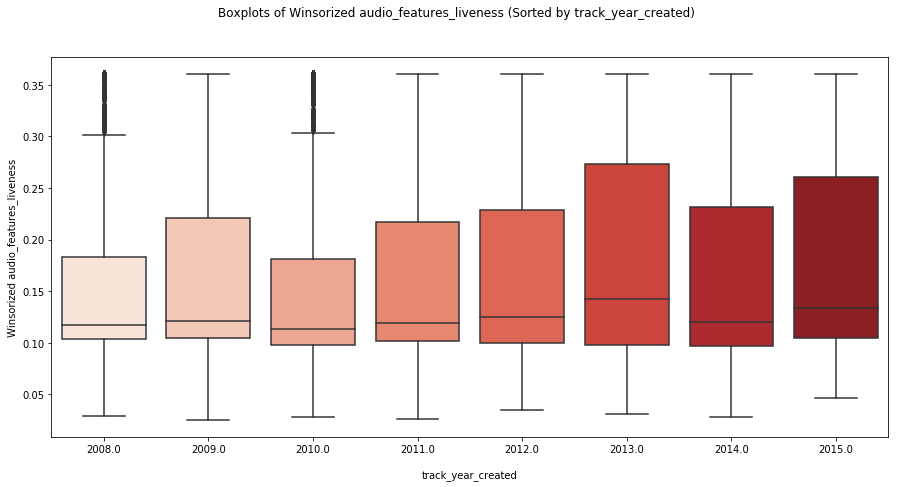

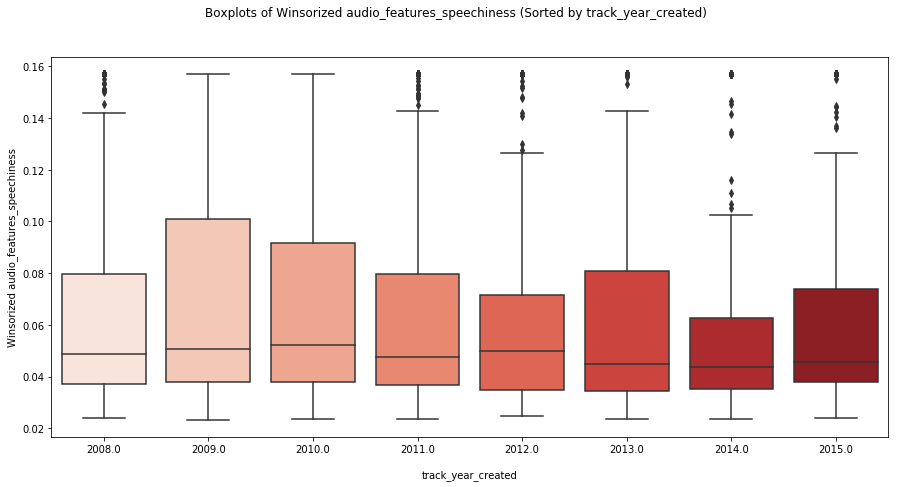

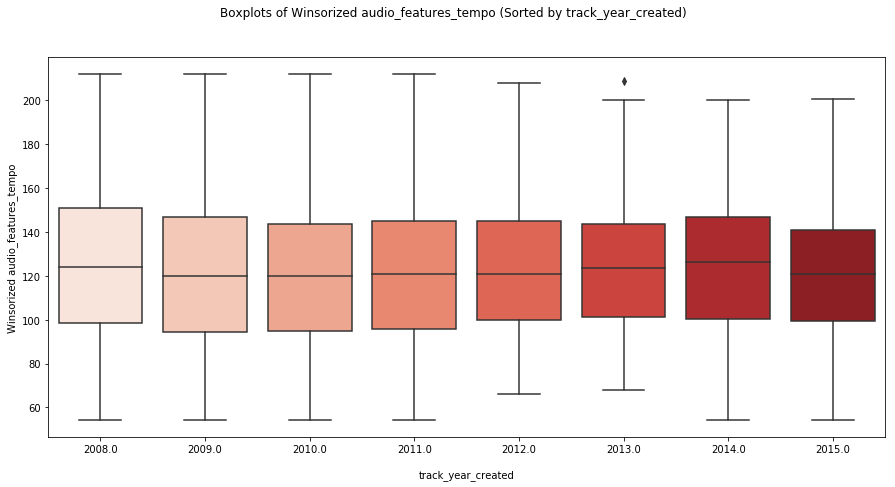

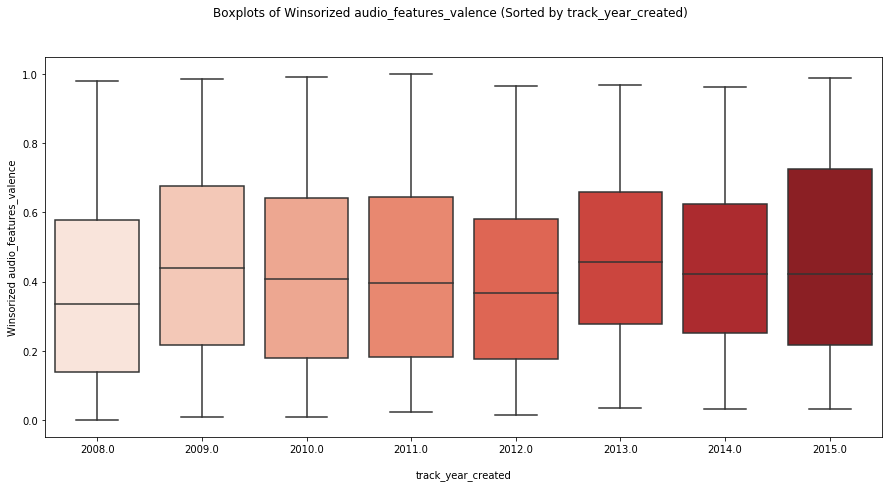

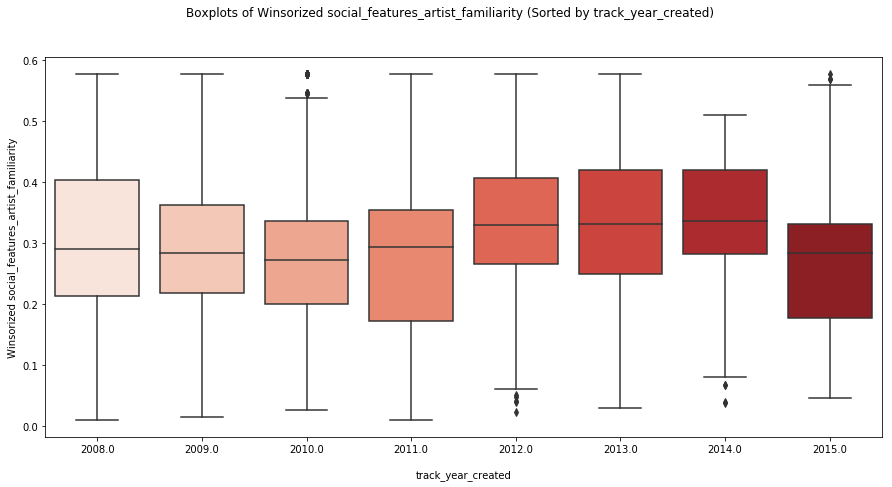

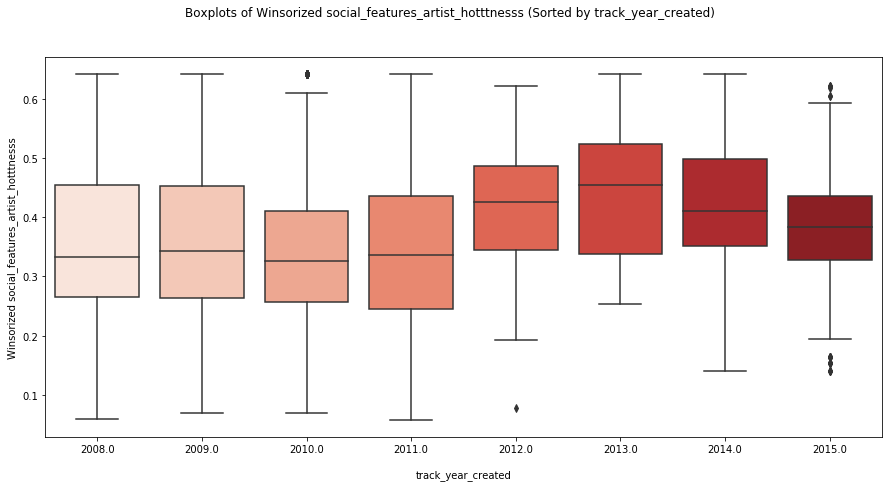

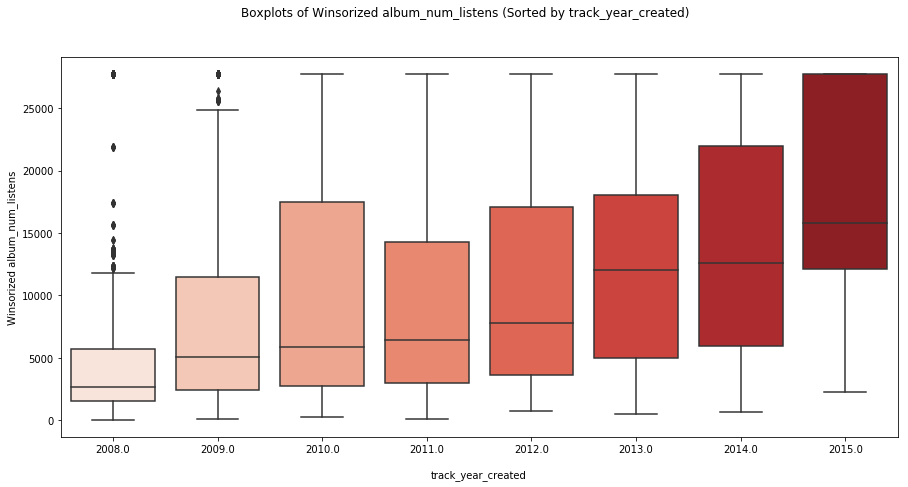

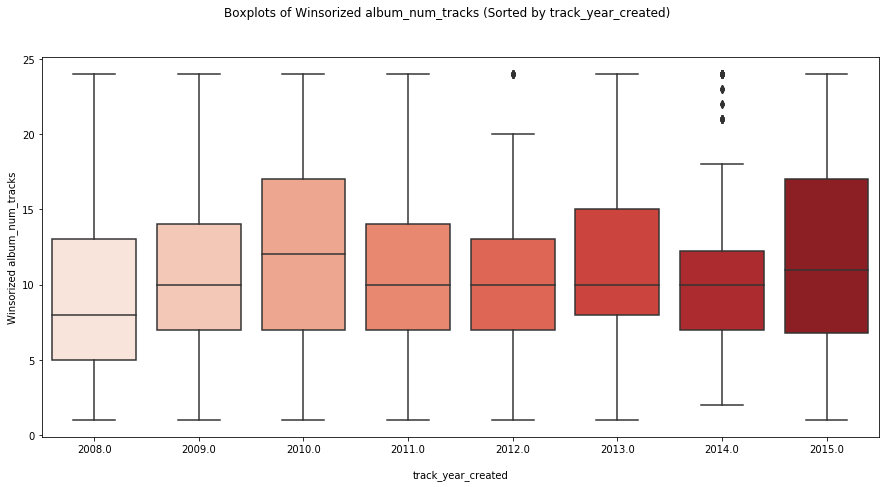

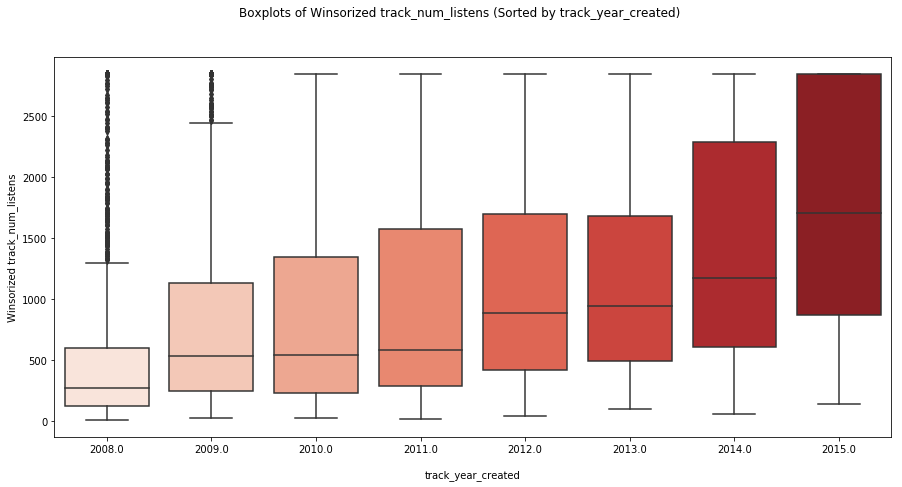

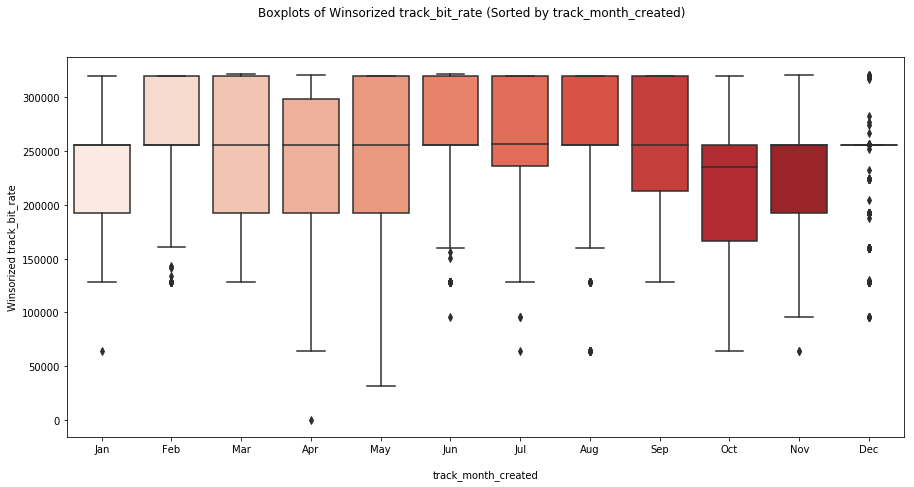

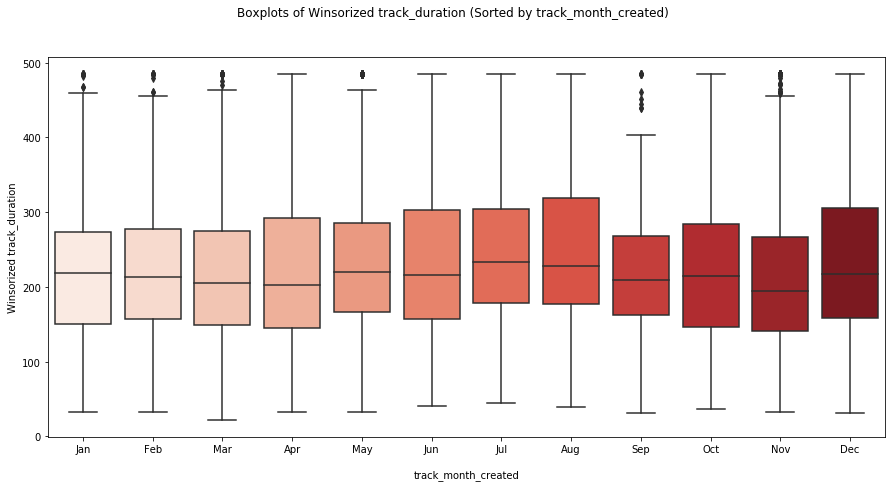

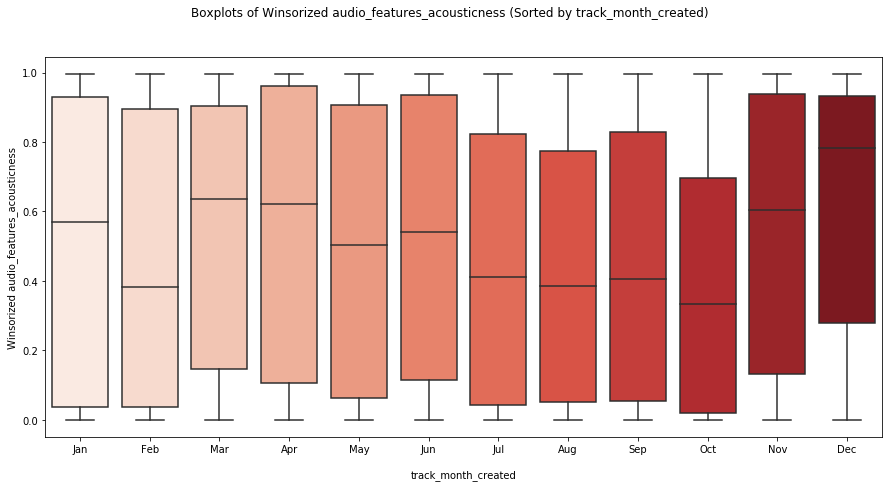

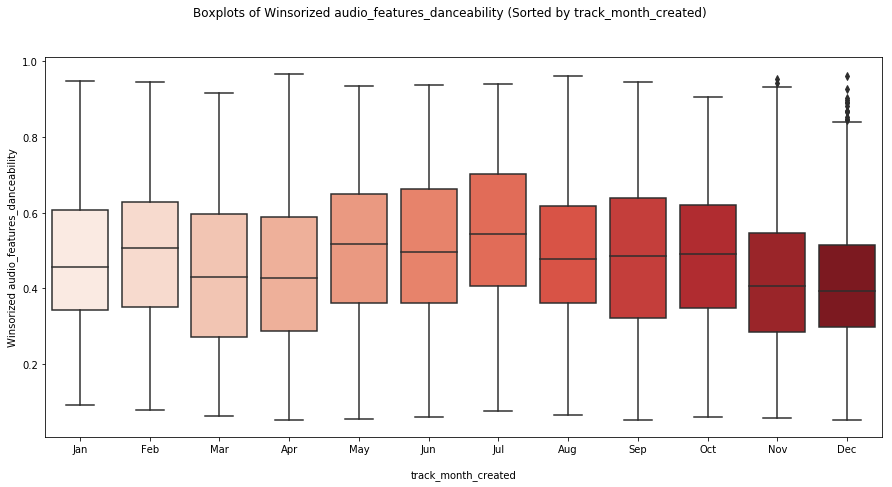

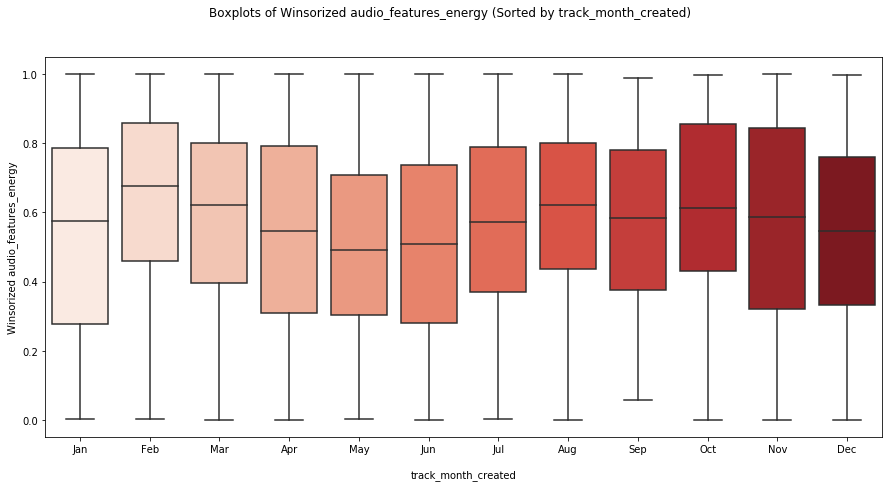

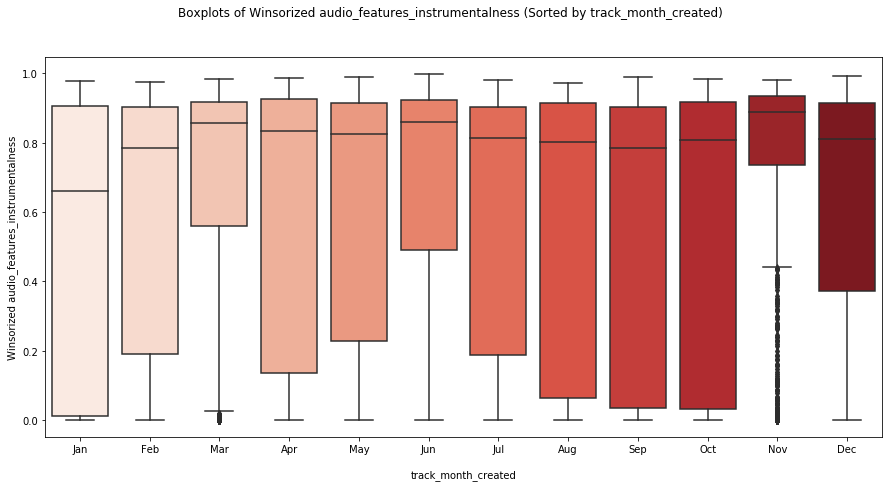

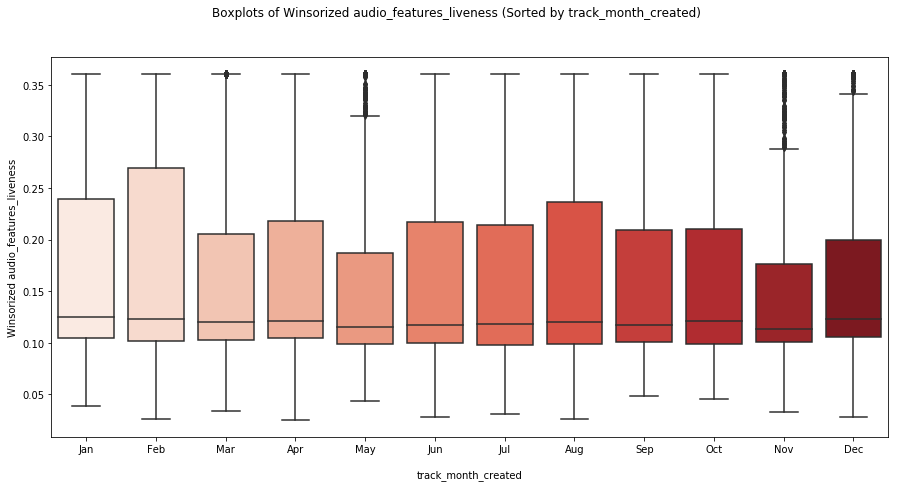

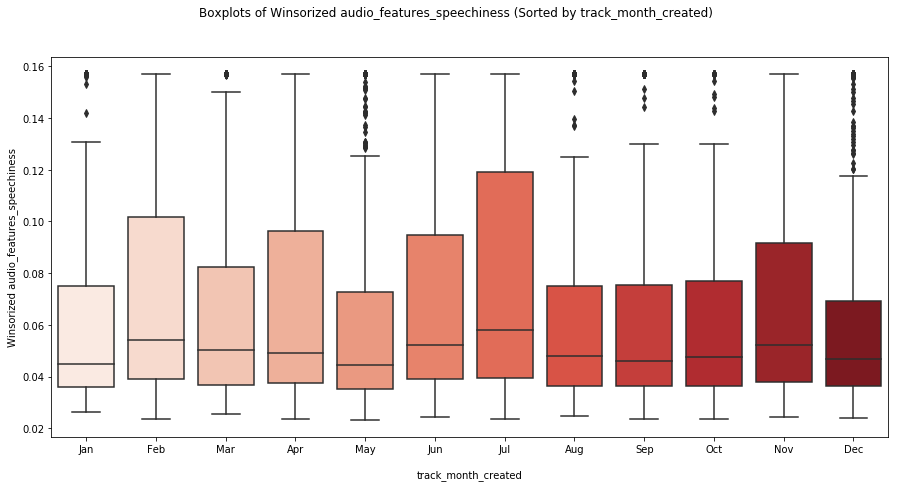

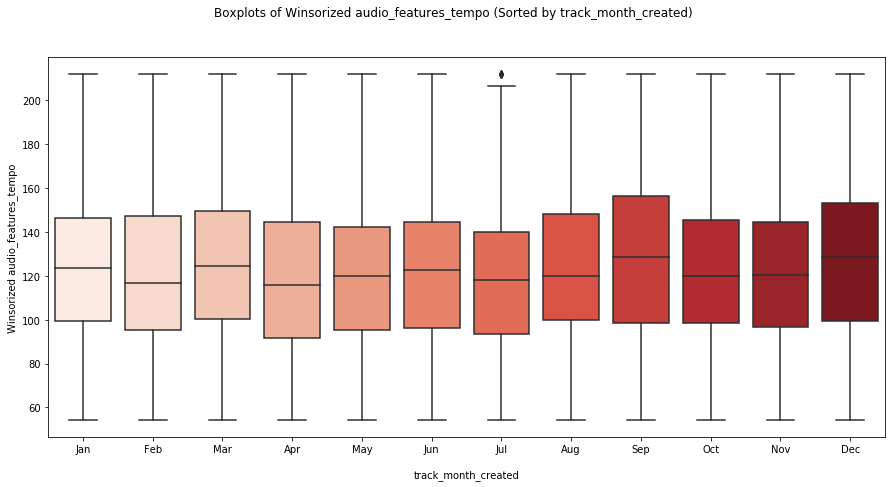

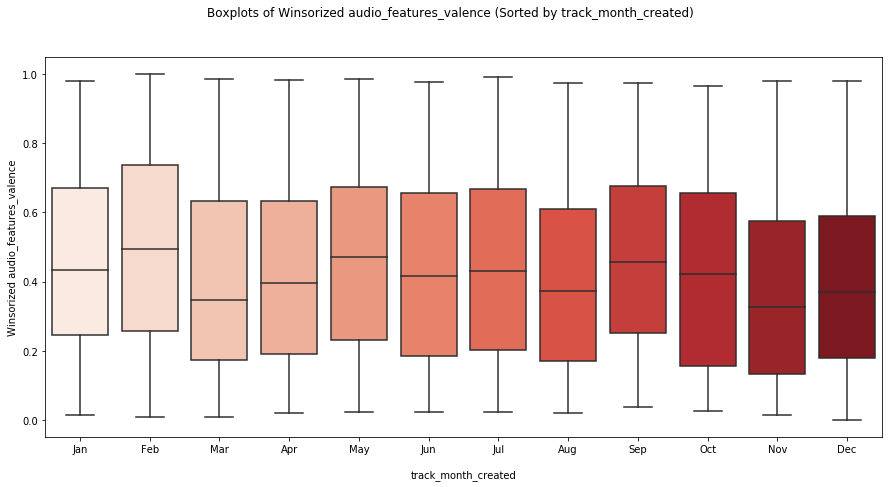

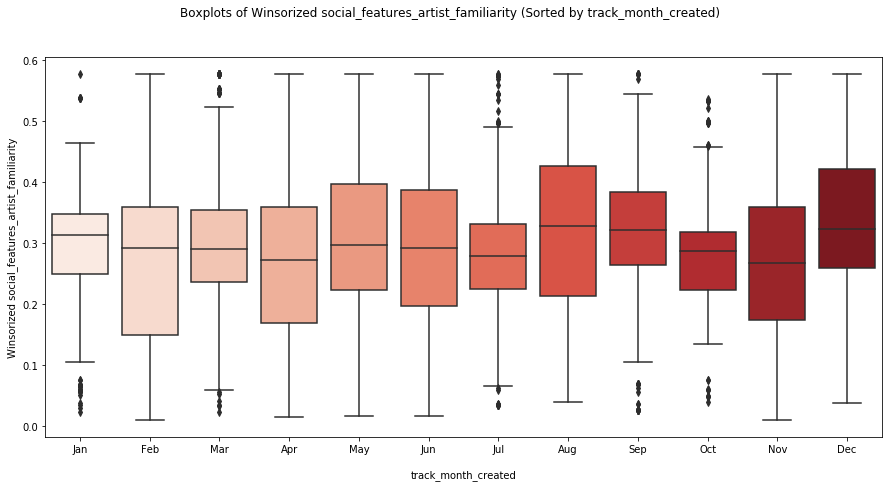

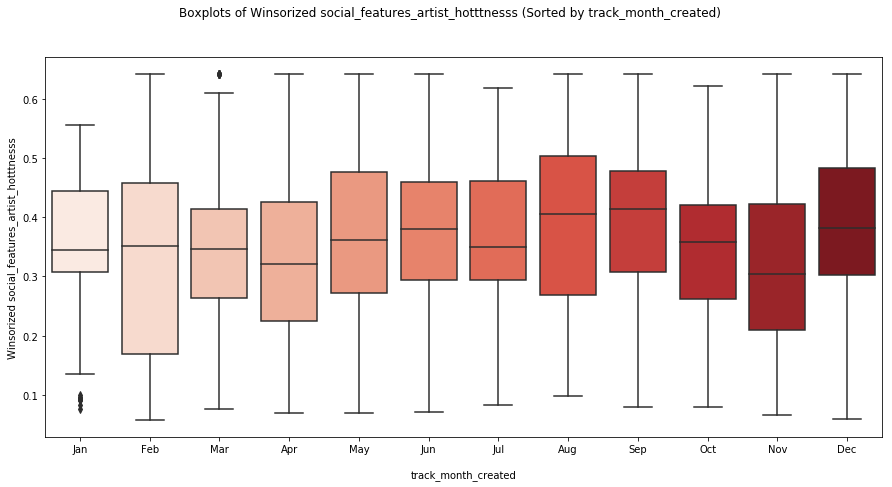

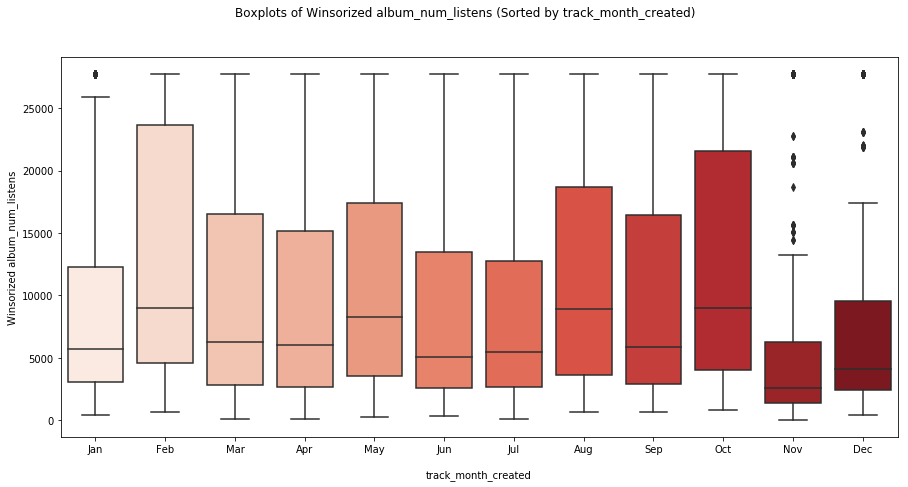

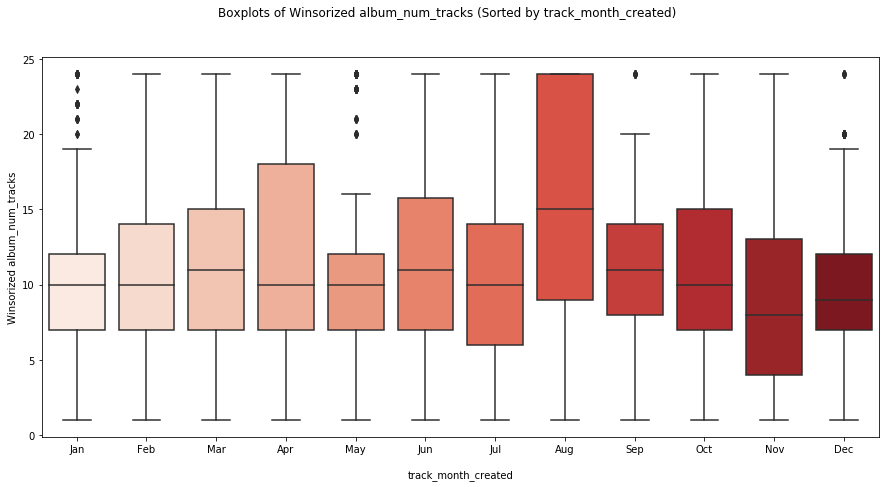

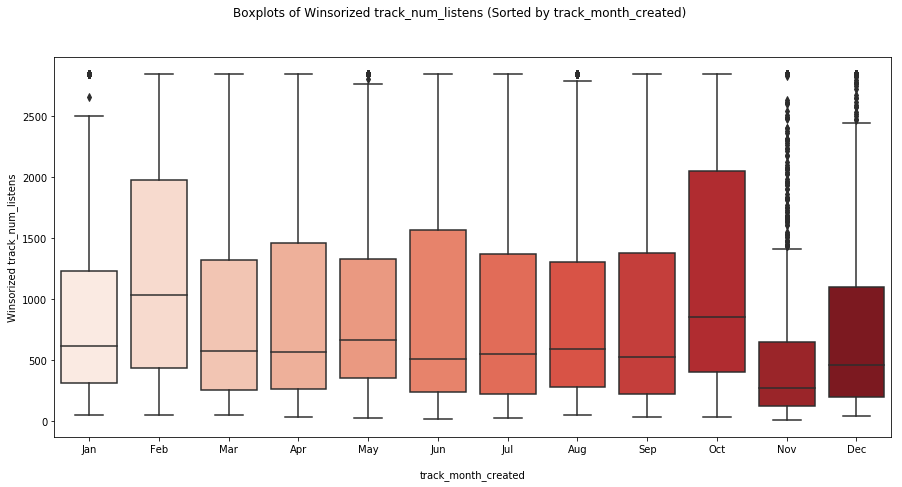

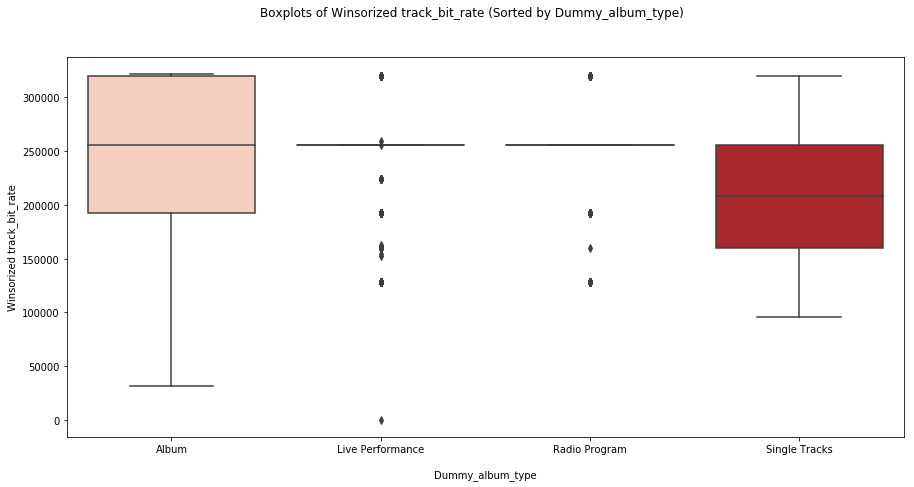

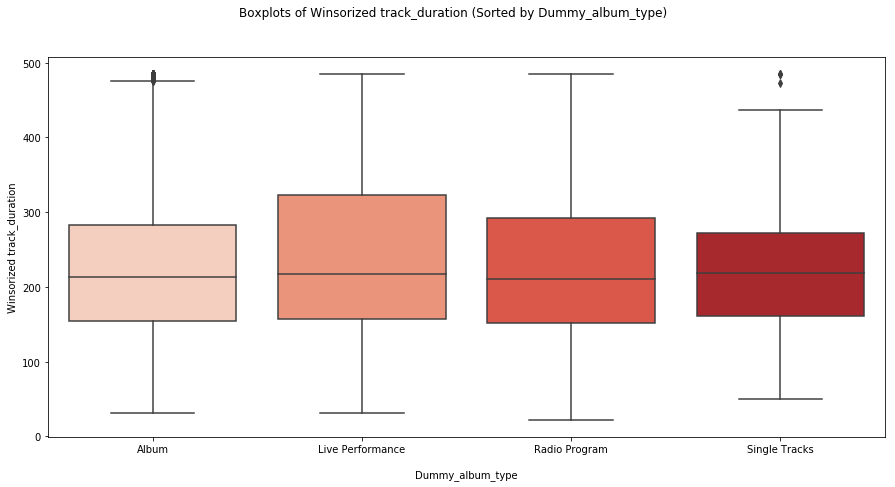

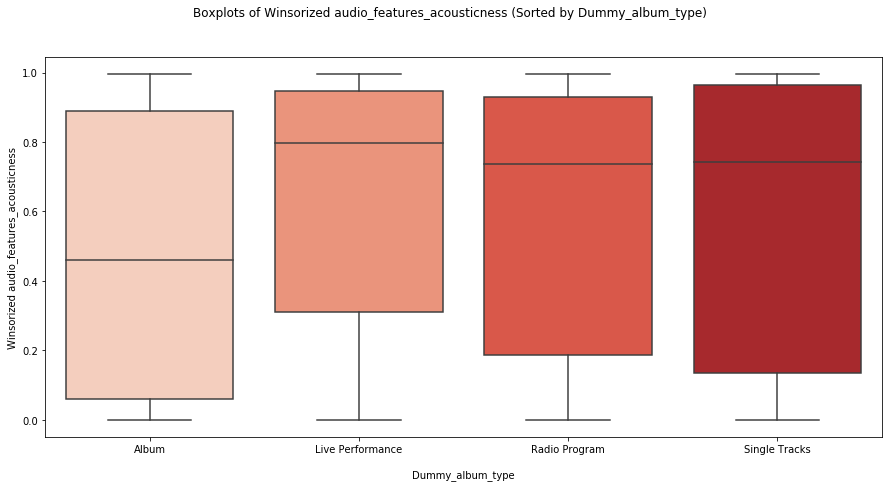

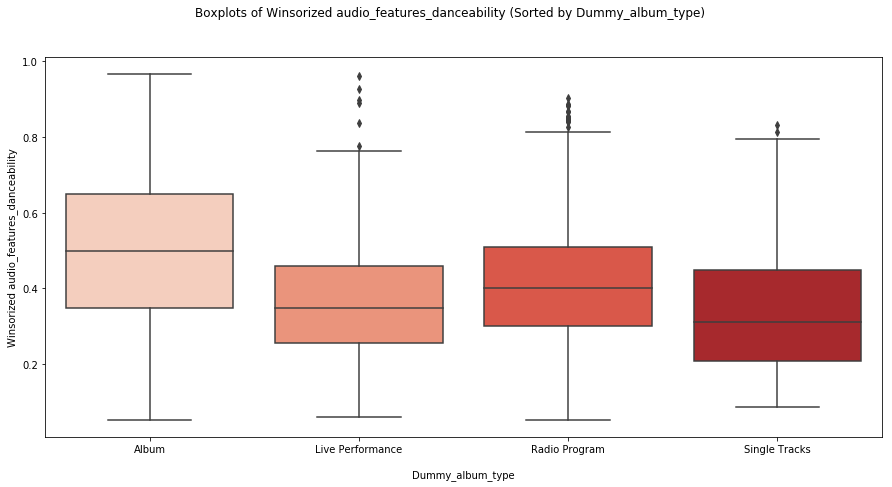

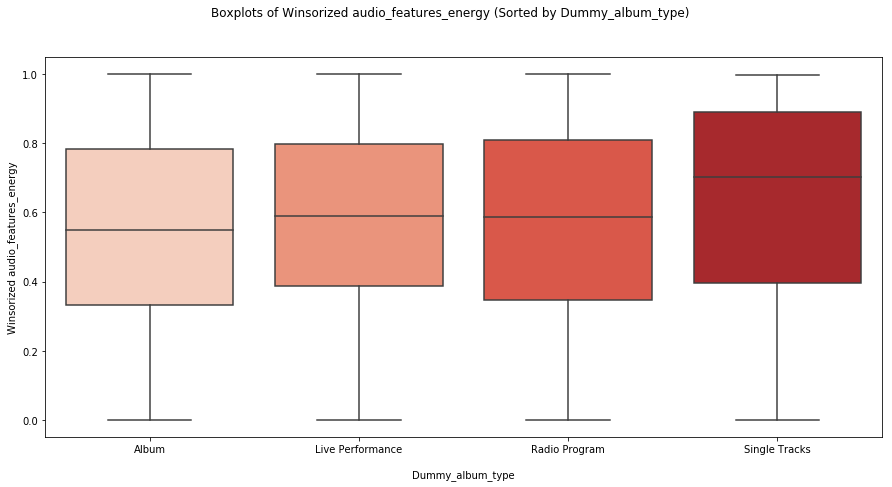

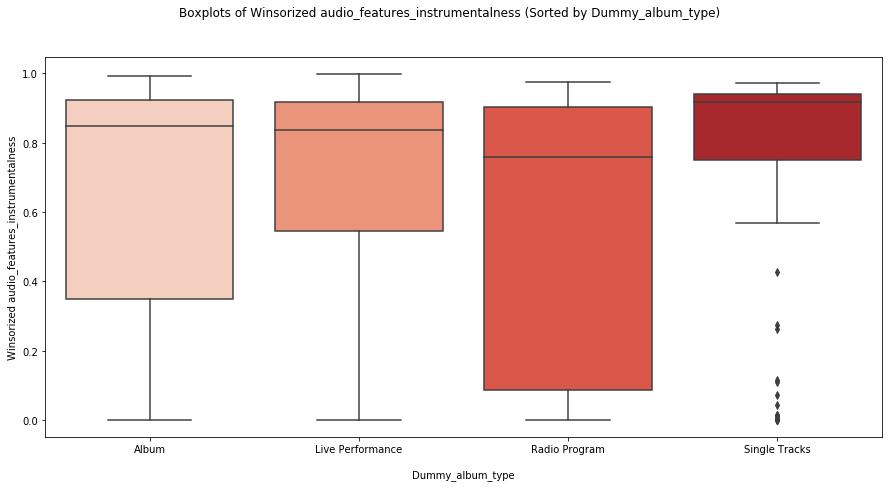

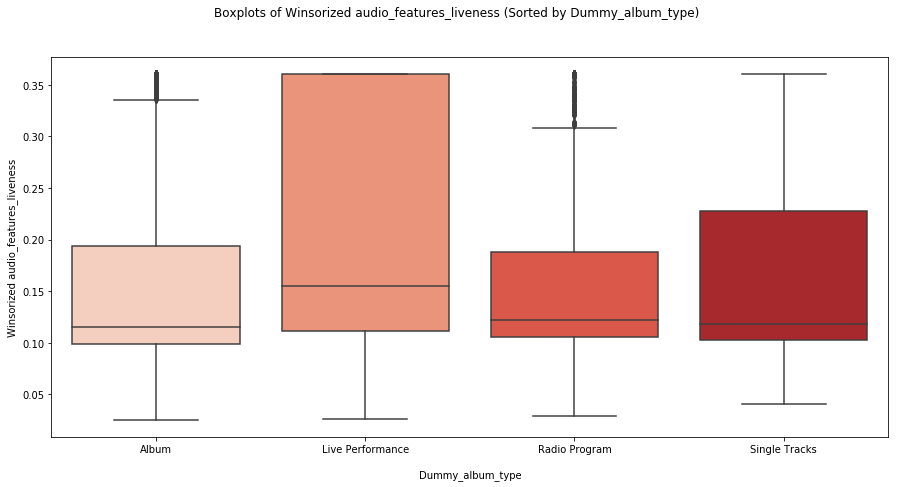

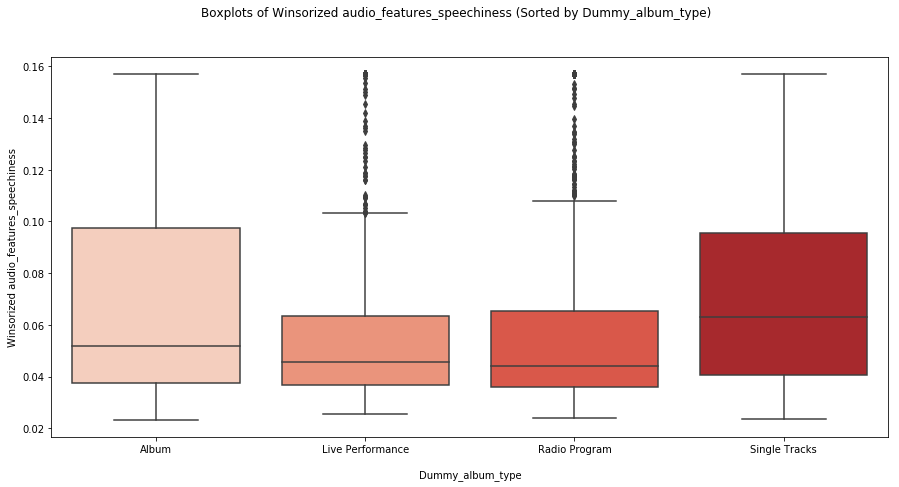

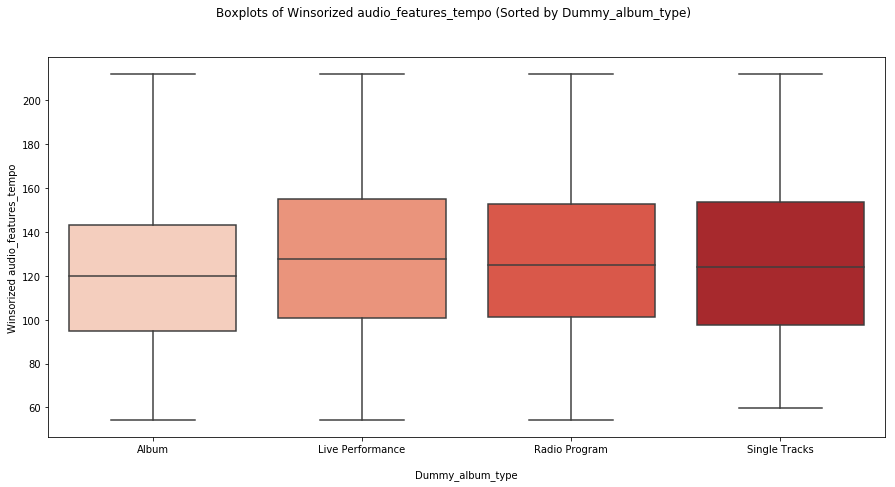

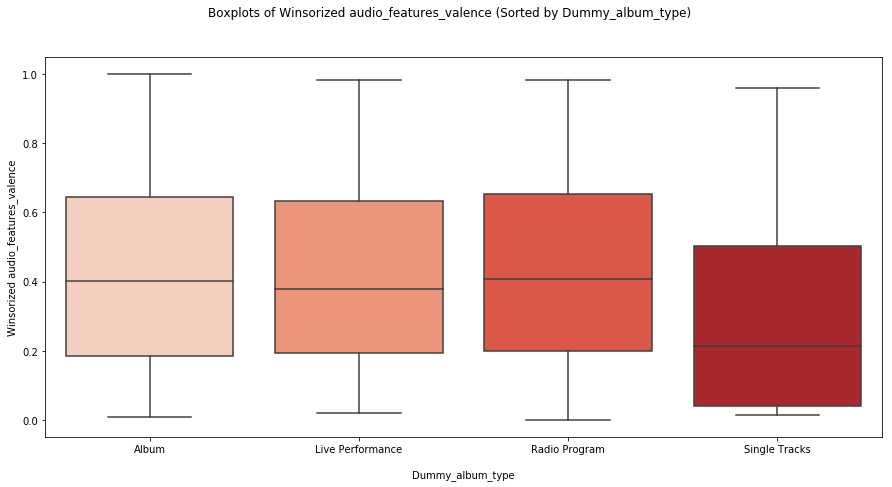

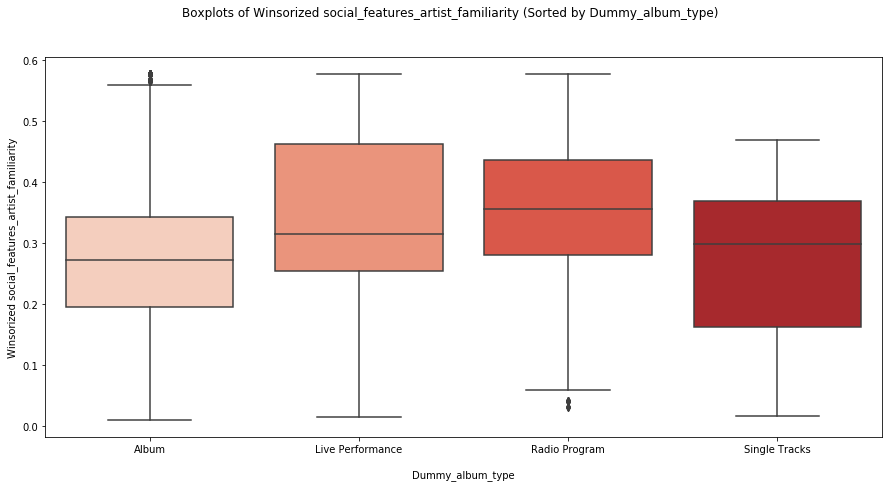

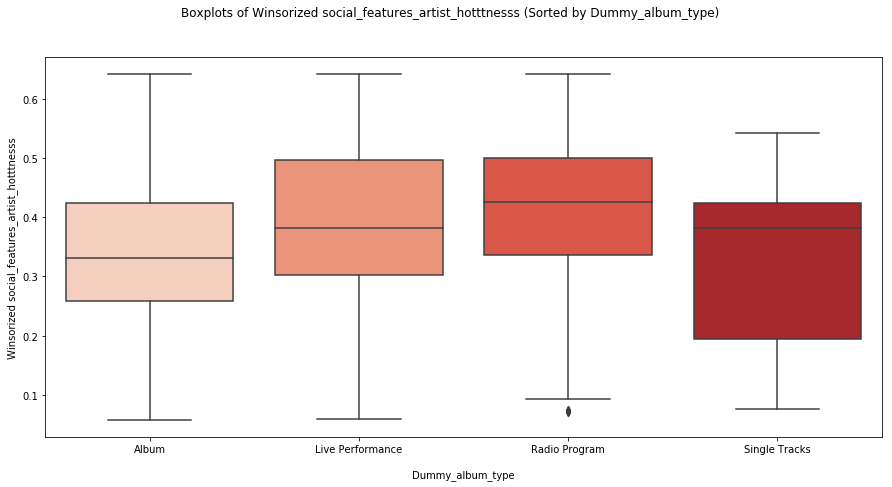

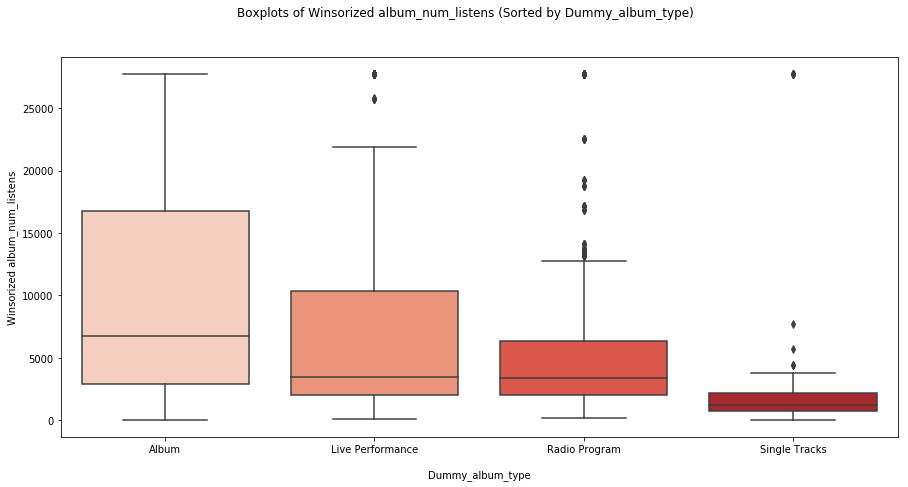

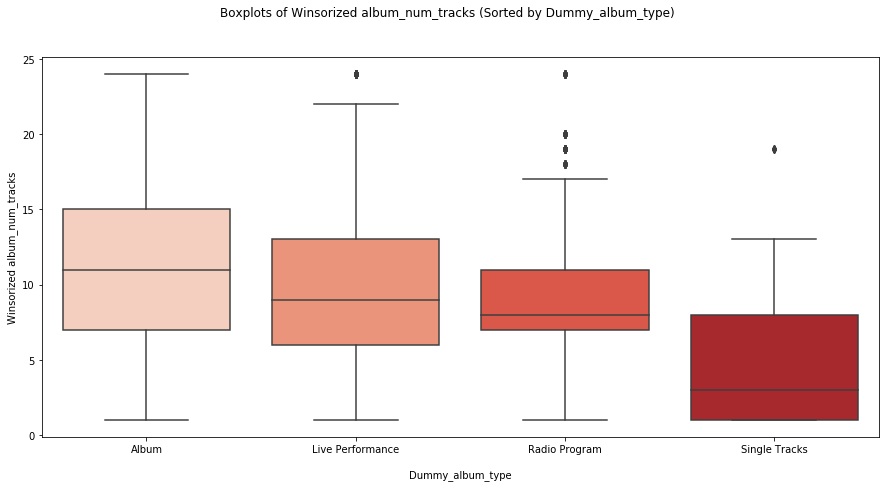

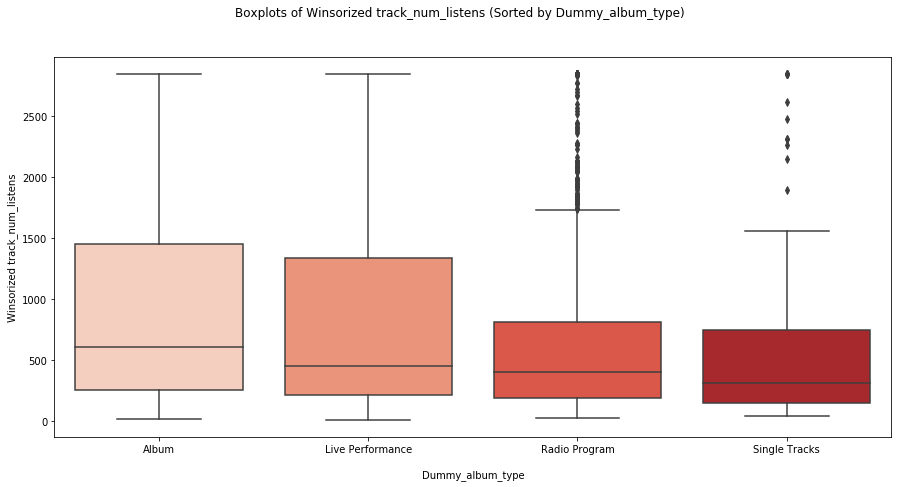

In [594]:
#Boxplot Distributions of Continuous Variables by Categoricals
win_conts = music_new.columns.drop(cat_cols).drop(str_cat_cols).drop(bin_cat_cols)
xax_labs = [unique_years, unique_months, unique_type]

for i in range(len(cat_cols[:-2])):
    for col in win_conts:
        plt.figure(figsize=(15, 7))
        ax = sns.boxplot(x=cat_cols[i], y=col, data=music_new, palette='Reds', order = np.unique(music_new[cat_cols[i]]))
        plt.xlabel('\n' + cat_cols[i])
        lab = [item.get_text() for item in ax.get_xticklabels()]
        lab = [int(item.split('.')[0]) for item in lab]
        ax.set_xticklabels([xax_labs[i][ind - min(lab)] for ind in lab], rotation=0)

        plt.suptitle('Boxplots of ' + col + ' (Sorted by ' + cat_cols[i] + ')')
        plt.show()
        print('\n')

Interestingly, we can see that `audio_features_danceability`, `audio_features_energy`, `audio_features_liveness`, `album_num_listens`, and `track_num_listens` generally tended to increase over the years. This may indicate that those features (danceability, energy, and liveness) were more common in recent years, and may indicate that recent songs were more popular than older songs. With regard to the num_listens features, it is more likely, however, that it is more an issue of the ability of Echonest to record listening data in the years before such technology was widely available. 

In [871]:
bin_cat_cols[4:16]

['track_month_created_1.0',
 'track_month_created_2.0',
 'track_month_created_3.0',
 'track_month_created_4.0',
 'track_month_created_5.0',
 'track_month_created_6.0',
 'track_month_created_7.0',
 'track_month_created_8.0',
 'track_month_created_9.0',
 'track_month_created_10.0',
 'track_month_created_11.0',
 'track_month_created_12.0']

## Feature Engineering
Here, we develop more specific date features by combining the unique months and years, and we also create other new features including `popularity`, `excitement`, etc. by combining already-existing features. In this manner, our model will hopefully be able to cluster more successfully and score higher with respect to its cluster delineations.

In [873]:
bin_months = bin_cat_cols[4:16]
bin_years = bin_cat_cols[16:]

for month in bin_months:
    for year in bin_years:
        music_new['date' + month.split('track_month_created')[1].split('.0')[0] + year.split('track_year_created')[1].split('.0')[0]] = music_new[month]*music_new[year]

In [874]:
music_new['num_beats'] = music_new['Winsorized track_duration']*music_new['Winsorized audio_features_tempo']
music_new['acousticness_instrumentalness'] = music_new['Winsorized audio_features_acousticness']*music_new['Winsorized audio_features_instrumentalness']
music_new['popularity'] = music_new['Winsorized social_features_artist_familiarity']*music_new['Winsorized social_features_artist_hotttnesss']
music_new['excitement'] = music_new['Winsorized audio_features_danceability']*music_new['Winsorized audio_features_energy']*music_new['Winsorized audio_features_tempo']
music_new['speediness'] = music_new['Winsorized track_bit_rate']*music_new['Winsorized audio_features_tempo']


In [875]:
#album_num_tracks doesn't provide useful information, and one of the binary dummies for album_type can be removed while still retaining the same information
music_new = music_new.drop(['Winsorized album_num_tracks', 'album_type_Single Tracks'], axis=1)

In [876]:
list(music_new.columns)

['Winsorized track_bit_rate',
 'Winsorized track_duration',
 'Winsorized audio_features_acousticness',
 'Winsorized audio_features_danceability',
 'Winsorized audio_features_energy',
 'Winsorized audio_features_instrumentalness',
 'Winsorized audio_features_liveness',
 'Winsorized audio_features_speechiness',
 'Winsorized audio_features_tempo',
 'Winsorized audio_features_valence',
 'Winsorized social_features_artist_familiarity',
 'Winsorized social_features_artist_hotttnesss',
 'Winsorized album_num_listens',
 'Winsorized track_num_listens',
 'album_type',
 'artist_name',
 'track_genre_top',
 'track_year_created',
 'track_month_created',
 'Dummy_album_type',
 'Dummy_artist_name',
 'Dummy_genre_top',
 'album_type_Album',
 'album_type_Live Performance',
 'album_type_Radio Program',
 'track_month_created_1.0',
 'track_month_created_2.0',
 'track_month_created_3.0',
 'track_month_created_4.0',
 'track_month_created_5.0',
 'track_month_created_6.0',
 'track_month_created_7.0',
 'track_mon

In [1170]:
music_new, str_cat_cols, bin_cat_cols, cat_cols, cont_cols = catSorting(music_new)

String Categorical Features: 
 ['album_type', 'artist_name', 'track_genre_top']

Binary Dummy Categorical Features: 
 ['album_type_Album', 'album_type_Live Performance', 'album_type_Radio Program', 'track_month_created_1.0', 'track_month_created_2.0', 'track_month_created_3.0', 'track_month_created_4.0', 'track_month_created_5.0', 'track_month_created_6.0', 'track_month_created_7.0', 'track_month_created_8.0', 'track_month_created_9.0', 'track_month_created_10.0', 'track_month_created_11.0', 'track_month_created_12.0', 'track_year_created_2008.0', 'track_year_created_2009.0', 'track_year_created_2010.0', 'track_year_created_2011.0', 'track_year_created_2012.0', 'track_year_created_2013.0', 'track_year_created_2014.0', 'track_year_created_2015.0', 'date_1_2009', 'date_1_2011', 'date_1_2012', 'date_1_2013', 'date_1_2014', 'date_1_2015', 'date_2_2009', 'date_2_2011', 'date_2_2012', 'date_2_2013', 'date_2_2014', 'date_2_2015', 'date_3_2009', 'date_3_2010', 'date_3_2011', 'date_3_2012', 'da

## Create training dataset

In [881]:
X = music_new[music_new.columns.drop(str_cat_cols).drop(cat_cols)]
y = np.array(music_new['Dummy_genre_top'])  #target set is only for validation, not modeling

In [882]:
X.columns

Index(['Winsorized track_bit_rate', 'Winsorized track_duration',
       'Winsorized audio_features_acousticness',
       'Winsorized audio_features_danceability',
       'Winsorized audio_features_energy',
       'Winsorized audio_features_instrumentalness',
       'Winsorized audio_features_liveness',
       'Winsorized audio_features_speechiness',
       'Winsorized audio_features_tempo', 'Winsorized audio_features_valence',
       ...
       'date_12_2010', 'date_12_2011', 'date_12_2012', 'date_12_2013',
       'date_12_2014', 'num_beats', 'acousticness_instrumentalness',
       'popularity', 'excitement', 'speediness'],
      dtype='object', length=118)

## Min-Max Scale the Dataset, Fix Column Names

In [884]:
#Normalize data
X_std2 = pd.DataFrame()

for cat in cont_cols:
    normed = []
    xmax = music_new[cat].max()
    xmin = music_new[cat].min()
    for item in music_new[cat]:
        normed.append((item-xmin)/(xmax-xmin))

    X_std2[cat.split('Winsorized ')[-1]] = normed

for col in bin_cat_cols:
    X_std2[col] = music_new[col]

In [886]:
unique_y = list(np.unique(y))

In [1174]:
X_std2, str_cat_cols2, bin_cat_cols2, cat_cols2, cont_cols2 = catSorting(X_std2)

String Categorical Features: 
 []

Binary Dummy Categorical Features: 
 ['album_type_Album', 'album_type_Live Performance', 'album_type_Radio Program', 'track_month_created_1.0', 'track_month_created_2.0', 'track_month_created_3.0', 'track_month_created_4.0', 'track_month_created_5.0', 'track_month_created_6.0', 'track_month_created_7.0', 'track_month_created_8.0', 'track_month_created_9.0', 'track_month_created_10.0', 'track_month_created_11.0', 'track_month_created_12.0', 'track_year_created_2008.0', 'track_year_created_2009.0', 'track_year_created_2010.0', 'track_year_created_2011.0', 'track_year_created_2012.0', 'track_year_created_2013.0', 'track_year_created_2014.0', 'track_year_created_2015.0', 'date_1_2009', 'date_1_2011', 'date_1_2012', 'date_1_2013', 'date_1_2014', 'date_1_2015', 'date_2_2009', 'date_2_2011', 'date_2_2012', 'date_2_2013', 'date_2_2014', 'date_2_2015', 'date_3_2009', 'date_3_2010', 'date_3_2011', 'date_3_2012', 'date_3_2013', 'date_3_2014', 'date_3_2015', 'dat

## Feature Similarities Visualization

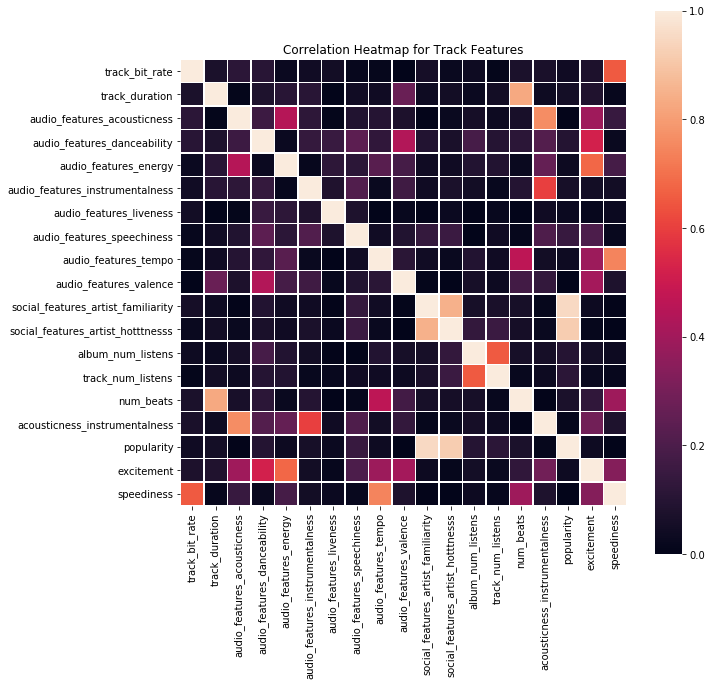

In [889]:
#Compare feature similarities 
#Compare the numerical continuous variables and their correlations via a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(abs(X_std2[cont_cols2].corr()), square=True, linewidths=.5, annot=False)
plt.title('Correlation Heatmap for Track Features')
plt.show()

As we might expect, `social_features_artist_familiarity` and `social_features_artist_hotttnesss` have a high degree of correlation with each other and `popularity`, so we may eventually have to remove one or more of those features to optimize the dataset. Similarly, the newly engineered features are correlated to the features from which they were generated.

## Define Clustering and Analysis Functions
Creating these functions will make the rest of this project simpler, in that we'll only need to call the functions instead of reqriting a long block of code for each dimensionally reduced version of the dataset.

In [1131]:
from sklearn.cluster import KMeans
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = metrics.silhouette_score(data, predictions)
    return silhouette_avg

In [1130]:
from scipy.spatial.distance import cdist
def ElbowPlot(reduced_data, reduction_type_str):
    plt.figure()
    plt.title('Dataset')
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
    plt.show()

    # create new plot and data
    plt.plot()
    X = np.array(list(zip(reduced_data[:, 0], reduced_data[:, 1]))).reshape(len(reduced_data[:, 0]), 2)
    colors = ['b', 'g', 'r']
    markers = ['o', 'v', 's']

    # k means determine k
    distortions = []
    K = range(1,20)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Finding the Optimal k-value of the {}-Reduced Dataset'.format(reduction_type_str))
    plt.show()
    
    return X    #return array version of the reduced_data df

In [1181]:
def max_sil_plot(X, reduction_type_str):
    possible_k_values = range(2, 50, 2)

    # Calculate error values for all k values we're interested in
    errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

    # Plot the each value of K vs. the silhouette score at that value
    fig, ax = plt.subplots(figsize=(16, 6))
    plt.plot(possible_k_values, errors_per_k)

    # Ticks and grid
    xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 2.0)
    ax.set_xticks(xticks, minor=False)
    ax.set_xticks(xticks, minor=True)
    ax.xaxis.grid(True, which='both')
    yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
    ax.set_yticks(yticks, minor=False)
    ax.set_yticks(yticks, minor=True)
    ax.yaxis.grid(True, which='both')
    plt.ylabel('Silhouette Score')
    plt.title('Optimal k-value for Maximized Silhouette Score of the {}-Reduced Dataset\n'.format(reduction_type_str))
    plt.show()
    
    return (errors_per_k.index(max(errors_per_k))+1)*2   #return k-value at which highest silhouette score is found

In [1178]:
def colorList(n_clusters):
    from matplotlib.colors import ListedColormap
    import matplotlib.cm as mplcm
    import matplotlib.colors as colors
    NUM_COLORS = n_clusters

    cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    cmp = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]
    
    return cmp    #returns cmap of colors of inputted length, based on number of plotted clusters

In [1192]:
#Produces plots of two-component reduced dataset, one colored by the original target labels,
#the other colored by KMean-generated cluster labels. Also produces ARI and Silhouette Score

def KMeansPlot(n_clust, reduced_data, target, cmp1, cmp2, reduction_type_str, unique_gen):
    k_means = KMeans(n_clusters=n_clust, random_state=123)
    %timeit k_means.fit(reduced_data)
    y_pred = k_means.predict(reduced_data)

    unique_pred = np.unique(y_pred)

    # Plot the solution.
    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    for i in unique_pred:
        ax.scatter(pd.DataFrame(reduced_data)[y_pred==i][0], pd.DataFrame(reduced_data)[y_pred==i][1], color = cmp2[i], label='Class '+ str(i))

    plt.title('KMean Clustering solution for {}-Reduced Dataset'.format(reduction_type_str))

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    
    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    for i in list(pd.Series(target).value_counts().index):
        ax.scatter(pd.DataFrame(reduced_data)[target==i][0], pd.DataFrame(reduced_data)[target==i][1], color = cmp1[i], label=unique_gen[i])

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Original Class Labels for {}-Reduced Dataset'.format(reduction_type_str))
    plt.show()

    print("Adjusted Rand Index of the KMean Clustering solution on {}-Reduced Dataset: {}"
              .format(reduction_type_str, metrics.adjusted_rand_score(target, y_pred)))
    print("Silhoutte Score of the KMean Clustering solution on {}-Reduced Dataset: {}".format(reduction_type_str, metrics.silhouette_score(reduced_data, y_pred)))

In [1209]:
#Produces plot of two-component reduced dataset, colored by the MiniBatch KMean-generated labels
#Prints Silhouette Score of clustering model

from sklearn.cluster import MiniBatchKMeans
def MiniBatchKMeansPlot(n_clust, reduced_data, cmp, reduction_type_str):
    # Defining the mini-batch k-means
    minikmeans_cluster = MiniBatchKMeans(
        init='random',
        n_clusters=n_clust,
        batch_size=50)

    # Fit model
    %timeit minikmeans_cluster.fit(reduced_data)
    minikmeans_cluster = minikmeans_cluster.predict(reduced_data)

    # Plot the solution.
    unique_clus = list(np.unique(minikmeans_cluster))

    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    for i in unique_clus:
        ax.scatter(pd.DataFrame(reduced_data)[minikmeans_cluster==i][0], pd.DataFrame(reduced_data)[minikmeans_cluster==i][1], color = cmp[i], label='Class '+ str(i))

    plt.title('MiniBatch KMean Clustering solution on {}-Reduced Dataset'.format(reduction_type_str))

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    print("Silhoutte Score of the MiniBatchKMean Clustering solution on {}-Reduced Dataset: {}".format(reduction_type_str, metrics.silhouette_score(reduced_data, minikmeans_cluster)))

In [1144]:
#Splits the dataset and two-component reduced dataset into four equal sub-samples
#Allows us to analyze if a model is reproducable for all data in the set
from sklearn.model_selection import train_test_split
def FourWaySplit(data, reduced_data):
    # Split the data into two equally-sized samples. 
    X_half1, X_half2, X_reducedhalf1, X_reducedhalf2 = train_test_split(data[:len(data)-1], reduced_data[:len(reduced_data)-1], test_size=0.5, random_state=42)

    # Then halve the halves.
    X1, X2, X_reduced1, X_reduced2 = train_test_split(X_half1, X_reducedhalf1, test_size=0.5, random_state=42)
    X3, X4, X_reduced3, X_reduced4 = train_test_split(X_half2, X_reducedhalf2, test_size=0.5, random_state=42)

    # Make them all equal sizes
    if len(X1) < len(X2):
        X2 = X2[:len(X1)][:]
        X_reduced2 = X_reduced2[:len(X_reduced1)][:]
    else:
        X1 = X1[:len(X2)][:]
        X_reduced1 = X_reduced1[:len(X_reduced2)][:]

    if len(X3) < len(X4):
        X4 = X4[:len(X3)][:]
        X_reduced4 = X_reduced4[:len(X_reduced3)][:]
    else:
        X3 = X3[:len(X4)][:]
        X_reduced3 = X_reduced3[:len(X_reduced4)][:]

    return X1, X2, X3, X4, X_reduced1, X_reduced2, X_reduced3, X_reduced4

In [1212]:
#Uses KMeans Clustering to see if the sub-samples produce similar clusters, depending on k-value
#Prints Silhouette Score for each sub-sample, using the optimal k-value
def dataSplitComparisons(data_set, reduced_data, n_clusters, reduction_type_str):
    X1, X2, X3, X4, X_reduced1, X_reduced2, X_reduced3, X_reduced4 = FourWaySplit(data_set, reduced_data)

    # Data frame to store features and predicted cluster memberships.
    ypred = pd.DataFrame()
    score = pd.DataFrame(columns=['cluster_pred','sil_score'])

    # Keep track of counts of the models and use data from the different folds
    for counter, data in enumerate([
        (X1, X_reduced1),
        (X2, X_reduced2),
        (X3, X_reduced3),
        (X4, X_reduced4)]):

        # Put the features into ypred.
        ypred['reduced_f1' + '_sample' + str(counter)] = data[1][:, 0]
        ypred['reduced_f2' + '_sample' + str(counter)] = data[1][:, 1]

        # Creating a list of possible number of clusters to test in kmeans.
        for nclust in range(2, 20):

            # Instantiating and fit_predicting model to then add to data frame
            kmeans = KMeans(n_clusters=nclust, random_state=42)
            pred = kmeans.fit_predict(data[0])
            ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

            # Calculating silhouette scores for the data and adding that to the shilouette score
            labels = kmeans.labels_
            sscore = metrics.silhouette_score(data[0], labels, metric='euclidean')
            score = score.append({'cluster_pred':'clust' + str(nclust) + '_sample' + str(counter), 
                                  'silhouette_score':sscore}, ignore_index=True)
            
    # For each  number of clusters, plot the clusters using the
    # reduced features for each sample.
    for cluster in range(2, len(unique_y)+1):

        # Make a grid of subplots.
        f, axarr = plt.subplots(2, 2)

        # Make a plot for each sample.
        for i in range(4):

            # PCA-created features.
            x_sub = ypred['reduced_f1_sample{}'.format(i)]
            y_sub = ypred['reduced_f2_sample{}'.format(i)]

            # Cluster assignments.
            c = ypred['clust{}_sample{}'.format(cluster, i)]

            # Assign the subplot to its place on the grid.
            rows = int(np.floor(i / 2))
            cols = i % 2
            axarr[rows, cols].scatter(x_sub, y_sub, c=c)
            axarr[rows, cols].set_title('sample {}'.format(i))

        # Space out the plots so that the headings don't overlap axis values.
        plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
        plt.tight_layout()
        plt.show()
        print('\n')
        
    print('\nKMean Clustering on {}-Reduced Dataset - Sub-Sample Silhouette Scores for k-value of {}'.format(reduction_type_str,n_clusters))
    i = 1
    for sample in [X1, X2, X3, X4]:
        model = KMeans(n_clusters=n_clusters, random_state=42).fit(sample)
        labels = model.labels_
        print('Sub-Sample #', str(i), ': ', metrics.silhouette_score(sample, labels, metric='euclidean'))
        i = i+1

In [1204]:
#Produces three dendograms, one for each linkage type in ['complete', 'average', 'ward']
from scipy.cluster.hierarchy import dendrogram, linkage
def dendogramPlots(data, reduction_type_str):
    for link in ['complete', 'average', 'ward']:
        plt.figure(figsize=(20,10))
        dendrogram(linkage(data, method=link))
        plt.title('Dendogram - {} - for {}-Reduced Dataset'.format(link, reduction_type_str))
        plt.show()

In [1203]:
#Prints ARI and Silhouette Score for three linkages and affinities of Agglomerative Clustering on the dataset
from sklearn.cluster import AgglomerativeClustering
def aggClustering(data, target, nclust, reduction_type_str):
    affinities = ['cosine', 'cosine', 'euclidean']
    linkages = ['complete', 'average', 'ward']
    for i in range(len(linkages)):
        # Defining the agglomerative clustering
        agg_cluster = AgglomerativeClustering(linkage=linkages[i], 
                                              affinity=affinities[i],
                                              n_clusters=nclust)

        # Fit model
        clusters = agg_cluster.fit_predict(data)

        print("Adjusted Rand Index of the Agglomerative Clustering solution for {}-Reduced Dataset, utilizing the {} method: {}"
              .format(reduction_type_str, linkages[i], metrics.adjusted_rand_score(target, clusters)))
        print("Silhoutte Score of the Agglomerative Clustering solution for {}-Reduced Dataset, utilizing the {} method: {}"
              .format(reduction_type_str, linkages[i], metrics.silhouette_score(data, clusters, metric=affinities[i])))
        print('\n-----------------------------------------------------------------------------------------\n')

In [1202]:
#Produces plot of two-component reduced dataset, colored by Gaussian Mixture Model-generated labels
#Prints ARI and Silhouette Scores for GMM Clustering
from sklearn.mixture import GaussianMixture
def gmmClustering(data, reduced_data, target, nclust, cmp, reduction_type_str):
    # Defining the gmm clustering
    gmm_cluster = GaussianMixture(n_components=nclust, random_state=123)

    # Fit model
    clusters = gmm_cluster.fit_predict(data)

    unique_clust = list(np.unique(clusters))

    # Visualize clusters
    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    for i in unique_clust:
        ax.scatter(pd.DataFrame(reduced_data)[clusters==i][0], pd.DataFrame(reduced_data)[clusters==i][1], color = cmp[i], label='Class '+ str(i))

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('GMM Clustering on {}-Reduced Dataset'.format(reduction_type_str))
    plt.show()

    #Print scores
    print('Adjusted Rand Index for GMM Clustering on {}-Reduced Dataset: {}'.format(reduction_type_str, metrics.adjusted_rand_score(target, clusters)))
    print('Silhouette Score for GMM Clustering on {}-Reduced Dataset: {}'.format(reduction_type_str, metrics.silhouette_score(data, clusters, metric='euclidean')))

In [1219]:
#Same as previous function, but now with four different covariance types: ['full', 'tied', 'diag', 'spherical']
def gmmCovClustering(data, reduced_data, target, nclust, cmp, reduction_type_str):
    for cov in ['full', 'tied', 'diag', 'spherical']:
        # Defining the gmm clustering
        gmm_cluster = GaussianMixture(n_components=nclust, random_state=123, covariance_type = cov)

        # Fit model
        clusters = gmm_cluster.fit_predict(data)

        unique_clust = list(np.unique(clusters))

        # Visualize clusters
        fig = plt.figure(figsize=(10,5))
        ax = plt.subplot(111)
        for i in unique_clust:
            ax.scatter(pd.DataFrame(reduced_data)[clusters==i][0], pd.DataFrame(reduced_data)[clusters==i][1], color = cmp[i], label='Class '+ str(i))

        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('GMM Clustering (Covariance Type = {}) on {}-Reduced Dataset'.format(cov, reduction_type_str))
        plt.show()

        #Print scores
        print('Adjusted Rand Index for GMM Clustering (Covariance Type = {}) on {}-Reduced Dataset: {}'.format(cov, reduction_type_str, metrics.adjusted_rand_score(target, clusters)))
        print('Silhouette Score for GMM (Covariance Type = {}) on {}-Reduced Dataset: {}'.format(cov, reduction_type_str, metrics.silhouette_score(data, clusters, metric='euclidean')))
        print('\n-----------------------------------------------------------------------------------------\n')

## Initial Experimentation: PCA-Reduction and KMean Clustering
First, we drop `social_features_artist_familiarity`, `social_features_artist_hotttnesss`, and `album_num_listens`, as they have too high correlations to other features to be useful in this analysis. Then, the first few functions defined above to see how well our current dataset can be clustered.

In [1179]:
X_std = X_std2[X_std2.columns.drop(['social_features_artist_hotttnesss', 'social_features_artist_familiarity', 'album_num_listens'])]

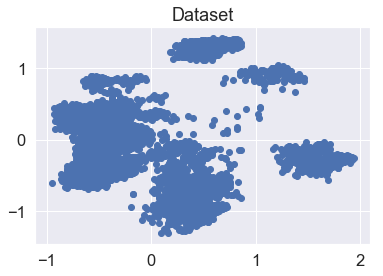

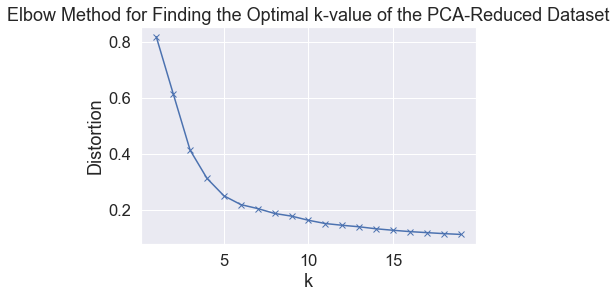

In [1180]:
#PCA transformation
from sklearn.decomposition import PCA
transformer = PCA(n_components=2)
X_pca = transformer.fit_transform(X_std)

X = ElbowPlot(X_pca, 'PCA')

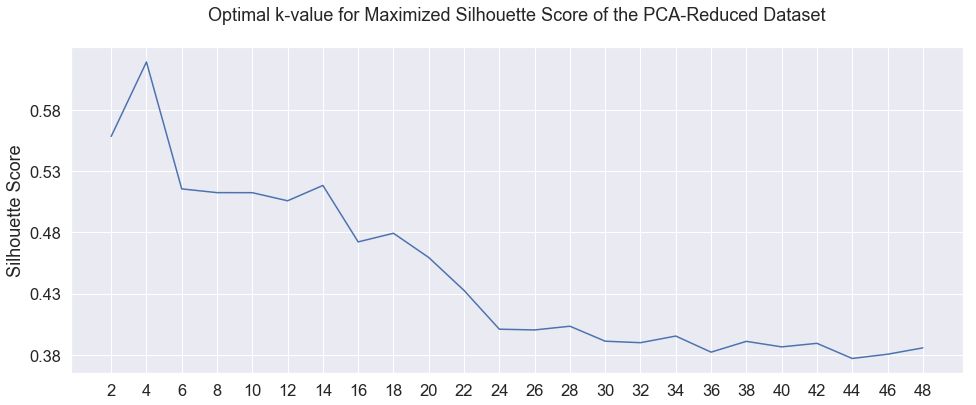

In [1182]:
opt_nclust = max_sil_plot(X, 'PCA')

In [1184]:
cmp1 = colorList(len(unique_y))
cmp_pca = colorList(opt_nclust)

197 ms ± 23.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


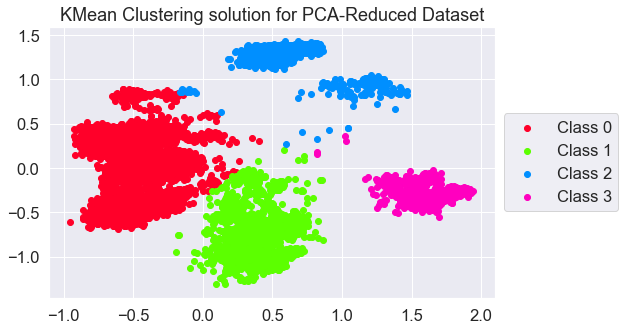

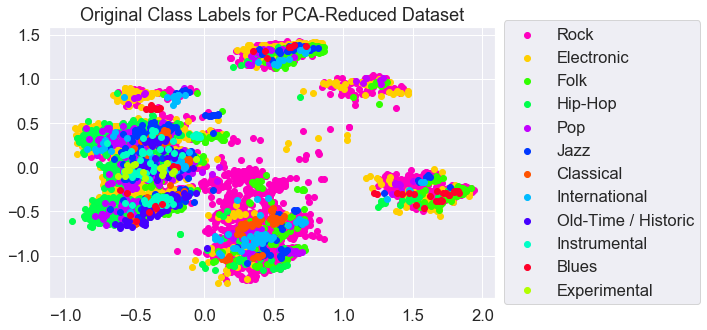

Adjusted Rand Index of the KMean Clustering solution on PCA-Reduced Dataset: -0.033163132292213335
Silhoutte Score of the KMean Clustering solution on PCA-Reduced Dataset: 0.6191338343854353


In [1193]:
KMeansPlot(opt_nclust, X_pca, y, cmp1, cmp_pca, 'PCA', unique_gen)

## Improve the Dataset via Feature Removal
Although the PCA-Reduction of the dataset visually shows a pretty decent separation of four distinct clusters, the Silhouette Score is only 0.619, which is less than optimal. I believe we can improve the clustering by removing some of the less-useful features from the dataset before doing dimensional reduction. However, we first have to figure out which removed features would be most effective.

### Measure Silhouette Score for Each Combination of Features 

In [949]:
for col in [item for item in cont_cols2 if item not in ['social_features_artist_hotttnesss', 'social_features_artist_familiarity', 'album_num_listens']]:
    X_std3 = X_std2[list(set([col] + [item for item in bin_cat_cols if item not in list(set(bin_months + bin_years))]))]
    X_pca = transformer.fit_transform(X_std3)    

    X = np.array(list(zip(X_pca[:, 0], X_pca[:, 1]))).reshape(len(X_pca[:, 0]), 2)

    # Calculate error values for a k value of 4
    kmeans = KMeans(n_clusters=4).fit(X)
    predictions = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, predictions)
    
    print(col, '\nSilhouette Score: ', silhouette_avg)
    print('\n')
    

track_bit_rate 
Silhouette Score:  0.8979877811725716


track_duration 
Silhouette Score:  0.900101503577453


audio_features_acousticness 
Silhouette Score:  0.6178971739811222


audio_features_danceability 
Silhouette Score:  0.8779217590864161


audio_features_energy 
Silhouette Score:  0.9009477462023449


audio_features_instrumentalness 
Silhouette Score:  0.6967038101854917


audio_features_liveness 
Silhouette Score:  0.842049852664782


audio_features_speechiness 
Silhouette Score:  0.8720915312243246


audio_features_tempo 
Silhouette Score:  0.8998600384279684


audio_features_valence 
Silhouette Score:  0.8957933068563556


track_num_listens 
Silhouette Score:  0.8190227357476919


num_beats 
Silhouette Score:  0.9019723785810696


acousticness_instrumentalness 
Silhouette Score:  0.644083055661171


popularity 
Silhouette Score:  0.8867646263169865


excitement 
Silhouette Score:  0.9003456673305207


speediness 
Silhouette Score:  0.9018274672233054




### Drop Lowest-Performing Features
The features that led to the lowest silhouette score for the KMean clustering of the PCA-Reduced dataset were: `acousticness_instrumentalness`,`audio_features_acousticness`,`audio_features_instrumentalness`,`audio_features_liveness`, `track_num_listens`, the binary month features, and the binary `album_type` features. Once those features have been removed, we can define our finalized dataset and perform the planned Unsupervised Learning clustering and analysis.

In [950]:
X_std_fin = X_std.drop(list(set(['acousticness_instrumentalness','audio_features_acousticness','audio_features_instrumentalness','audio_features_liveness','track_num_listens','album_type_Album','album_type_Live Performance', 'album_type_Radio Program'] + bin_months)), axis=1)
X_std_fin.columns

Index(['track_bit_rate', 'track_duration', 'audio_features_danceability',
       'audio_features_energy', 'audio_features_speechiness',
       'audio_features_tempo', 'audio_features_valence', 'num_beats',
       'popularity', 'excitement', 'speediness', 'track_year_created_2008.0',
       'track_year_created_2009.0', 'track_year_created_2010.0',
       'track_year_created_2011.0', 'track_year_created_2012.0',
       'track_year_created_2013.0', 'track_year_created_2014.0',
       'track_year_created_2015.0', 'date_1_2009', 'date_1_2011',
       'date_1_2012', 'date_1_2013', 'date_1_2014', 'date_1_2015',
       'date_2_2009', 'date_2_2011', 'date_2_2012', 'date_2_2013',
       'date_2_2014', 'date_2_2015', 'date_3_2009', 'date_3_2010',
       'date_3_2011', 'date_3_2012', 'date_3_2013', 'date_3_2014',
       'date_3_2015', 'date_4_2009', 'date_4_2010', 'date_4_2011',
       'date_4_2012', 'date_4_2013', 'date_4_2014', 'date_4_2015',
       'date_5_2009', 'date_5_2010', 'date_5_2011', '

In [1196]:
#Use function to define Binary Categoricals and Continuous Features
X_std_fin, str_cats_fin, bin_cats_fin, cats_fin, conts_fin = catSorting(X_std_fin)

String Categorical Features: 
 []

Binary Dummy Categorical Features: 
 ['track_year_created_2008.0', 'track_year_created_2009.0', 'track_year_created_2010.0', 'track_year_created_2011.0', 'track_year_created_2012.0', 'track_year_created_2013.0', 'track_year_created_2014.0', 'track_year_created_2015.0', 'date_1_2009', 'date_1_2011', 'date_1_2012', 'date_1_2013', 'date_1_2014', 'date_1_2015', 'date_2_2009', 'date_2_2011', 'date_2_2012', 'date_2_2013', 'date_2_2014', 'date_2_2015', 'date_3_2009', 'date_3_2010', 'date_3_2011', 'date_3_2012', 'date_3_2013', 'date_3_2014', 'date_3_2015', 'date_4_2009', 'date_4_2010', 'date_4_2011', 'date_4_2012', 'date_4_2013', 'date_4_2014', 'date_4_2015', 'date_5_2009', 'date_5_2010', 'date_5_2011', 'date_5_2012', 'date_5_2013', 'date_5_2014', 'date_5_2015', 'date_6_2009', 'date_6_2010', 'date_6_2011', 'date_6_2012', 'date_6_2013', 'date_6_2014', 'date_6_2015', 'date_7_2009', 'date_7_2010', 'date_7_2011', 'date_7_2012', 'date_7_2013', 'date_7_2014', 'date

## Unsupervized Modeling on PCA-Reduced Dataset

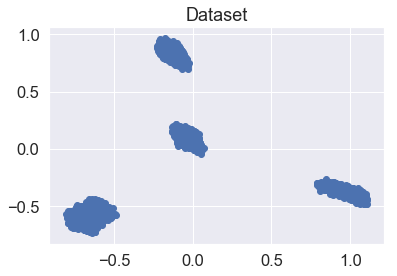

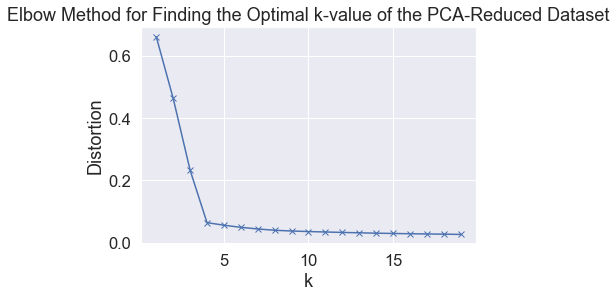

In [1197]:
#PCA transformation
transformer = PCA(n_components=2)
X_pca = transformer.fit_transform(X_std_fin)

X = ElbowPlot(X_pca, 'PCA')

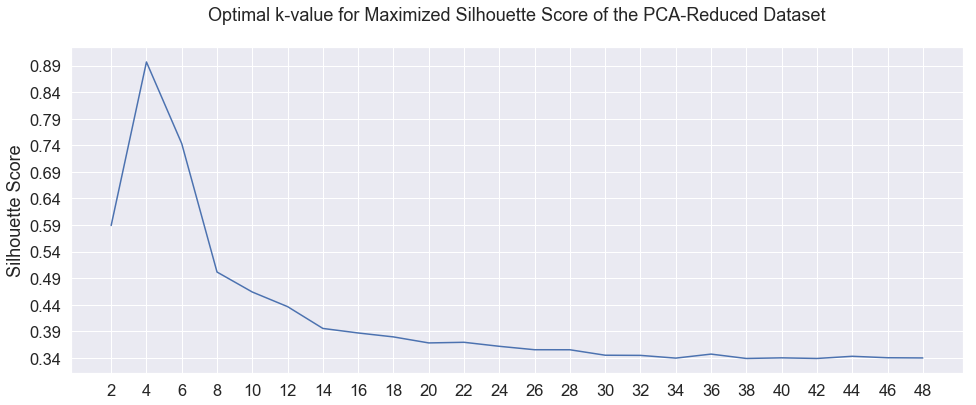

In [1198]:
opt_nclust = max_sil_plot(X, 'PCA')

From both tests, we can see that the optimal number of clusters is 4.

In [1206]:
#Generate colors cmap
cmp_pca = colorList(opt_nclust)

137 ms ± 7.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


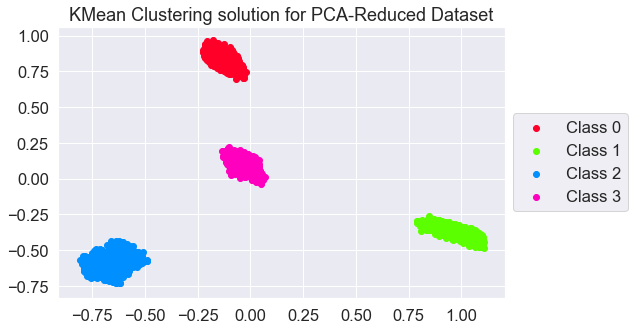

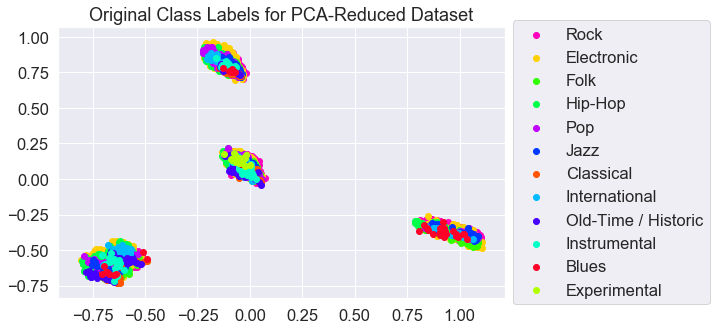

Adjusted Rand Index of the KMean Clustering solution on PCA-Reduced Dataset: 0.02271599841458426
Silhoutte Score of the KMean Clustering solution on PCA-Reduced Dataset: 0.8968901123144731


In [1207]:
#Plot KMeans-colored labels and original target labels
KMeansPlot(opt_nclust, X_pca, y, cmp1, cmp_pca, 'PCA', unique_gen)

The original genre labels don't seem to match at all with the new clusters, so the ARI is very low, at around 2%. However, the clusters are very clearly separated, so the Silhouette Score is high, at 90%.

580 ms ± 255 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


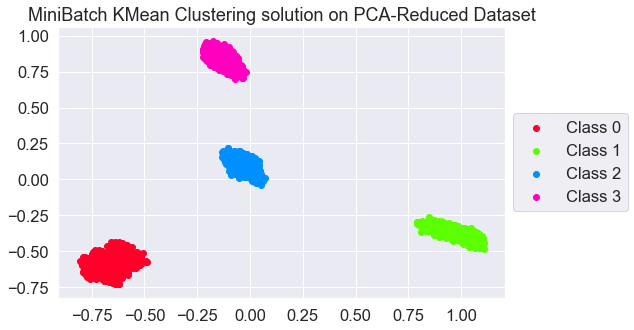

Silhoutte Score of the MiniBatchKMean Clustering solution on PCA-Reduced Dataset: 0.8968901123144731


In [1210]:
MiniBatchKMeansPlot(opt_nclust, X_pca, cmp_pca, 'PCA')

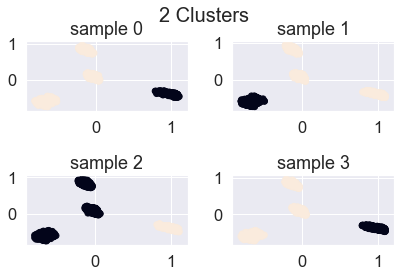

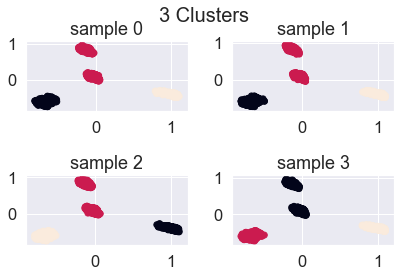

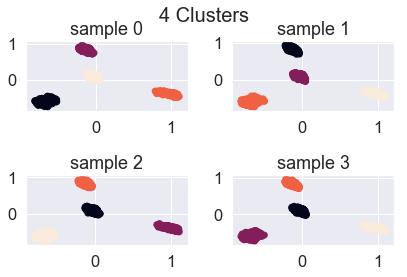

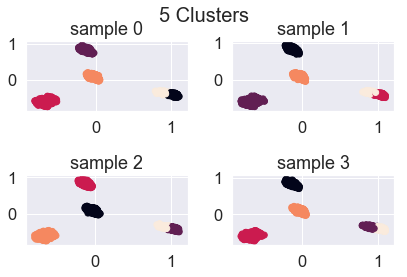

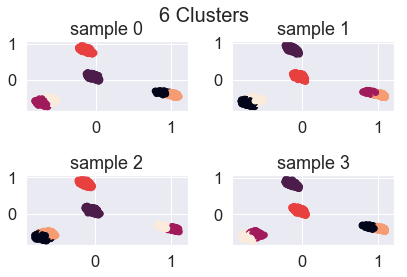

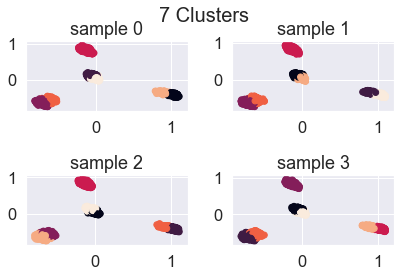

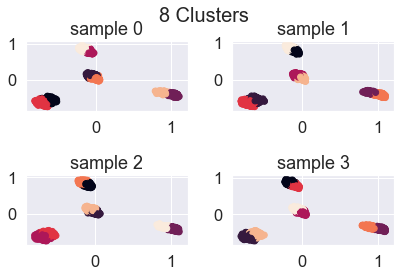

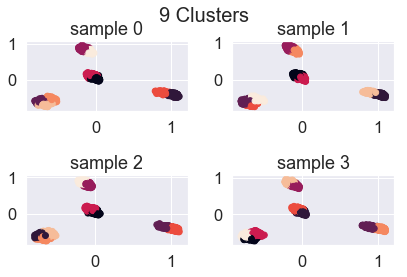

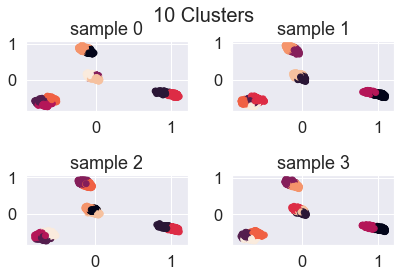

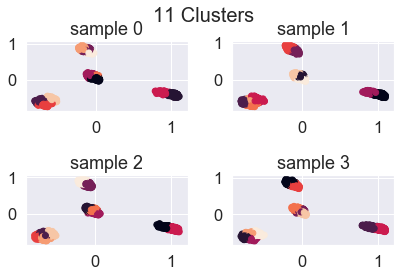

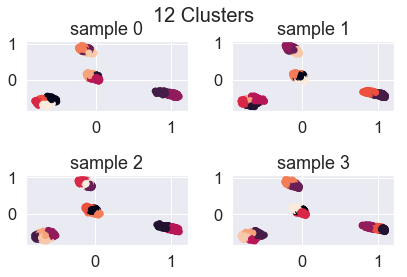




KMean Clustering on PCA-Reduced Dataset - Sub-Sample Silhouette Scores for k-value of 4
Sub-Sample # 1 :  0.8955920803603327
Sub-Sample # 2 :  0.8974814508629019
Sub-Sample # 3 :  0.8972934751698957
Sub-Sample # 4 :  0.897215643263964


In [1213]:
dataSplitComparisons(X, X_pca, opt_nclust, 'PCA')

Disregarding the specific colors used for each cluster, it is clear that the clusters created for each of the four sub-samples are relatively constant for all tested k-values, which can lead us to conclude that the data is balanced and this testing is reproducible with any sub-sample of the dataframe. Additionally, all four sub-samples give nearly the same high Silhouette Score of approximately 90%.

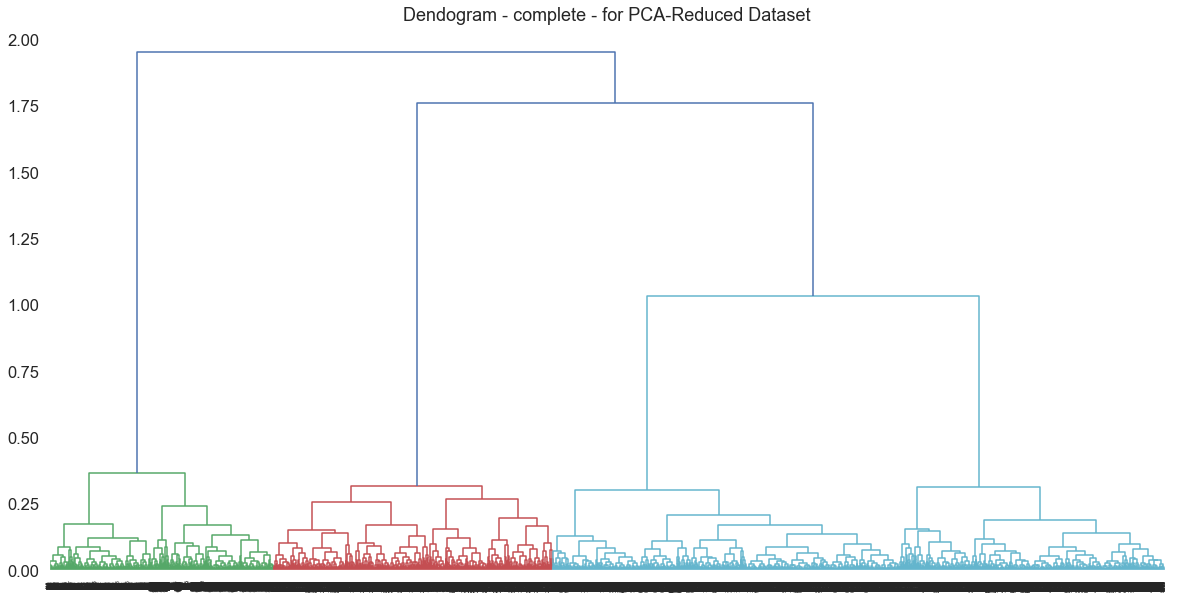

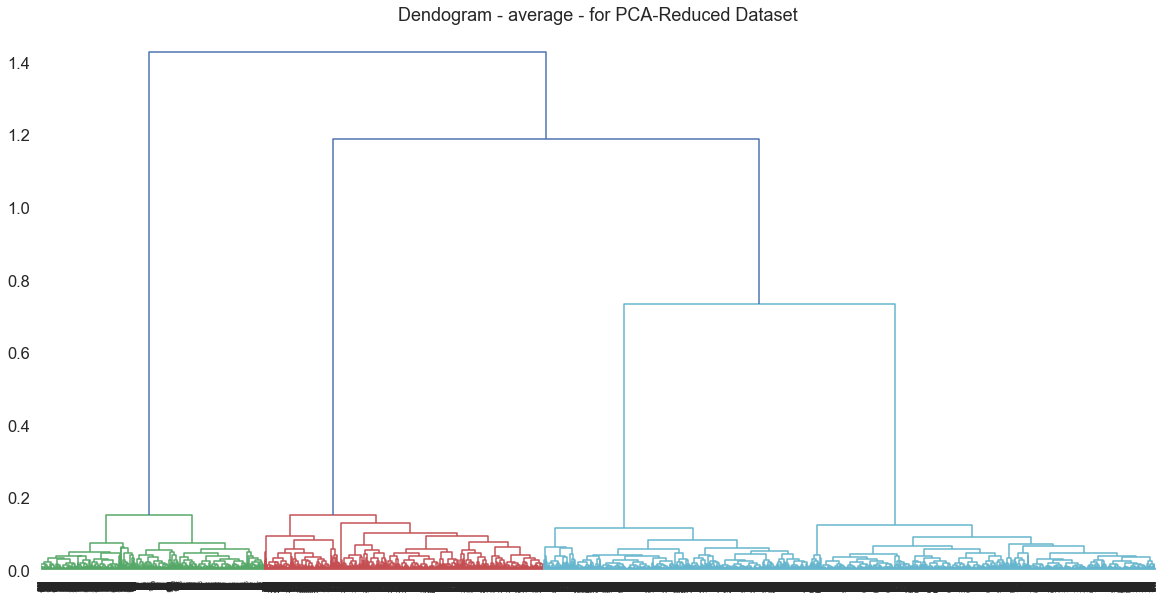

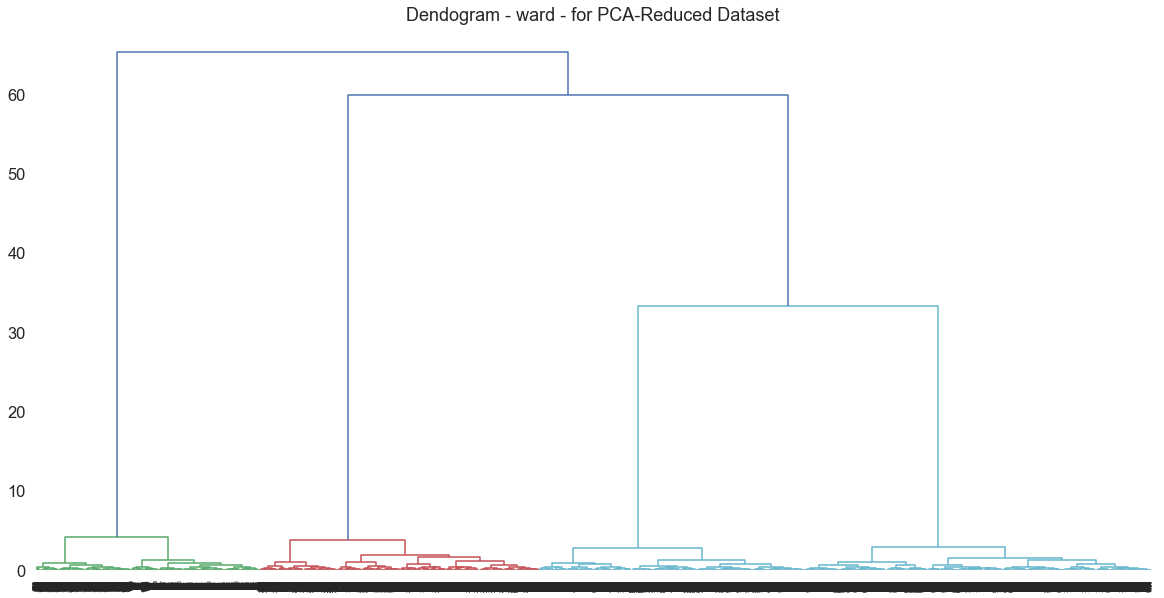

In [1214]:
dendogramPlots(X, 'PCA')

In [1215]:
aggClustering(X, y, opt_nclust, 'PCA')

Adjusted Rand Index of the Agglomerative Clustering solution for PCA-Reduced Dataset, utilizing the complete method: 0.011020712739956097
Silhoutte Score of the Agglomerative Clustering solution for PCA-Reduced Dataset, utilizing the complete method: 0.9105836343407236

-----------------------------------------------------------------------------------------

Adjusted Rand Index of the Agglomerative Clustering solution for PCA-Reduced Dataset, utilizing the average method: 0.012092443773725524
Silhoutte Score of the Agglomerative Clustering solution for PCA-Reduced Dataset, utilizing the average method: 0.8614865119989368

-----------------------------------------------------------------------------------------

Adjusted Rand Index of the Agglomerative Clustering solution for PCA-Reduced Dataset, utilizing the ward method: 0.02271599841458426
Silhoutte Score of the Agglomerative Clustering solution for PCA-Reduced Dataset, utilizing the ward method: 0.8968901123144731

----------------

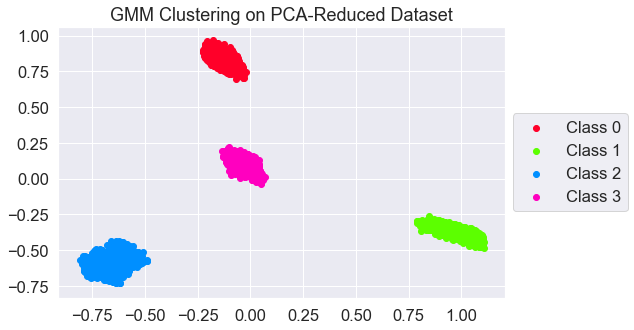

Adjusted Rand Index for GMM Clustering on PCA-Reduced Dataset: 0.02271599841458426
Silhouette Score for GMM Clustering on PCA-Reduced Dataset: 0.8968901123144731


In [1217]:
gmmClustering(X, X_pca, y, opt_nclust, cmp_pca, 'PCA')

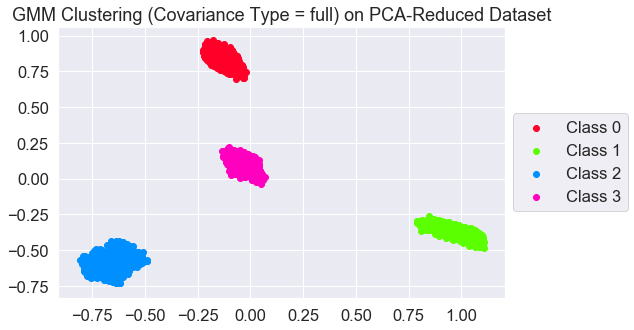

Adjusted Rand Index for GMM Clustering (Covariance Type = full) on PCA-Reduced Dataset: 0.02271599841458426
Silhouette Score for GMM (Covariance Type = full) on PCA-Reduced Dataset: 0.8968901123144731

-----------------------------------------------------------------------------------------



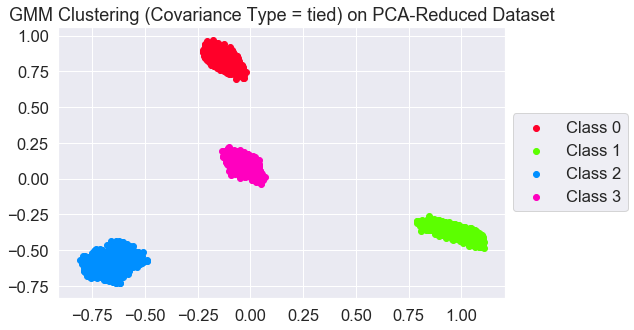

Adjusted Rand Index for GMM Clustering (Covariance Type = tied) on PCA-Reduced Dataset: 0.02271599841458426
Silhouette Score for GMM (Covariance Type = tied) on PCA-Reduced Dataset: 0.8968901123144731

-----------------------------------------------------------------------------------------



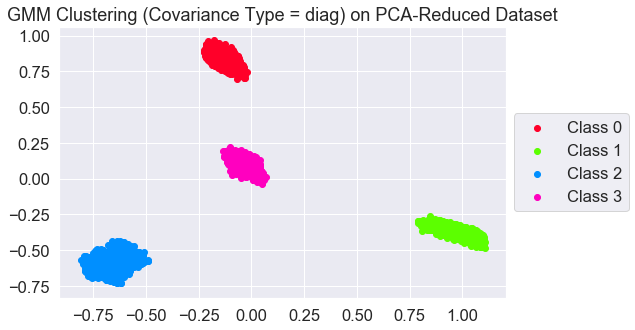

Adjusted Rand Index for GMM Clustering (Covariance Type = diag) on PCA-Reduced Dataset: 0.02271599841458426
Silhouette Score for GMM (Covariance Type = diag) on PCA-Reduced Dataset: 0.8968901123144731

-----------------------------------------------------------------------------------------



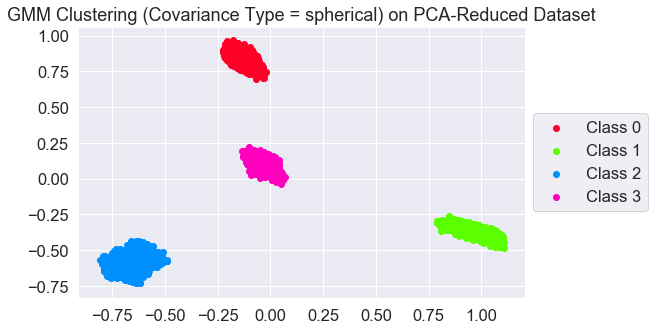

Adjusted Rand Index for GMM Clustering (Covariance Type = spherical) on PCA-Reduced Dataset: 0.02271599841458426
Silhouette Score for GMM (Covariance Type = spherical) on PCA-Reduced Dataset: 0.8968901123144731

-----------------------------------------------------------------------------------------



In [1220]:
gmmCovClustering(X, X_pca, y, opt_nclust, cmp_pca, 'PCA')

### PCA Conclusions
All of the models used above show great clustering success in terms of separation of the clusters on the two-component PCA scatter plot. They all have a Silhouette Score of around 89-90%. In fact, from a cursory look, the scores for each model seem to be almost identical. Therefore, I would use KMeans Clustering for the PCA-Reduced dataset, as I find it the most straight-forward to work with.

## Determination of Optimal t-SNE Parameters

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 7691 samples in 0.212s...
[t-SNE] Computed neighbors for 7691 samples in 9.859s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7691
[t-SNE] Computed conditional probabilities for sample 2000 / 7691
[t-SNE] Computed conditional probabilities for sample 3000 / 7691
[t-SNE] Computed conditional probabilities for sample 4000 / 7691
[t-SNE] Computed conditional probabilities for sample 5000 / 7691
[t-SNE] Computed conditional probabilities for sample 6000 / 7691
[t-SNE] Computed conditional probabilities for sample 7000 / 7691
[t-SNE] Computed conditional probabilities for sample 7691 / 7691
[t-SNE] Mean sigma: 0.232872
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.220596
[t-SNE] KL divergence after 300 iterations: 2.817477


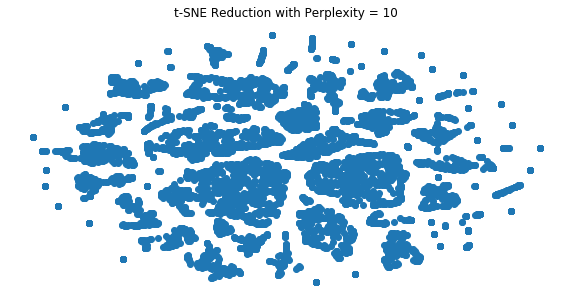

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7691 samples in 0.142s...
[t-SNE] Computed neighbors for 7691 samples in 15.504s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7691
[t-SNE] Computed conditional probabilities for sample 2000 / 7691
[t-SNE] Computed conditional probabilities for sample 3000 / 7691
[t-SNE] Computed conditional probabilities for sample 4000 / 7691
[t-SNE] Computed conditional probabilities for sample 5000 / 7691
[t-SNE] Computed conditional probabilities for sample 6000 / 7691
[t-SNE] Computed conditional probabilities for sample 7000 / 7691
[t-SNE] Computed conditional probabilities for sample 7691 / 7691
[t-SNE] Mean sigma: 0.288044
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.033180
[t-SNE] KL divergence after 300 iterations: 2.292366


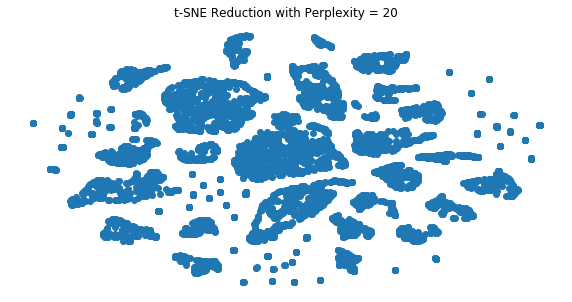

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7691 samples in 0.148s...
[t-SNE] Computed neighbors for 7691 samples in 15.091s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7691
[t-SNE] Computed conditional probabilities for sample 2000 / 7691
[t-SNE] Computed conditional probabilities for sample 3000 / 7691
[t-SNE] Computed conditional probabilities for sample 4000 / 7691
[t-SNE] Computed conditional probabilities for sample 5000 / 7691
[t-SNE] Computed conditional probabilities for sample 6000 / 7691
[t-SNE] Computed conditional probabilities for sample 7000 / 7691
[t-SNE] Computed conditional probabilities for sample 7691 / 7691
[t-SNE] Mean sigma: 0.323993
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.988747
[t-SNE] KL divergence after 300 iterations: 2.005618


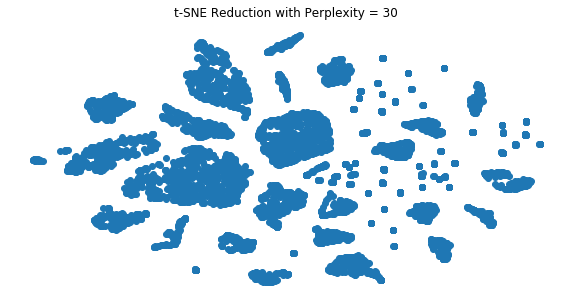

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7691 samples in 0.144s...
[t-SNE] Computed neighbors for 7691 samples in 17.774s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7691
[t-SNE] Computed conditional probabilities for sample 2000 / 7691
[t-SNE] Computed conditional probabilities for sample 3000 / 7691
[t-SNE] Computed conditional probabilities for sample 4000 / 7691
[t-SNE] Computed conditional probabilities for sample 5000 / 7691
[t-SNE] Computed conditional probabilities for sample 6000 / 7691
[t-SNE] Computed conditional probabilities for sample 7000 / 7691
[t-SNE] Computed conditional probabilities for sample 7691 / 7691
[t-SNE] Mean sigma: 0.351969
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.911270
[t-SNE] KL divergence after 300 iterations: 1.796475


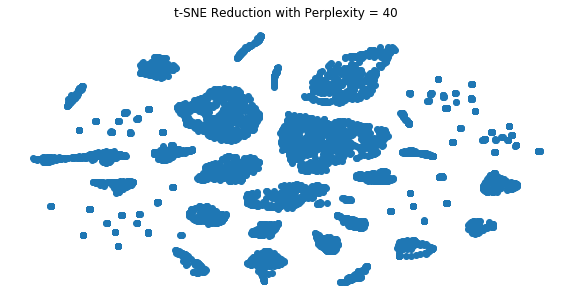

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7691 samples in 0.143s...
[t-SNE] Computed neighbors for 7691 samples in 20.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7691
[t-SNE] Computed conditional probabilities for sample 2000 / 7691
[t-SNE] Computed conditional probabilities for sample 3000 / 7691
[t-SNE] Computed conditional probabilities for sample 4000 / 7691
[t-SNE] Computed conditional probabilities for sample 5000 / 7691
[t-SNE] Computed conditional probabilities for sample 6000 / 7691
[t-SNE] Computed conditional probabilities for sample 7000 / 7691
[t-SNE] Computed conditional probabilities for sample 7691 / 7691
[t-SNE] Mean sigma: 0.375668
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.604595
[t-SNE] KL divergence after 300 iterations: 1.642739


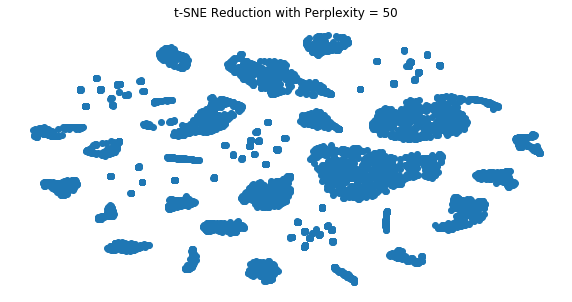

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 7691 samples in 0.144s...
[t-SNE] Computed neighbors for 7691 samples in 21.984s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7691
[t-SNE] Computed conditional probabilities for sample 2000 / 7691
[t-SNE] Computed conditional probabilities for sample 3000 / 7691
[t-SNE] Computed conditional probabilities for sample 4000 / 7691
[t-SNE] Computed conditional probabilities for sample 5000 / 7691
[t-SNE] Computed conditional probabilities for sample 6000 / 7691
[t-SNE] Computed conditional probabilities for sample 7000 / 7691
[t-SNE] Computed conditional probabilities for sample 7691 / 7691
[t-SNE] Mean sigma: 0.396752
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.749115
[t-SNE] KL divergence after 300 iterations: 1.514379


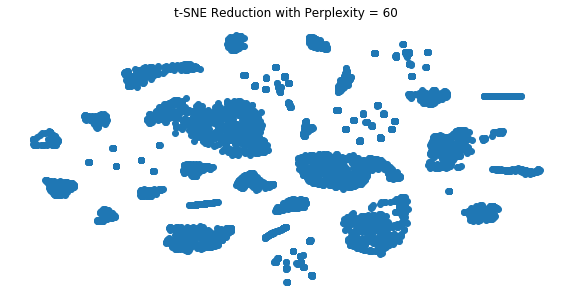

In [964]:
#Compute t-SNE components

for perp in [10, 20, 30, 40, 50, 60]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=300)
    tsne_results = tsne.fit_transform(X_std_fin)

    #Plot results
    plt.figure(figsize=(10,5))
    #for i in list(music_new2['Dummy_genre_top'].value_counts().index):  #Plot the larger classes first, so the smaller classes are on top
        #plt.scatter(pd.DataFrame(tsne_results)[0], pd.DataFrame(tsne_results)[1])

    #plt.legend()
    plt.title('t-SNE Reduction with Perplexity = {}'.format(str(perp)))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 7691 samples in 0.167s...
[t-SNE] Computed neighbors for 7691 samples in 21.055s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7691
[t-SNE] Computed conditional probabilities for sample 2000 / 7691
[t-SNE] Computed conditional probabilities for sample 3000 / 7691
[t-SNE] Computed conditional probabilities for sample 4000 / 7691
[t-SNE] Computed conditional probabilities for sample 5000 / 7691
[t-SNE] Computed conditional probabilities for sample 6000 / 7691
[t-SNE] Computed conditional probabilities for sample 7000 / 7691
[t-SNE] Computed conditional probabilities for sample 7691 / 7691
[t-SNE] Mean sigma: 0.415990
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.324734
[t-SNE] KL divergence after 300 iterations: 1.422781


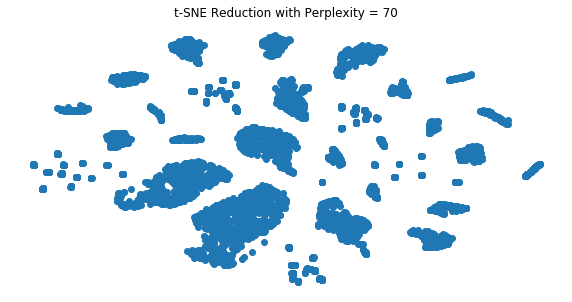

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 7691 samples in 0.159s...
[t-SNE] Computed neighbors for 7691 samples in 22.750s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7691
[t-SNE] Computed conditional probabilities for sample 2000 / 7691
[t-SNE] Computed conditional probabilities for sample 3000 / 7691
[t-SNE] Computed conditional probabilities for sample 4000 / 7691
[t-SNE] Computed conditional probabilities for sample 5000 / 7691
[t-SNE] Computed conditional probabilities for sample 6000 / 7691
[t-SNE] Computed conditional probabilities for sample 7000 / 7691
[t-SNE] Computed conditional probabilities for sample 7691 / 7691
[t-SNE] Mean sigma: 0.433788
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.166710
[t-SNE] KL divergence after 300 iterations: 1.342871


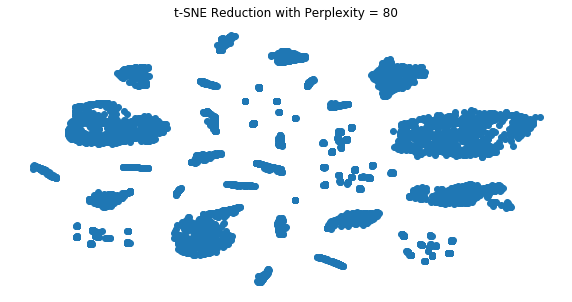

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 7691 samples in 0.200s...
[t-SNE] Computed neighbors for 7691 samples in 23.265s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7691
[t-SNE] Computed conditional probabilities for sample 2000 / 7691
[t-SNE] Computed conditional probabilities for sample 3000 / 7691
[t-SNE] Computed conditional probabilities for sample 4000 / 7691
[t-SNE] Computed conditional probabilities for sample 5000 / 7691
[t-SNE] Computed conditional probabilities for sample 6000 / 7691
[t-SNE] Computed conditional probabilities for sample 7000 / 7691
[t-SNE] Computed conditional probabilities for sample 7691 / 7691
[t-SNE] Mean sigma: 0.450386
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.184296
[t-SNE] KL divergence after 300 iterations: 1.263268


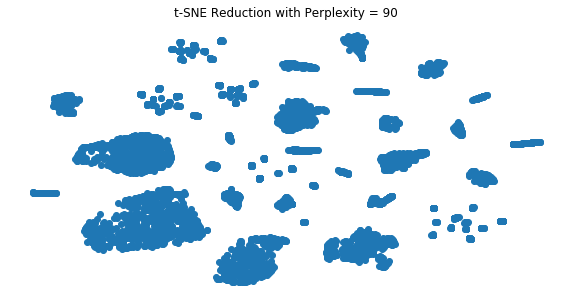

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 7691 samples in 0.152s...
[t-SNE] Computed neighbors for 7691 samples in 22.810s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7691
[t-SNE] Computed conditional probabilities for sample 2000 / 7691
[t-SNE] Computed conditional probabilities for sample 3000 / 7691
[t-SNE] Computed conditional probabilities for sample 4000 / 7691
[t-SNE] Computed conditional probabilities for sample 5000 / 7691
[t-SNE] Computed conditional probabilities for sample 6000 / 7691
[t-SNE] Computed conditional probabilities for sample 7000 / 7691
[t-SNE] Computed conditional probabilities for sample 7691 / 7691
[t-SNE] Mean sigma: 0.465906
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.482464
[t-SNE] KL divergence after 300 iterations: 1.196491


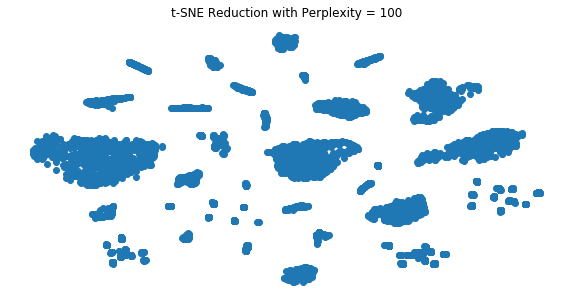

[t-SNE] Computing 331 nearest neighbors...
[t-SNE] Indexed 7691 samples in 0.154s...
[t-SNE] Computed neighbors for 7691 samples in 26.626s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7691
[t-SNE] Computed conditional probabilities for sample 2000 / 7691
[t-SNE] Computed conditional probabilities for sample 3000 / 7691
[t-SNE] Computed conditional probabilities for sample 4000 / 7691
[t-SNE] Computed conditional probabilities for sample 5000 / 7691
[t-SNE] Computed conditional probabilities for sample 6000 / 7691
[t-SNE] Computed conditional probabilities for sample 7000 / 7691
[t-SNE] Computed conditional probabilities for sample 7691 / 7691
[t-SNE] Mean sigma: 0.480435
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.030273
[t-SNE] KL divergence after 300 iterations: 1.158714


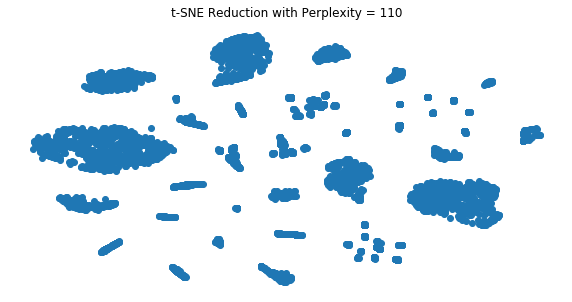

[t-SNE] Computing 361 nearest neighbors...
[t-SNE] Indexed 7691 samples in 0.143s...
[t-SNE] Computed neighbors for 7691 samples in 25.412s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7691
[t-SNE] Computed conditional probabilities for sample 2000 / 7691
[t-SNE] Computed conditional probabilities for sample 3000 / 7691
[t-SNE] Computed conditional probabilities for sample 4000 / 7691
[t-SNE] Computed conditional probabilities for sample 5000 / 7691
[t-SNE] Computed conditional probabilities for sample 6000 / 7691
[t-SNE] Computed conditional probabilities for sample 7000 / 7691
[t-SNE] Computed conditional probabilities for sample 7691 / 7691
[t-SNE] Mean sigma: 0.494040
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.914059
[t-SNE] KL divergence after 300 iterations: 1.113130


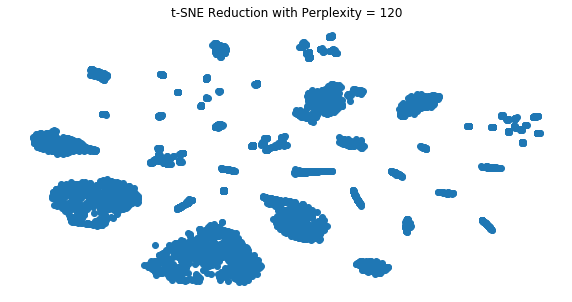

In [965]:
#Compute t-SNE components

for perp in [70, 80, 90, 100, 110, 120]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=300)
    tsne_results = tsne.fit_transform(X_std_fin)

    #Plot results
    plt.figure(figsize=(10,5))
    #for i in list(music_new2['Dummy_genre_top'].value_counts().index):  #Plot the larger classes first, so the smaller classes are on top
        #plt.scatter(pd.DataFrame(tsne_results)[0], pd.DataFrame(tsne_results)[1])

    #plt.legend()
    plt.title('t-SNE Reduction with Perplexity = {}'.format(str(perp)))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

Based on the several t-SNE tests performed, it seems that visually, the best clustering occurs with a higher perplexity, somewhere around 150. Therefore, that's the parameter I chose to work with for the modeling in this section of this project.

## Unsupervized Modeling on TSNE-Reduced Dataset

[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 7691 samples in 0.146s...
[t-SNE] Computed neighbors for 7691 samples in 26.286s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7691
[t-SNE] Computed conditional probabilities for sample 2000 / 7691
[t-SNE] Computed conditional probabilities for sample 3000 / 7691
[t-SNE] Computed conditional probabilities for sample 4000 / 7691
[t-SNE] Computed conditional probabilities for sample 5000 / 7691
[t-SNE] Computed conditional probabilities for sample 6000 / 7691
[t-SNE] Computed conditional probabilities for sample 7000 / 7691
[t-SNE] Computed conditional probabilities for sample 7691 / 7691
[t-SNE] Mean sigma: 0.530168
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.053753
[t-SNE] KL divergence after 300 iterations: 1.018269


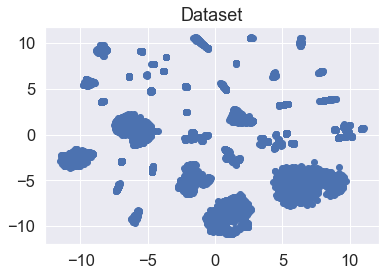

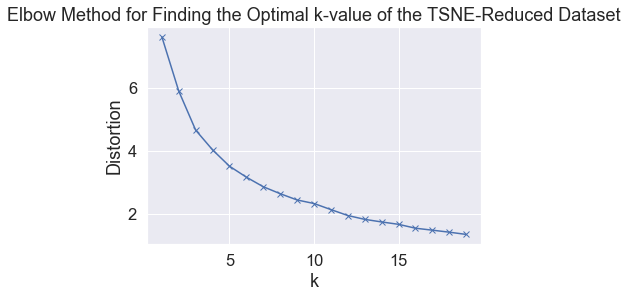

In [1222]:
#Compute t-SNE components
tsne = TSNE(n_components=2, verbose=1, perplexity=150, n_iter=300)
tsne_results = tsne.fit_transform(X_std_fin)

X = ElbowPlot(tsne_results, 'TSNE')

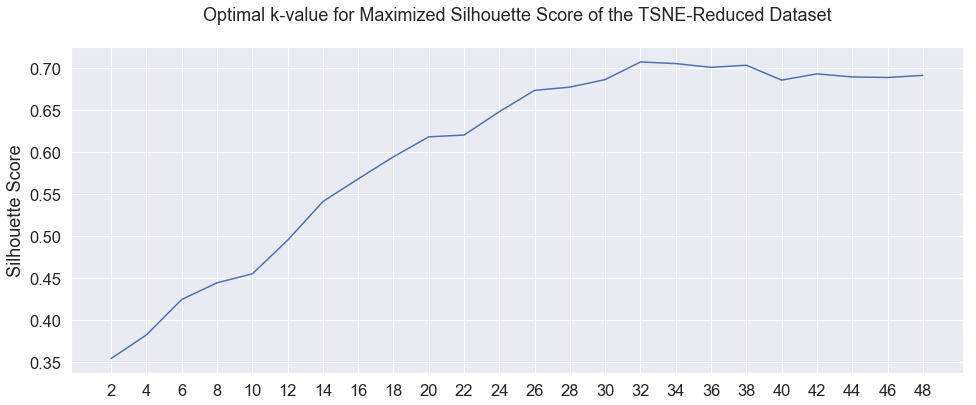

In [1223]:
opt_nclust = max_sil_plot(X, 'TSNE')

The Elbow Plot doesn't really have a definitive 'elbow' or bend in the plot, but we can see that the maximized Silhouette Score occurs at a k-value of 32, so that is the `n_clust` we will use for the TSNE portion of this project.

In [1224]:
cmp_tsne = colorList(opt_nclust)

1.5 s ± 86.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


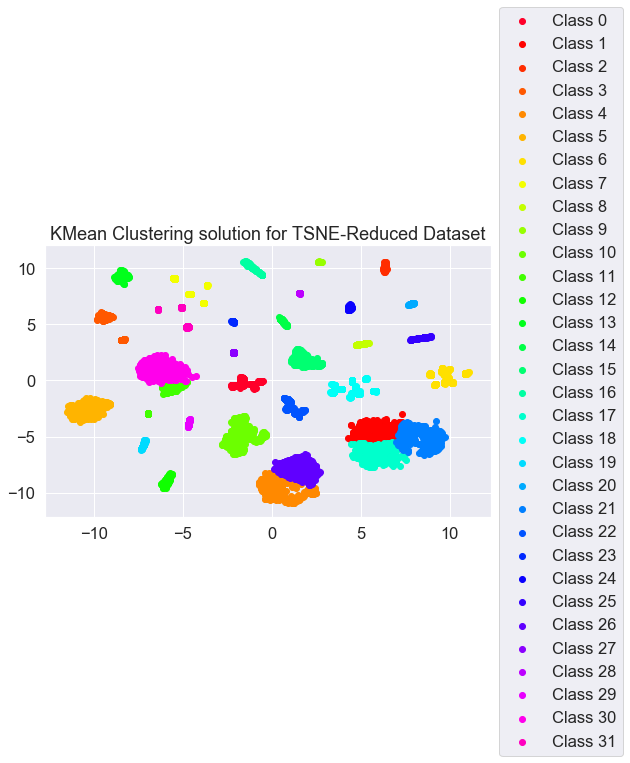

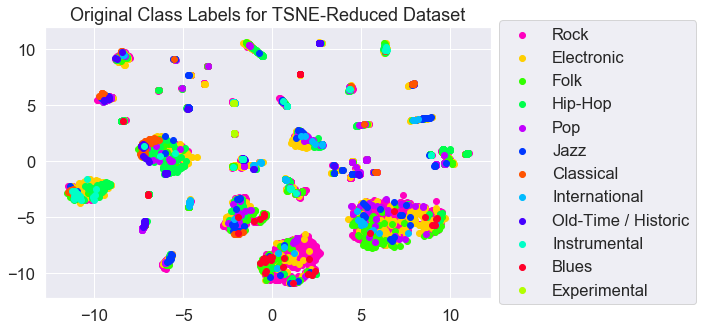

Adjusted Rand Index of the KMean Clustering solution on TSNE-Reduced Dataset: 0.017111555479395357
Silhoutte Score of the KMean Clustering solution on TSNE-Reduced Dataset: 0.7038398385047913


In [1225]:
KMeansPlot(opt_nclust, tsne_results, y, cmp1, cmp_tsne, 'TSNE', unique_gen)

As with the PCA reduction, the original labels do not seem to match very well with the TSNE clusters, again with an ARI of approximately 2%. However, differently from PCA, this KMeans Clustering doesn't group the points as well, likely due to the increase in data spread in the plotted two-component TSNE-Reduced dataset. MiniBatch KMeans Clustering performs worse, with a Silhouette Score of only 61%.

The slowest run took 5.71 times longer than the fastest. This could mean that an intermediate result is being cached.
517 ms ± 399 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


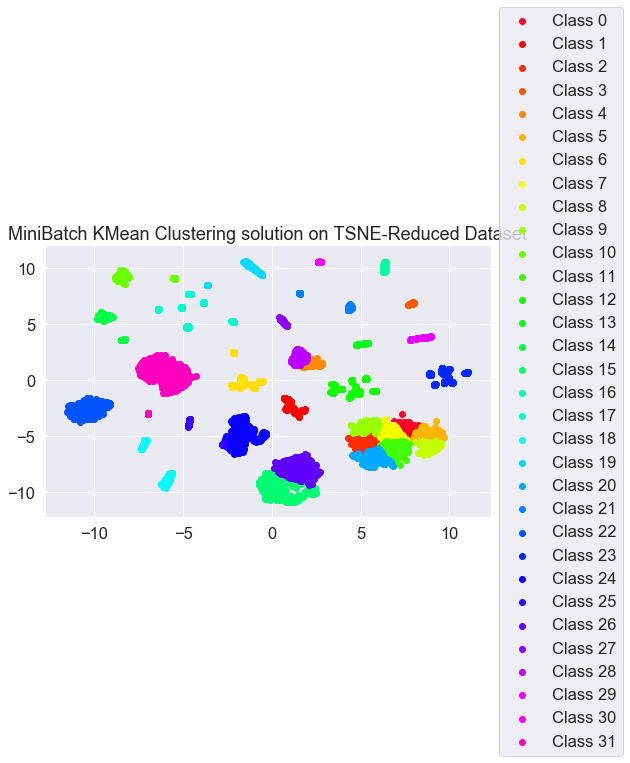

Silhoutte Score of the MiniBatchKMean Clustering solution on TSNE-Reduced Dataset: 0.6146194338798523


In [1226]:
MiniBatchKMeansPlot(opt_nclust, tsne_results, cmp_tsne, 'TSNE')

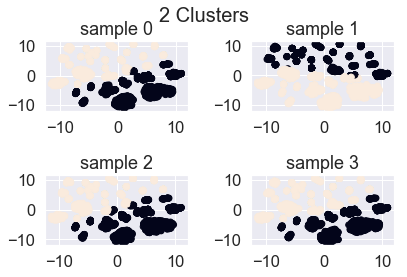

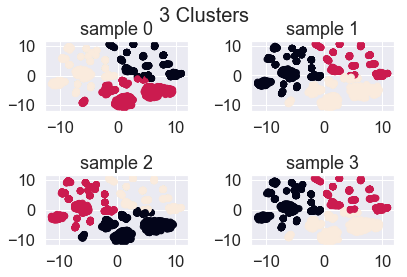

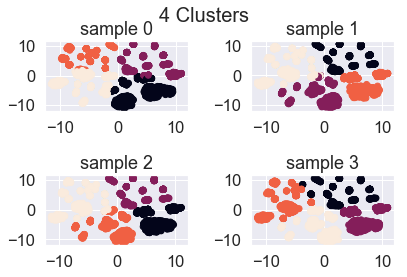

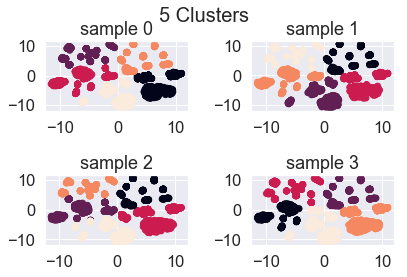

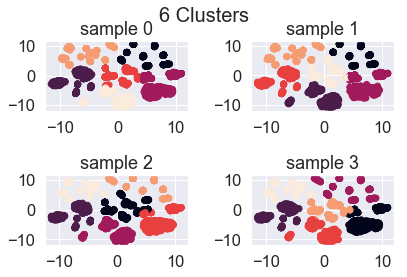

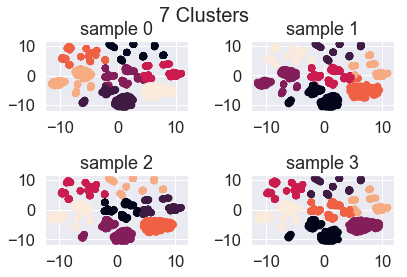

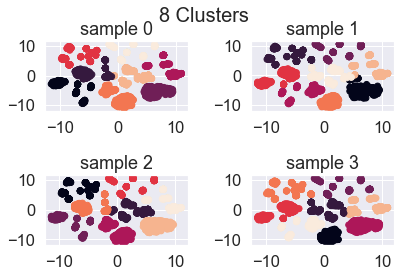

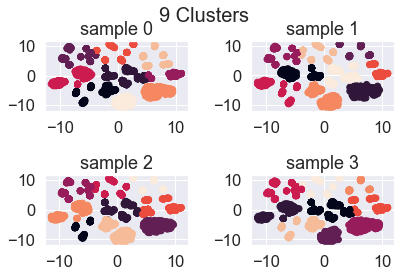

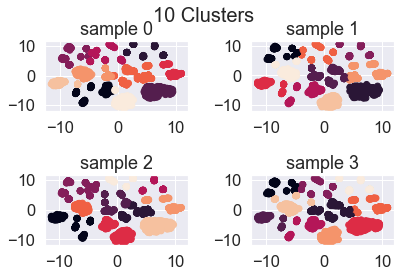

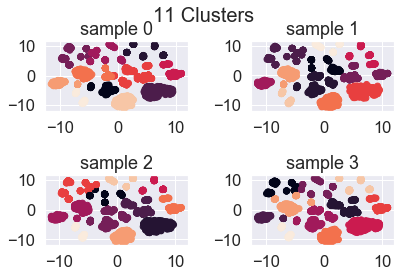

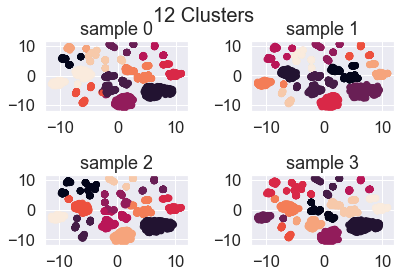




KMean Clustering on TSNE-Reduced Dataset - Sub-Sample Silhouette Scores for k-value of 32
Sub-Sample # 1 :  0.71405125
Sub-Sample # 2 :  0.7044166
Sub-Sample # 3 :  0.6960272
Sub-Sample # 4 :  0.6969495


In [1227]:
dataSplitComparisons(X, tsne_results, opt_nclust, 'TSNE')

The set of different k-values tested in this sub-sampling experiment show that generally, the clusters remain the same between the four sub-samples. This means this experiment is reproducible with any sub-sample of our dataset.

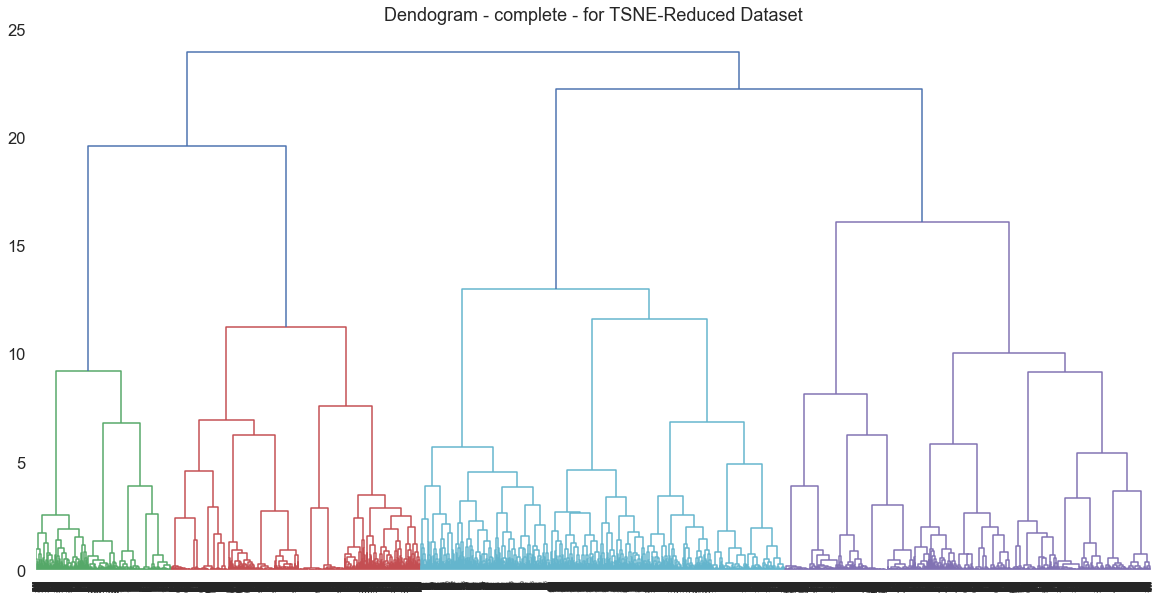

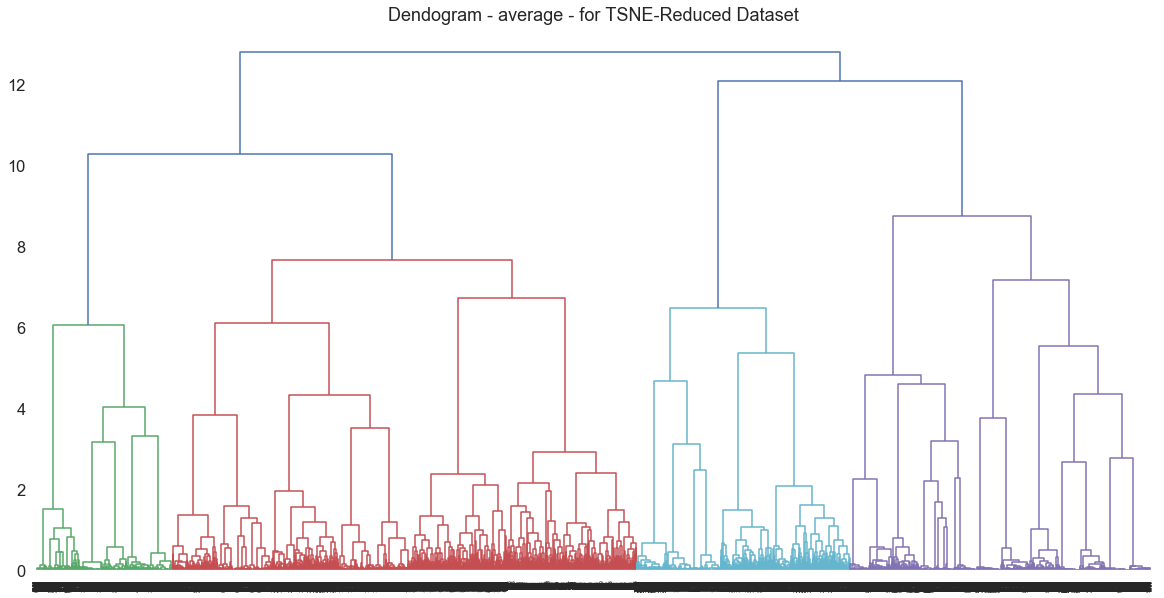

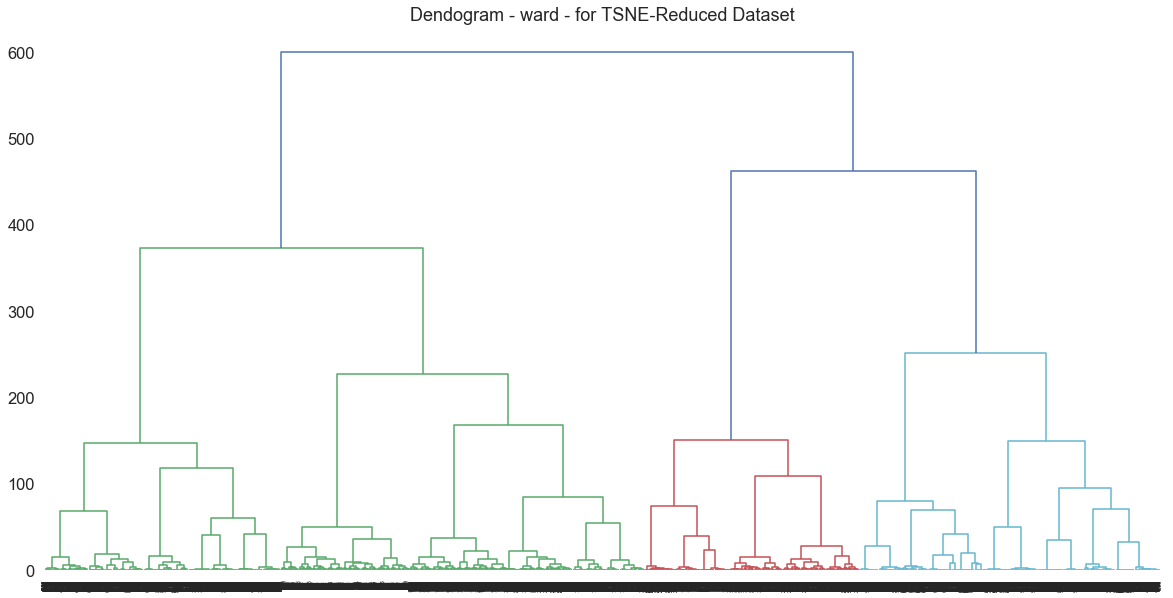

In [1228]:
dendogramPlots(X, 'TSNE')

In [1229]:
aggClustering(X, y, opt_nclust, 'TSNE')

Adjusted Rand Index of the Agglomerative Clustering solution for TSNE-Reduced Dataset, utilizing the complete method: 0.014214587177286284
Silhoutte Score of the Agglomerative Clustering solution for TSNE-Reduced Dataset, utilizing the complete method: 0.7943890690803528

-----------------------------------------------------------------------------------------

Adjusted Rand Index of the Agglomerative Clustering solution for TSNE-Reduced Dataset, utilizing the average method: 0.012839292067317406
Silhoutte Score of the Agglomerative Clustering solution for TSNE-Reduced Dataset, utilizing the average method: 0.771706223487854

-----------------------------------------------------------------------------------------

Adjusted Rand Index of the Agglomerative Clustering solution for TSNE-Reduced Dataset, utilizing the ward method: 0.016939978359603997
Silhoutte Score of the Agglomerative Clustering solution for TSNE-Reduced Dataset, utilizing the ward method: 0.6916463375091553

----------

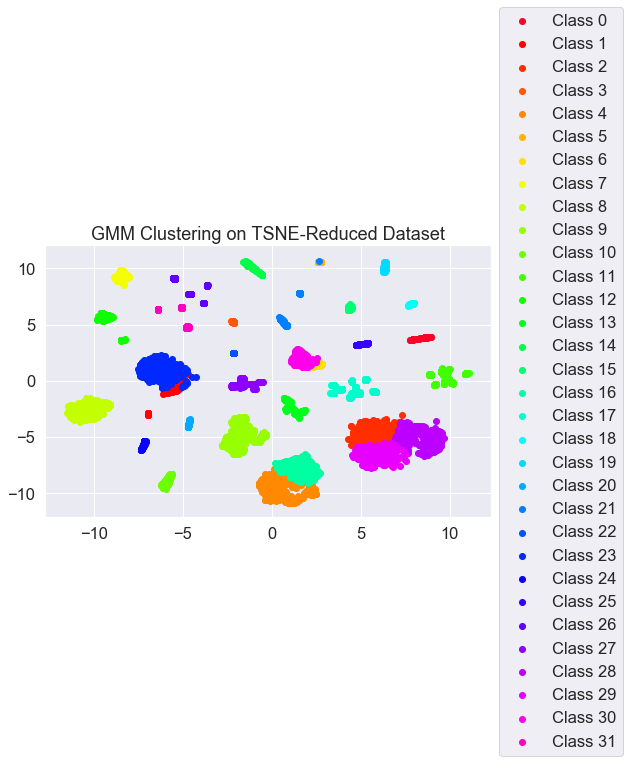

Adjusted Rand Index for GMM Clustering on TSNE-Reduced Dataset: 0.016263803330348308
Silhouette Score for GMM Clustering on TSNE-Reduced Dataset: 0.6798781752586365


In [1230]:
gmmClustering(X, tsne_results, y, opt_nclust, cmp_tsne, 'TSNE')

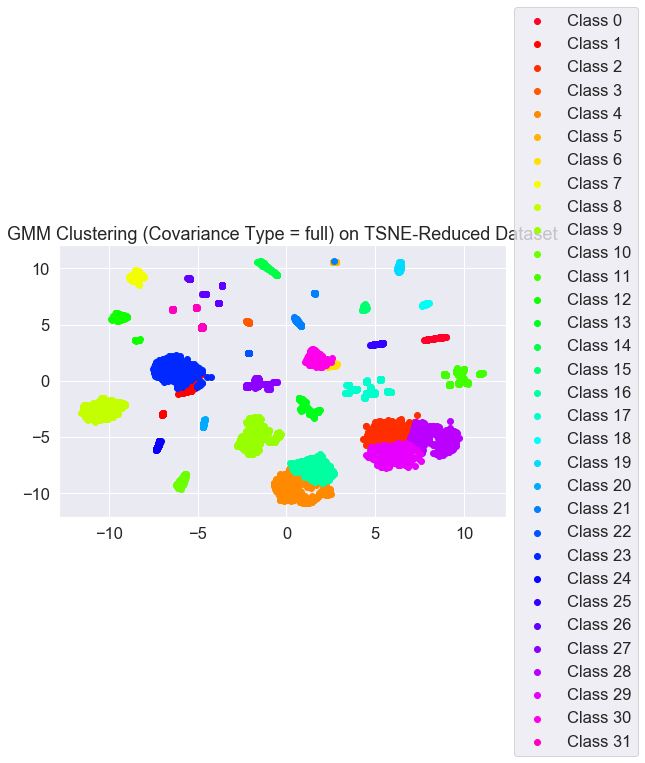

Adjusted Rand Index for GMM Clustering (Covariance Type = full) on TSNE-Reduced Dataset: 0.016263803330348308
Silhouette Score for GMM (Covariance Type = full) on TSNE-Reduced Dataset: 0.6798781752586365

-----------------------------------------------------------------------------------------



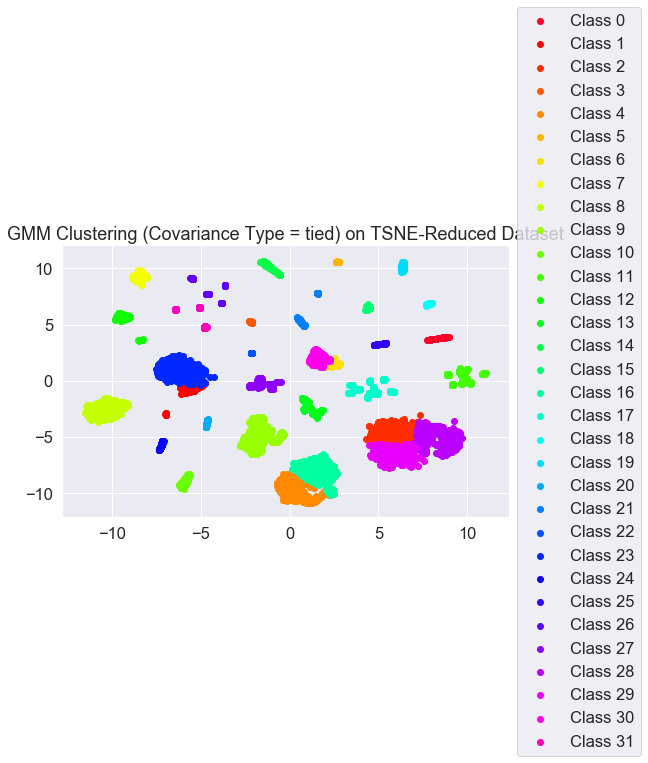

Adjusted Rand Index for GMM Clustering (Covariance Type = tied) on TSNE-Reduced Dataset: 0.018010250216864553
Silhouette Score for GMM (Covariance Type = tied) on TSNE-Reduced Dataset: 0.682121753692627

-----------------------------------------------------------------------------------------



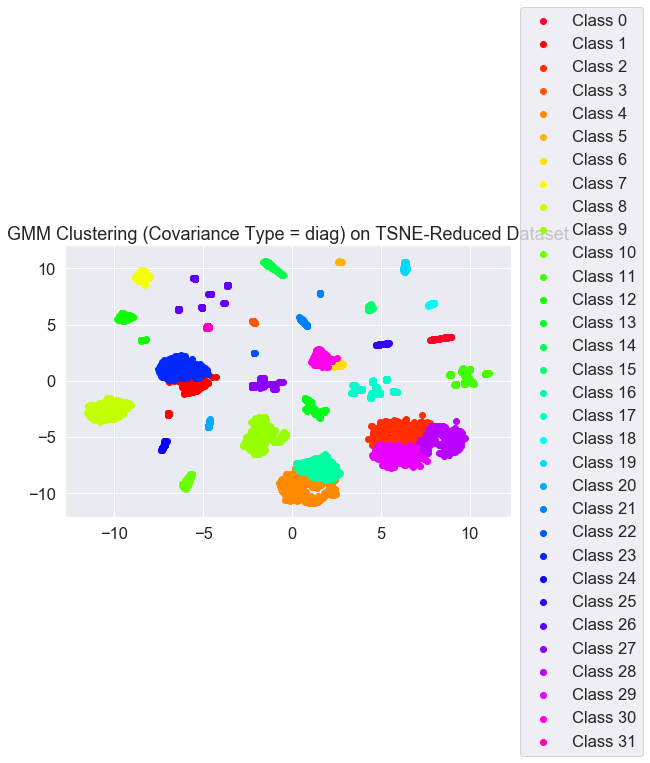

Adjusted Rand Index for GMM Clustering (Covariance Type = diag) on TSNE-Reduced Dataset: 0.018288934506157112
Silhouette Score for GMM (Covariance Type = diag) on TSNE-Reduced Dataset: 0.6778883934020996

-----------------------------------------------------------------------------------------



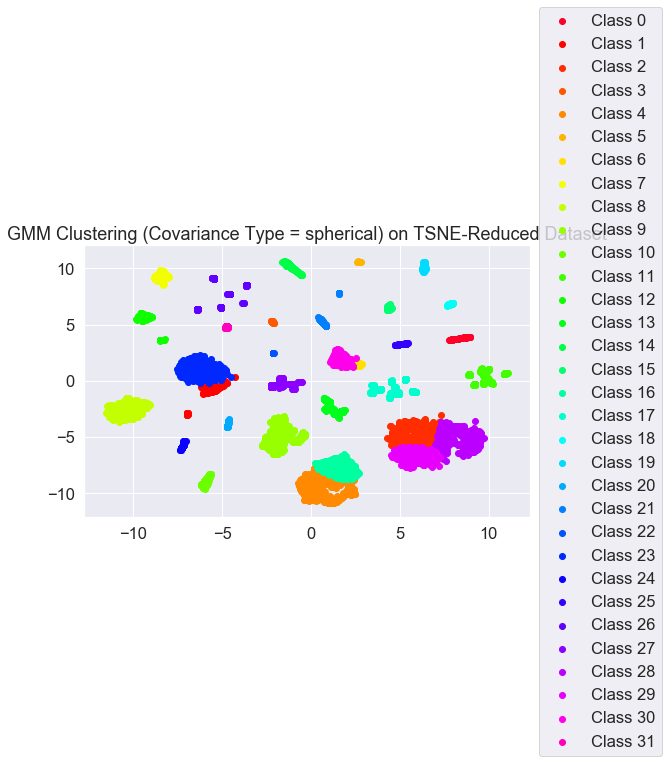

Adjusted Rand Index for GMM Clustering (Covariance Type = spherical) on TSNE-Reduced Dataset: 0.017113825047657735
Silhouette Score for GMM (Covariance Type = spherical) on TSNE-Reduced Dataset: 0.6780109405517578

-----------------------------------------------------------------------------------------



In [1231]:
gmmCovClustering(X, tsne_results, y, opt_nclust, cmp_tsne, 'TSNE')

No matter which covariance used, GMM Clustering does not do a better job that KMeans. In fact, the Silhouette Scores here come out to around 68% for each GMM version.

### TSNE Conclusions
Visually, the clustering doesn't seem to be very good for the TSNE-reduced dataset. Using the optimal number of clusters, determined based on maximizing the Silhouette Score, the clusters seem very imbalanced, and with some of the models, the TSNE clusters have multiple color clusters within them, which isn't ideal. The highest Silhouette Score achieved for the TSNE-Reduced dataset is around 79%, accomplished with Agglomerative Clustering, utilizing the 'complete' method. Therefore, TSNE dimensionality reduction is less successful than PCA in terms of the unsupervised clustering of this dataset.

## Determination of Optimal UMAP Parameters

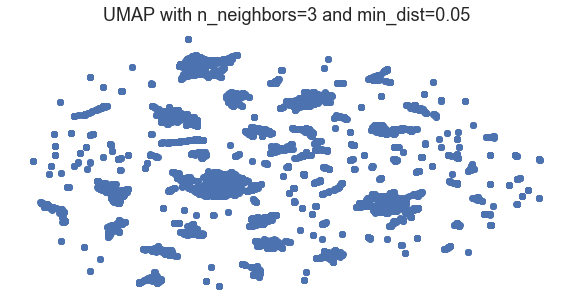

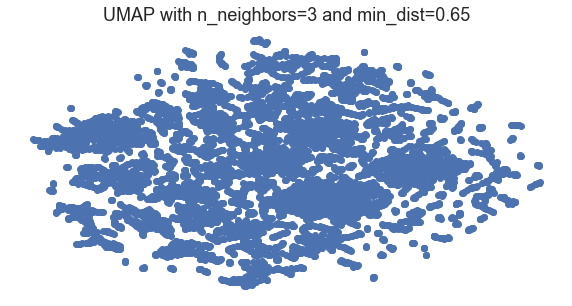

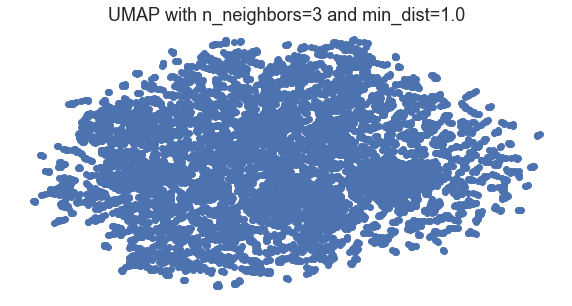

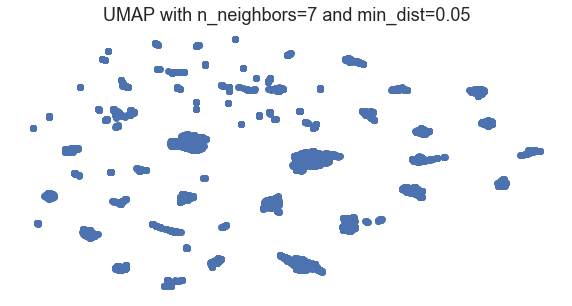

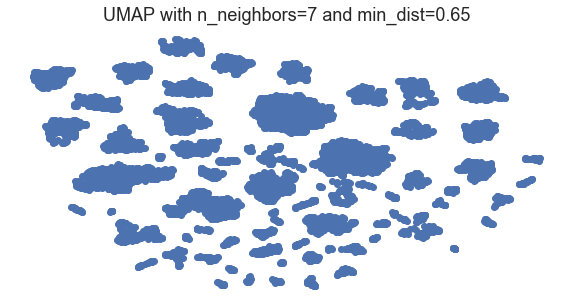

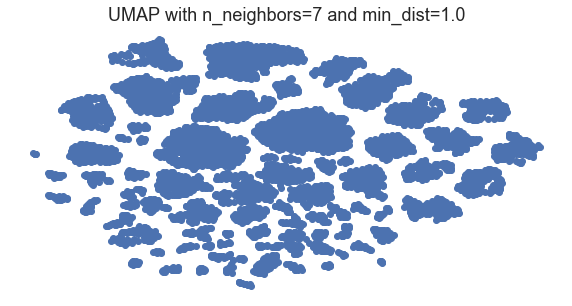

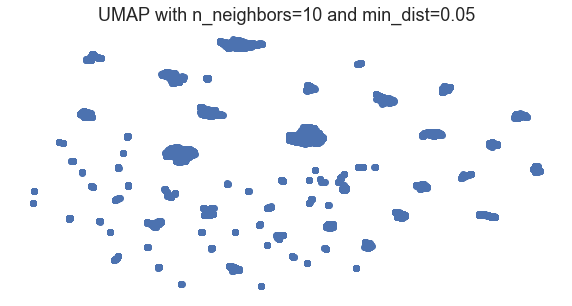

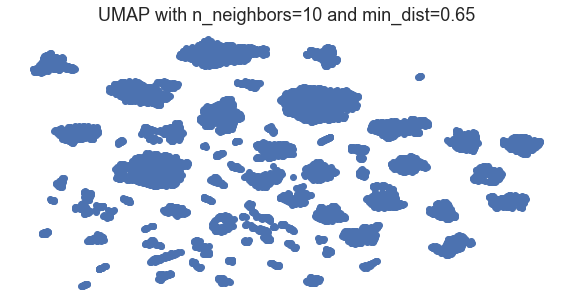

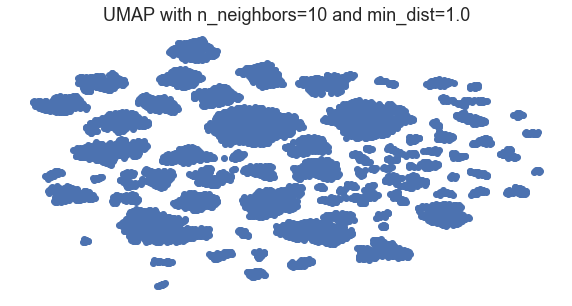

In [1076]:
for neighbor in [3, 7, 10]:
    for dist in [0.05, 0.65, 1.0]:
        #Computing the UMAP components
        umap_results = umap.UMAP(n_neighbors=neighbor,
                          min_dist=dist,
                          metric='correlation').fit_transform(X_std_fin)

        plt.figure(figsize=(10,5))
        plt.scatter(umap_results[:, 0], umap_results[:, 1])
        
        #plt.scatter(umap_results[:, 0], umap_results[:, 1], c=y)
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.title('UMAP with n_neighbors={} and min_dist={}'.format(neighbor, dist))
        plt.show()

Visually, the most clearly delineated clusters for UMAP reduction seem to occur with the following parameters: `n_neighbors` = 10 and `min_dist`= 1.0. Therefore, those are the parameters I chose to use in this portion of the project.

## Unsupervized Modeling on UMAP-Reduced Dataset

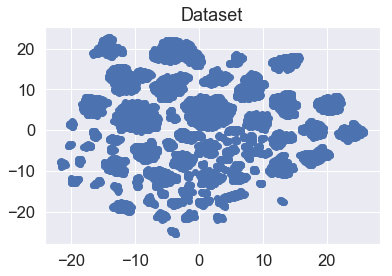

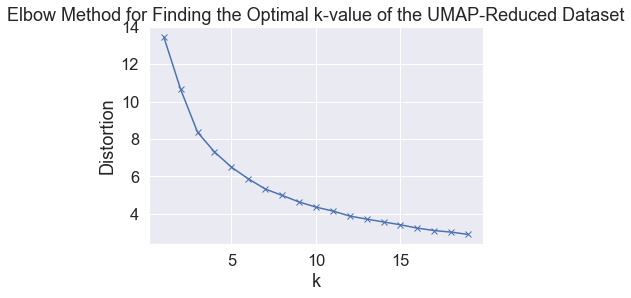

In [1232]:
#Compute UMAP components
umap_results = umap.UMAP(n_neighbors=10,
                          min_dist=1.0,
                          metric='correlation').fit_transform(X_std_fin)

X = ElbowPlot(umap_results, 'UMAP')

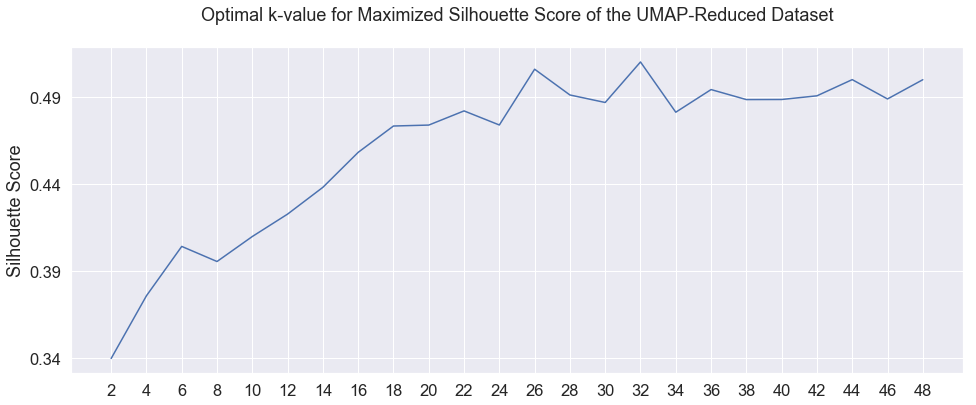

In [1233]:
opt_nclust = max_sil_plot(X, 'UMAP')

It's hard to tell exactly where the elbow is, but we can see that the maximum Silhouette Score for this dataset occurs at a k-vlue of 32, so that's the number of clusters we will aim for. 

In [1234]:
cmp_umap = colorList(opt_nclust)

1.96 s ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


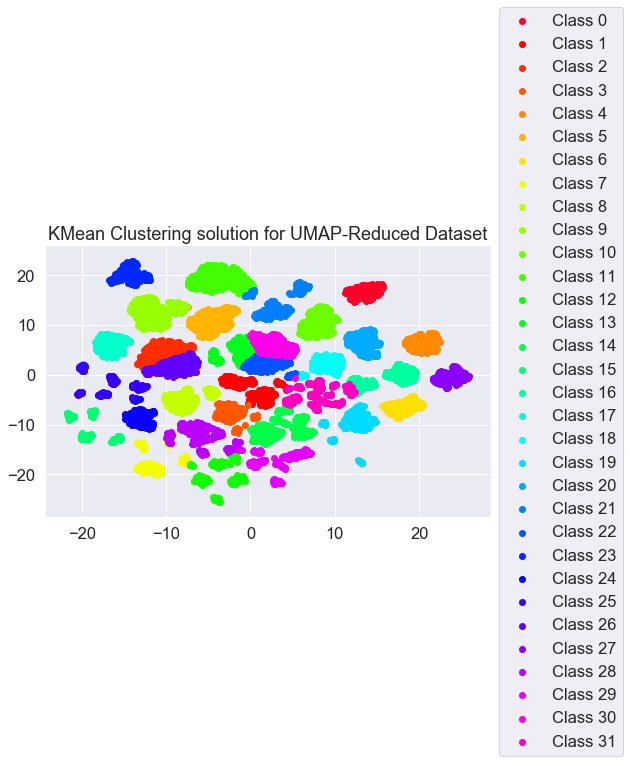

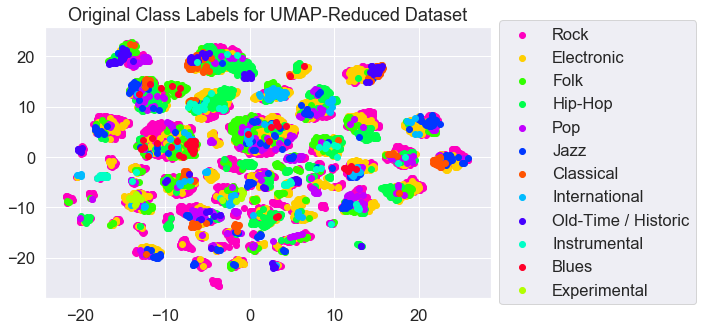

Adjusted Rand Index of the KMean Clustering solution on UMAP-Reduced Dataset: 0.014338514450810962
Silhoutte Score of the KMean Clustering solution on UMAP-Reduced Dataset: 0.4917300045490265


In [1235]:
KMeansPlot(opt_nclust, umap_results, y, cmp1, cmp_umap, 'UMAP', unique_gen)

The slowest run took 6.10 times longer than the fastest. This could mean that an intermediate result is being cached.
1.06 s ± 418 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


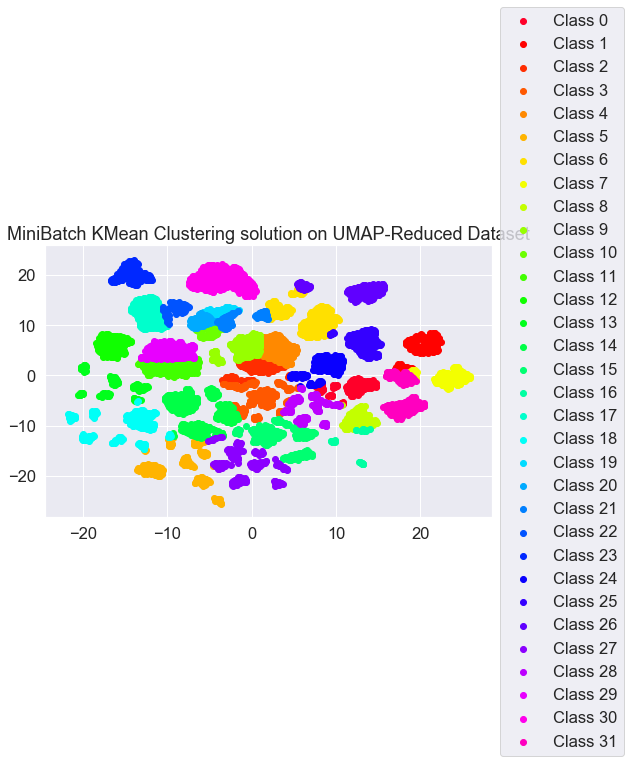

Silhoutte Score of the MiniBatchKMean Clustering solution on UMAP-Reduced Dataset: 0.40481841564178467


In [1236]:
MiniBatchKMeansPlot(opt_nclust, umap_results, cmp_umap, 'UMAP')

For KMeans and MiniBatch KMeans, the Silhouette Scores come out to around 50% and 40%, respectively. These scores are significantly less than those achieved with the previous two dimensionality reduction methods. From these results, it seems unlikely that UMAP reduction will end up being the best choice for this project, but let's try the other methods to make sure.

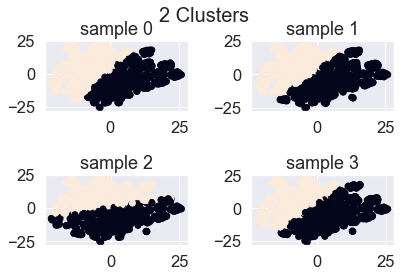

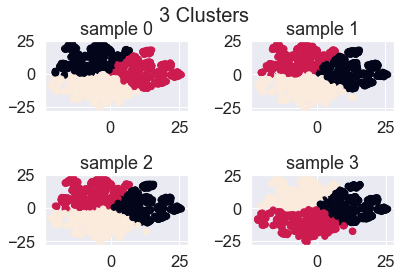

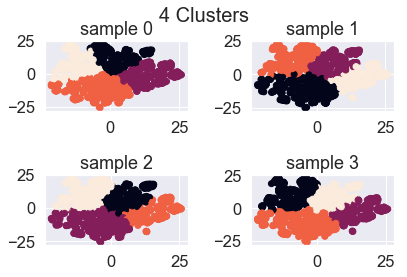

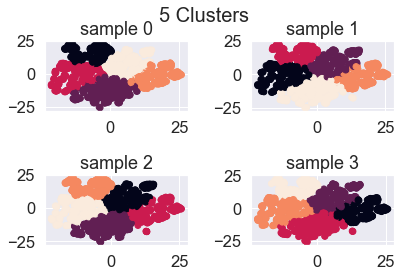

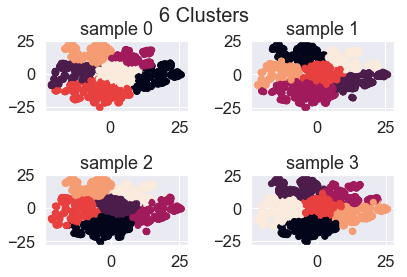

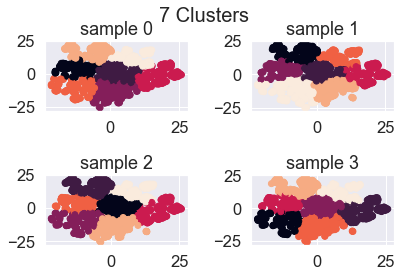

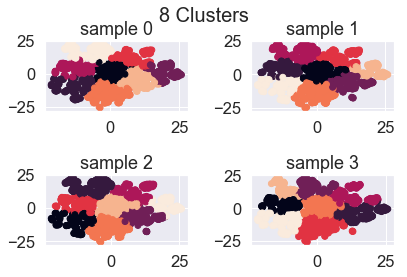

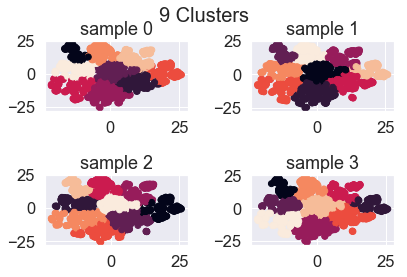

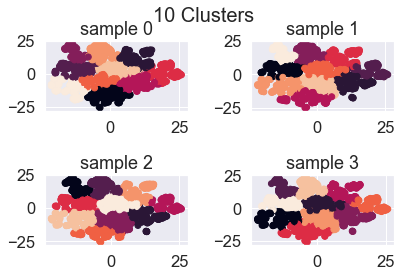

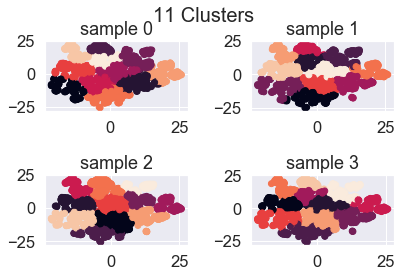

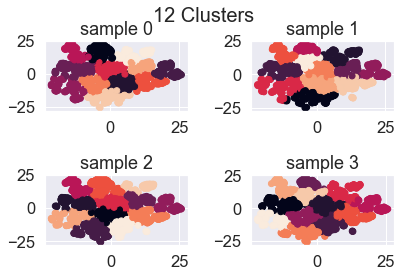




KMean Clustering on UMAP-Reduced Dataset - Sub-Sample Silhouette Scores for k-value of 32
Sub-Sample # 1 :  0.48846665
Sub-Sample # 2 :  0.51230323
Sub-Sample # 3 :  0.49224687
Sub-Sample # 4 :  0.49836493


In [1237]:
dataSplitComparisons(X, umap_results, opt_nclust, 'UMAP')

As with both PCA and TSNE, the sub-samples of the UMAP-Reduced show fairly consistent KMeans clustering results, indicating that the dataset is evenly distributed and that these models are reproducible with any sub-sample of the dataset.

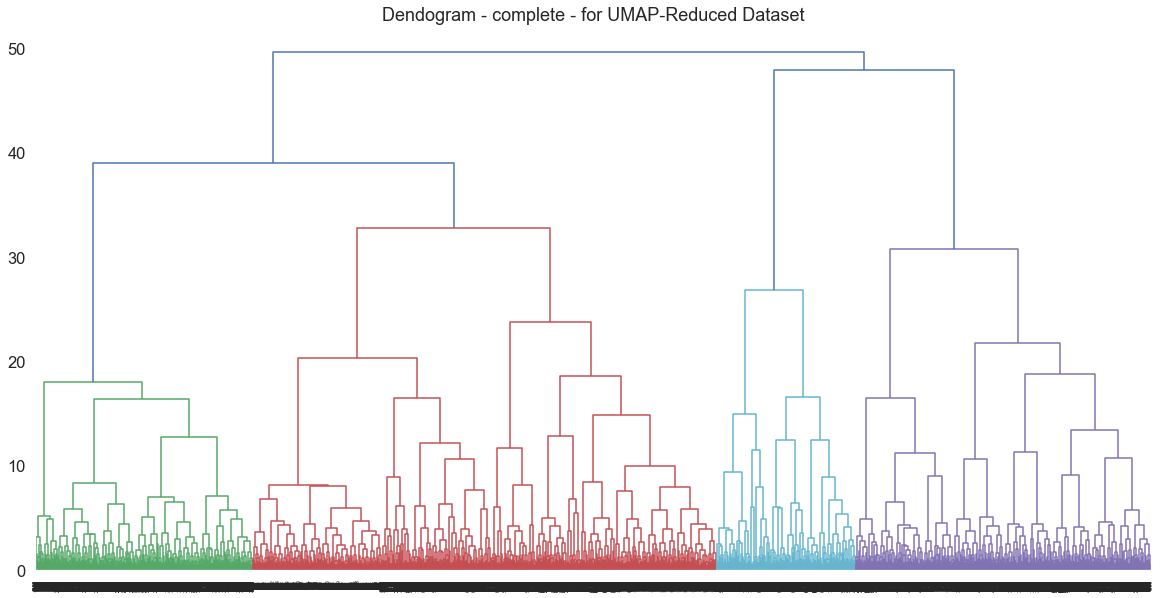

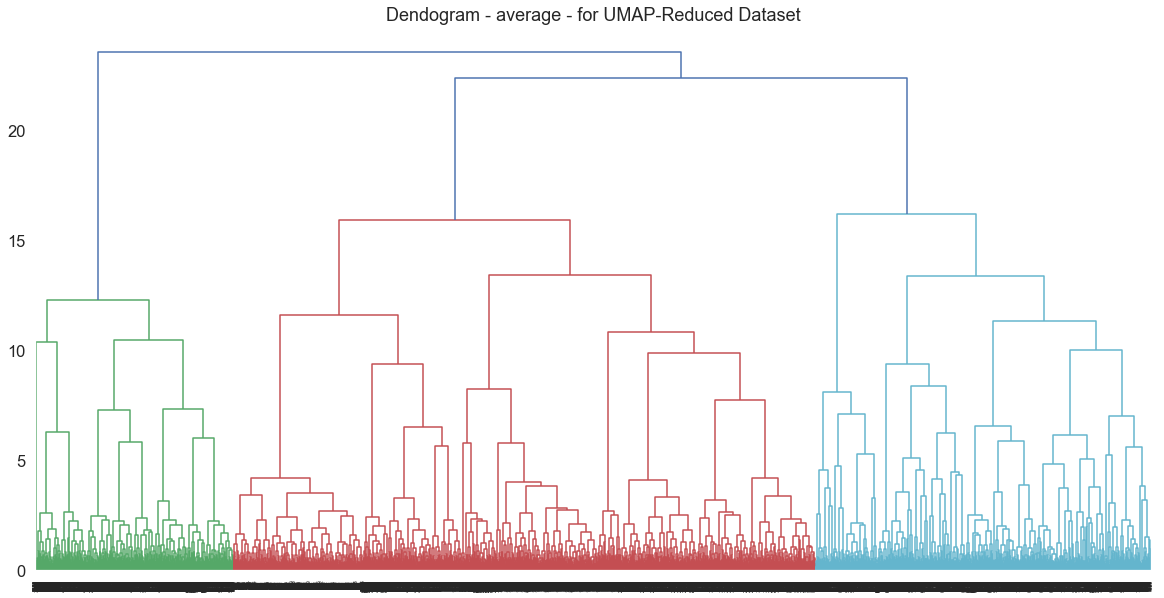

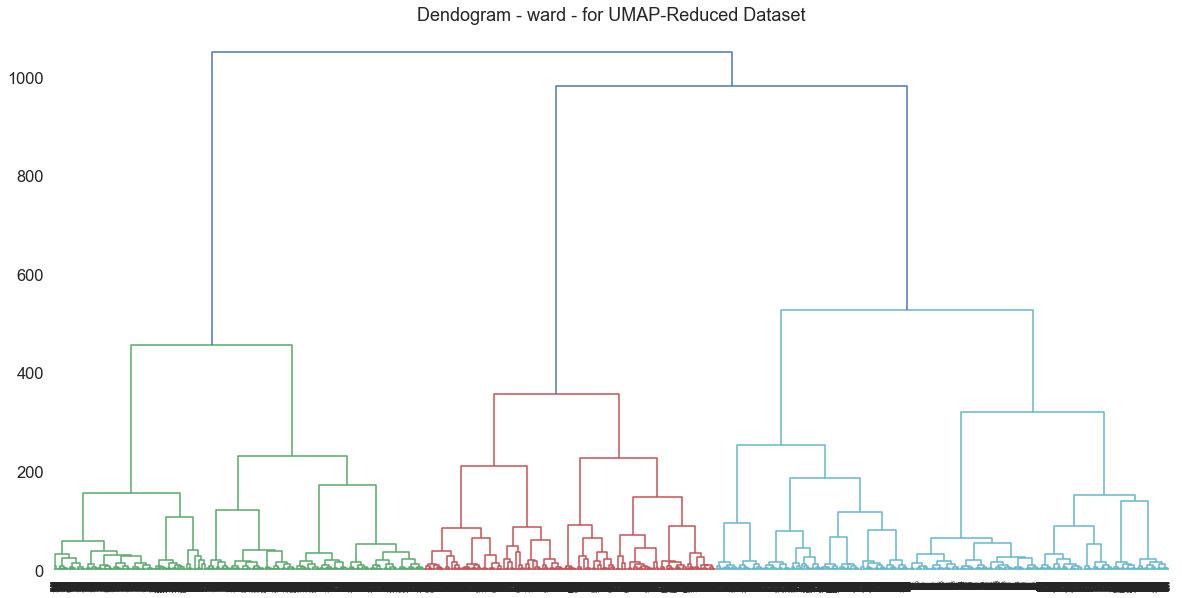

In [1238]:
dendogramPlots(X, 'UMAP')

In [1239]:
aggClustering(X, y, opt_nclust, 'UMAP')

Adjusted Rand Index of the Agglomerative Clustering solution for UMAP-Reduced Dataset, utilizing the complete method: 0.009732580534995637
Silhoutte Score of the Agglomerative Clustering solution for UMAP-Reduced Dataset, utilizing the complete method: 0.6325814127922058

-----------------------------------------------------------------------------------------

Adjusted Rand Index of the Agglomerative Clustering solution for UMAP-Reduced Dataset, utilizing the average method: 0.00936160795175887
Silhoutte Score of the Agglomerative Clustering solution for UMAP-Reduced Dataset, utilizing the average method: 0.6472892761230469

-----------------------------------------------------------------------------------------

Adjusted Rand Index of the Agglomerative Clustering solution for UMAP-Reduced Dataset, utilizing the ward method: 0.020417255423833616
Silhoutte Score of the Agglomerative Clustering solution for UMAP-Reduced Dataset, utilizing the ward method: 0.4983347952365875

----------

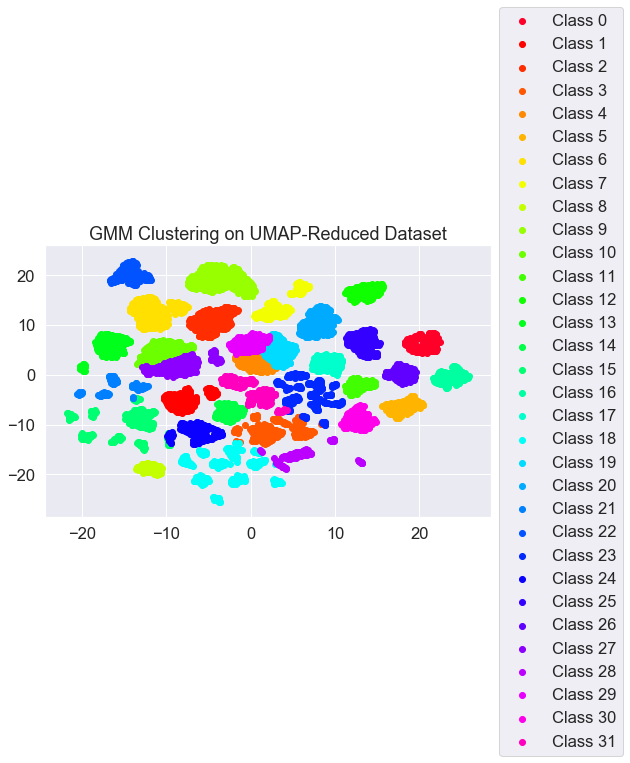

Adjusted Rand Index for GMM Clustering on UMAP-Reduced Dataset: 0.016155655512277076
Silhouette Score for GMM Clustering on UMAP-Reduced Dataset: 0.48238441348075867


In [1240]:
gmmClustering(X, umap_results, y, opt_nclust, cmp_umap, 'UMAP')

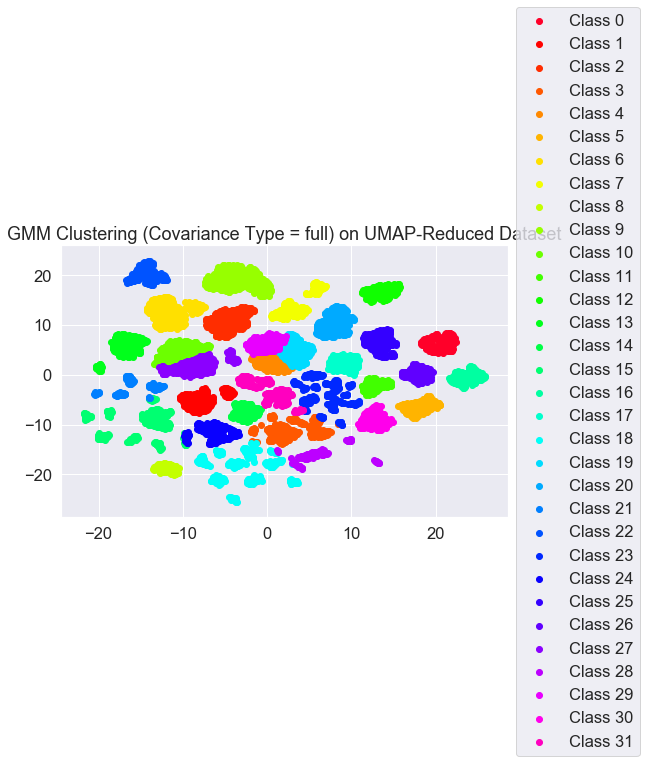

Adjusted Rand Index for GMM Clustering (Covariance Type = full) on UMAP-Reduced Dataset: 0.016155655512277076
Silhouette Score for GMM (Covariance Type = full) on UMAP-Reduced Dataset: 0.48238441348075867

-----------------------------------------------------------------------------------------



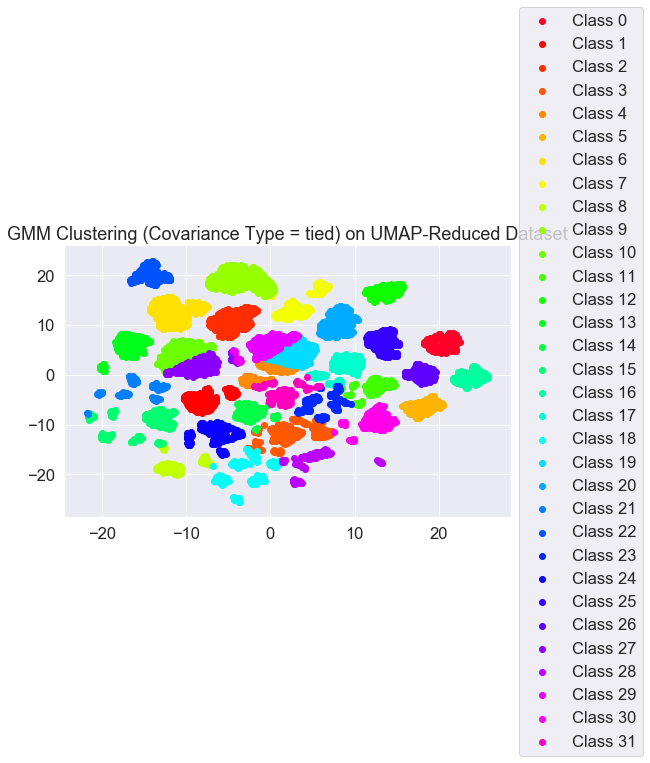

Adjusted Rand Index for GMM Clustering (Covariance Type = tied) on UMAP-Reduced Dataset: 0.015893524693696363
Silhouette Score for GMM (Covariance Type = tied) on UMAP-Reduced Dataset: 0.4882257580757141

-----------------------------------------------------------------------------------------



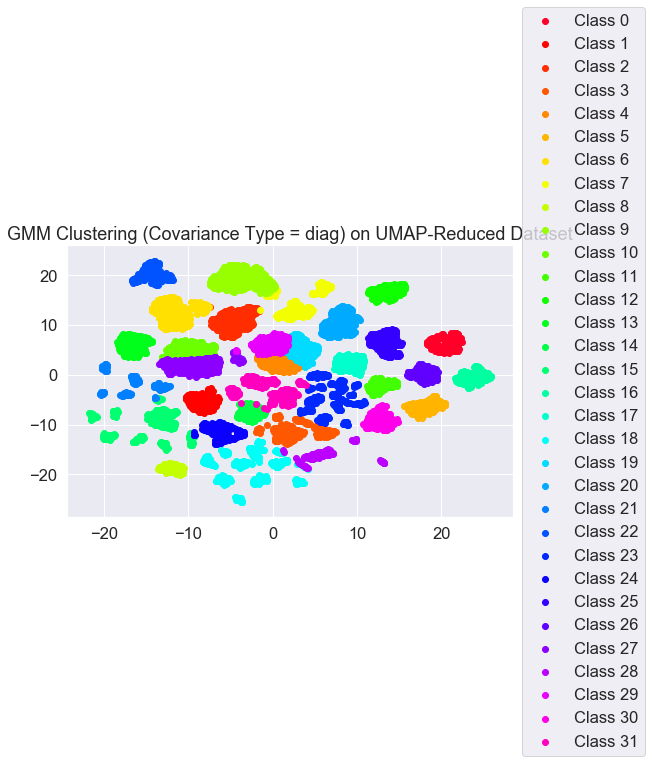

Adjusted Rand Index for GMM Clustering (Covariance Type = diag) on UMAP-Reduced Dataset: 0.014648982652005564
Silhouette Score for GMM (Covariance Type = diag) on UMAP-Reduced Dataset: 0.4739055037498474

-----------------------------------------------------------------------------------------



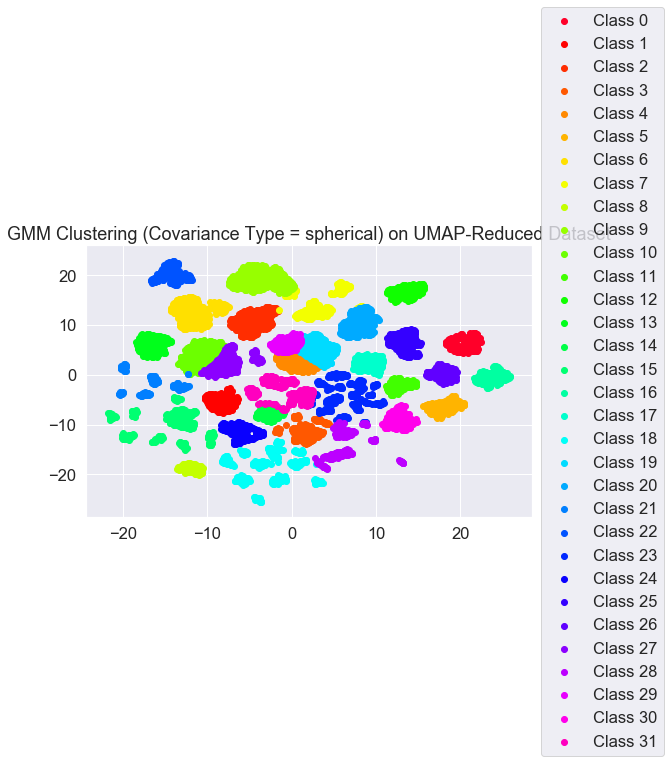

Adjusted Rand Index for GMM Clustering (Covariance Type = spherical) on UMAP-Reduced Dataset: 0.01636184317872564
Silhouette Score for GMM (Covariance Type = spherical) on UMAP-Reduced Dataset: 0.47356417775154114

-----------------------------------------------------------------------------------------



In [1241]:
gmmCovClustering(X, umap_results, y, opt_nclust, cmp_umap, 'UMAP')

### UMAP Conclusions:
As with TSNE, the best model is Agglomerative Clustering, utilizing the complete method, from which a Silhouette Score of 63% is achieved. However, we can see that all unsupervised models performed on the UMAP dataset produce lower scores than either PCA or TSNE. This is somewhat surprising to me, since visually, the UMAP groupings seem to be better-separated than TSNE, but it doesn't really matter, since PCA performed so much better than either of the others, so we know that PCA is the best dimensionality reduction choice for this dataset's unsupervised learning analysis.

## Cluster Descriptions
By analyzing the clusters created by our best-performing model (KMeans) on our dataset, we can get a decent approximation of the average feature values by which each distinct cluster can be represented. Using a heatmap, knowing that all of our values have been min-max scaled between 0 and 1, we can see that brighter colors are closer to 1 and darker colors are closer to 0.  

In [1272]:
col_list = ['cluster', 'count']
for col in list(X_std2.columns):
    col_list.append(col)
col_list.append('method')


In [1278]:
km = KMeans(n_clusters=4, random_state=42)
km.fit(X_std2)
labels = km.labels_
cluster_centers = km.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
km_clusters = pd.DataFrame(cluster_centers, columns = X_std2.columns)
km_clusters['cluster'] = ['KM{}'.format(l) for l in labels_unique]
km_clusters['method'] = 'KMeans'
km_clusters['count'] = [list(km.labels_).count(x) for x in labels_unique]
cols = col_list
clusters = km_clusters[cols]

In [1279]:
clusters

cluster  count  track_bit_rate  track_duration  audio_features_acousticness  \
0     KM0   1511        0.747118        0.471311                     0.557770   
1     KM1    890        0.710695        0.396406                     0.594958   
2     KM2   1924        0.754374        0.452343                     0.601729   
3     KM3   3366        0.811008        0.454266                     0.432354   

   audio_features_danceability  audio_features_energy  \
0                     0.368076               0.572435   
1                     0.384560               0.556656   
2                     0.462090               0.501508   
3                     0.503163               0.568375   

   audio_features_instrumentalness  audio_features_liveness  \
0                         0.565103                 0.451672   
1                         0.779063                 0.378768   
2                         0.648970                 0.434351   
3                         0.629264                 0.398992   

   audio_features_speechiness  ...  date_11_2012  date_11_2013  date_11_2014  \
0                    0.255333  ...  3.309067e-03  2.647253e-03  3.903128e-17   
1                    0.361349  ...  1.734723e-17 -1.517883e-18 -9.627715e-17   
2                    0.371018  ... -6.895526e-17  3.057450e-17  4.336809e-18   
3                    0.355149  ...  3.267974e-03  1.485443e-03  1.039810e-02   

   date_12_2008  date_12_2010  date_12_2011  date_12_2012  date_12_2013  \
0  4.387823e-01  1.853077e-02  1.720715e-02  5.294507e-03  6.618134e-04   
1 -1.013079e-15 -2.532696e-16  1.387779e-17  1.734723e-17  8.673617e-18   
2 -1.623701e-15  8.812395e-16  1.517883e-17 -6.895526e-17 -3.447763e-17   
3  1.498801e-15  4.842543e-02  8.912656e-04  2.376708e-03  2.079620e-03   

   date_12_2014  method  
0  6.618134e-04  KMeans  
1  5.767956e-17  KMeans  
2 -1.049508e-16  KMeans  
3  7.724302e-03  KMeans  

[4 rows x 121 columns]

As we can see from the track counts within each KMeans cluster, there may be some class imbalance issues with our analysis, in that the four clusters have significantly different numbers of component tracks.

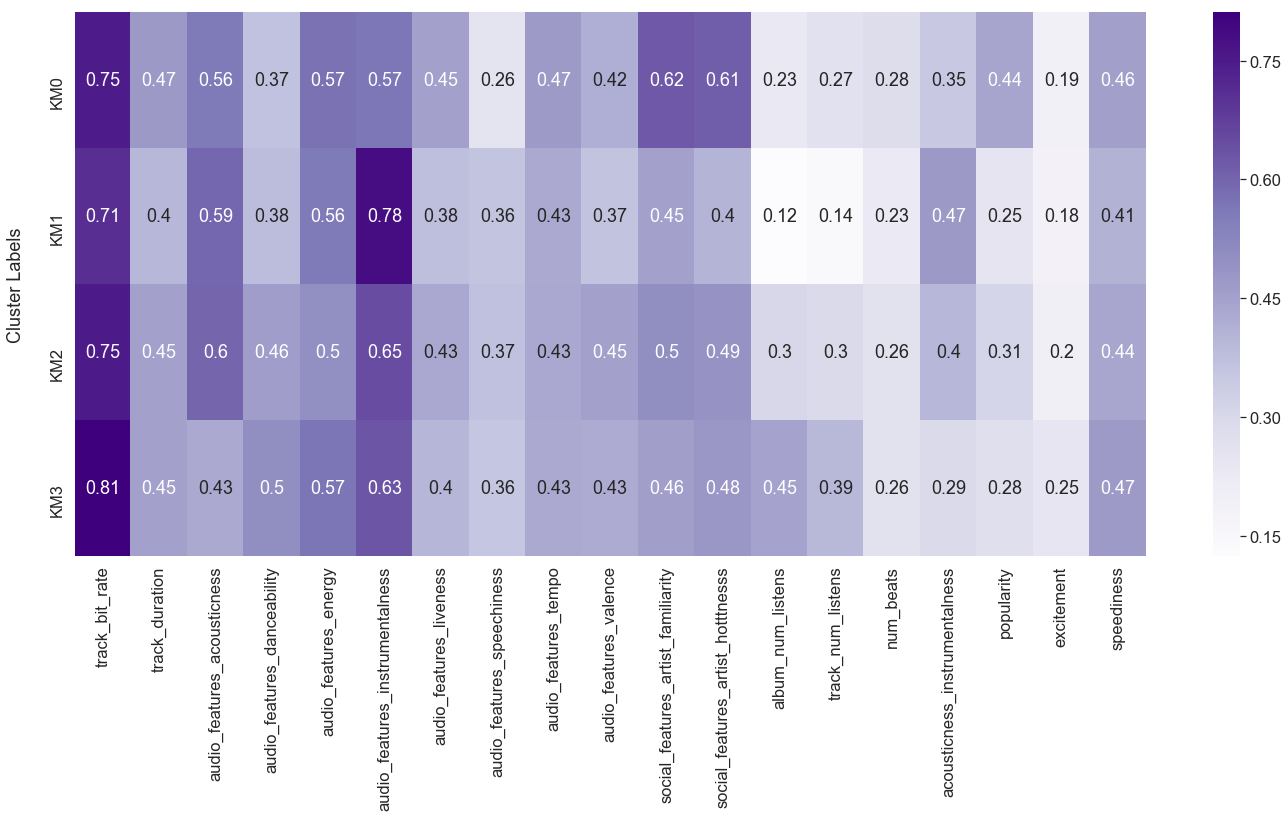

In [1029]:
#Analyze the clusters with respect to continuous variables
plt.figure(figsize=(24,10))
sns.set(font_scale=1.5)
sns.heatmap(
    data = clusters[cont_cols2],
    cmap = 'Purples',
    yticklabels = clusters['cluster'],
    annot = True
)
plt.ylabel("Cluster Labels\n")
plt.show()

With respect to the continuous features of the dataset, we can conclude that the most significant differentiators between the clusters can be described as:
 - Cluster #1: (KM0) Lowest speechiness, Lowest danceability, Longest/ highest duration, Lowest instrumentalness, Low album and track listens, Highest overall artist popularity (and familiarity/ hotttnesss), Highest tempo
 - Cluster #2: (KM1) Slowest/ lowest tempo, Fewest album and track listens, Low overall artist popularity (and familiarity/hotttnesss), Shortest/ lowest duration, Lowest bitrate, Highest instrumentalness, High acousticness, Lowest liveness, Low danceability
 - Cluster #3: (KM2) Middle-of-the-road for most features, Highest acousticness 
 - Cluster #3: (KM3) Highest bitrate, Lowest acousticness, High energy, Low tempo, Highest album and track listens, Highest speediness, Highest excitement, Low popularity

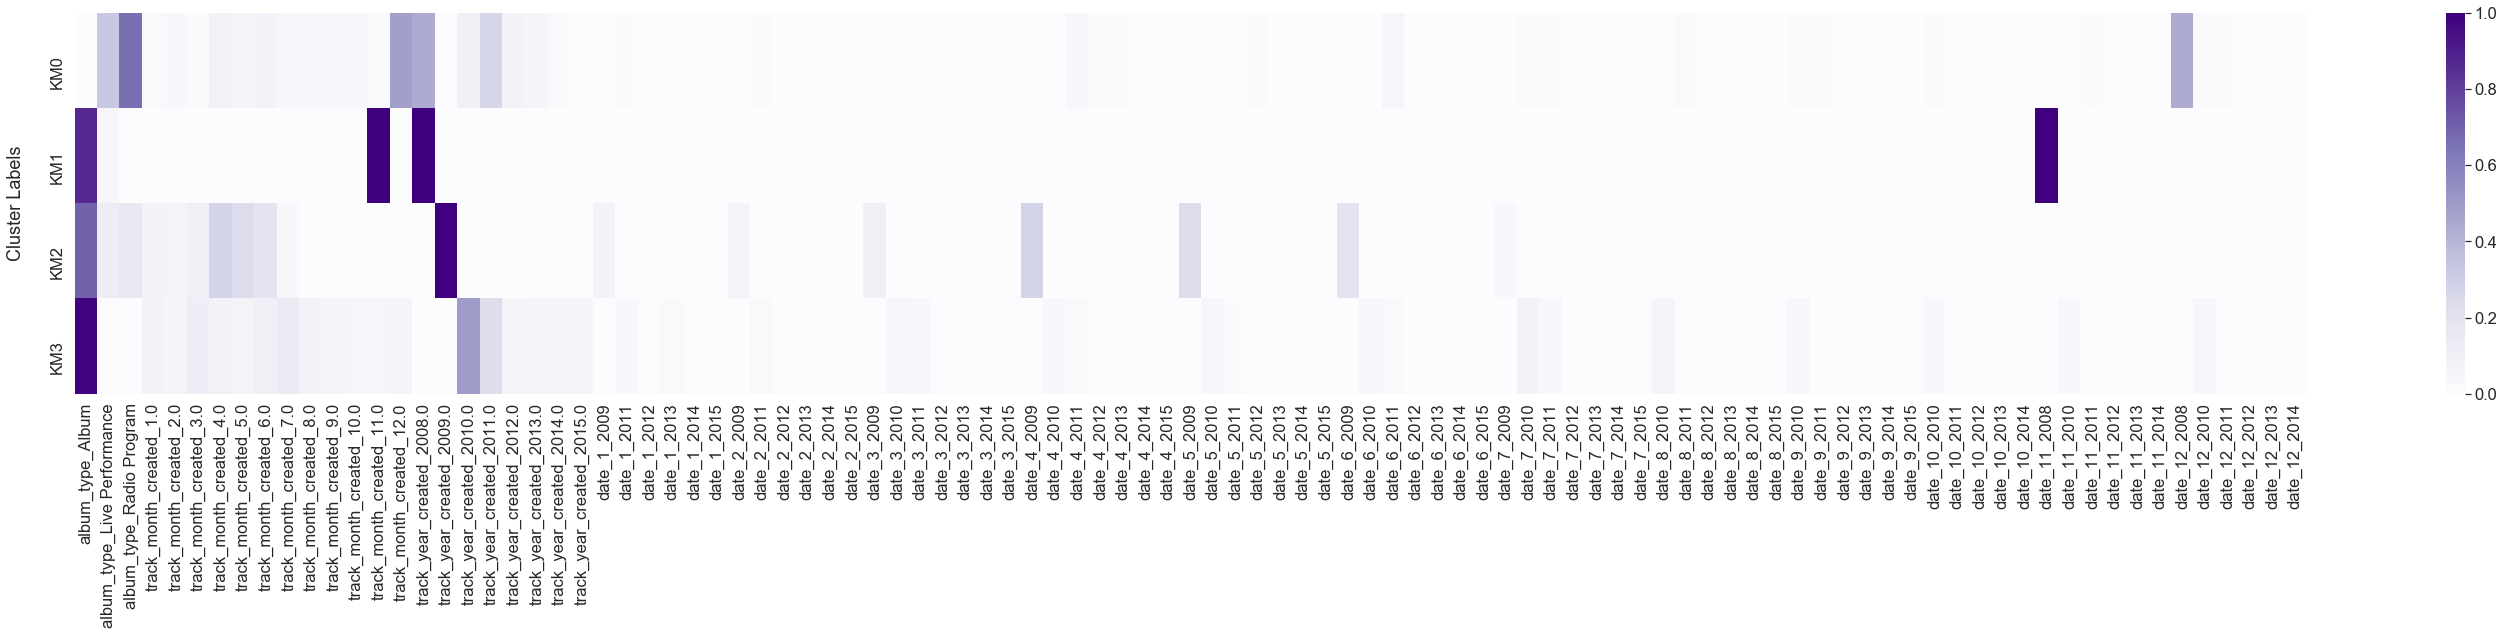

In [1030]:
#Analyze the clusters with respect to categorical variables
plt.figure(figsize=(50,7))
sns.set(font_scale=1.5)
sns.heatmap(
    data = clusters[bin_cat_cols2],
    cmap='Purples',
    yticklabels = clusters['cluster'],
    annot=False
)
plt.ylabel("Cluster Labels\n")
plt.show()

With respect to the categorical features of the dataset, we can conclude that the most significant differentiators between the clusters can be described as:
 - Cluster #1: (KM0) 
     - Album Type: Mostly Radio Program, but some Live Performance. None or very few Album
     - Track Date: Mostly December 2008
 - Cluster #2: (KM1) 
     - Album Type: Majority Album, a few Live Performance
     - Track Date: All November 2008
 - Cluster #3: (KM2) 
     - Album Type: Even split between album types (Album likely has darkest bar because of class imbalance)
     - Track Date: All 2009
 - Cluster #3: (KM3) 
     - Album Type: All Album
     - Track Date: Mostly 2010, some tracks in other years. Even distribution among all months.

## Final Conclusions:

Overall, I found that the Unsupervised Machine Learning model with the highest clustering success was KMean clustering on the PCA-Reduced dataset. Not only did it provide a plot of four very distinct groups, it also had a Silhouette Score of approximately 90%. It's important to note that none of the dimnesionality-reduction and clustering combinations matched with the original clusters/ genre labels provided with the dataset. While I would have liked to find a method by which my clusters matched somewhat to the provided genre labels, it isn't that necessary. By the methods that I used in this project, I instead was able to create four groups, by which a company might be able to suggest other songs in the cluster to someone who liked one (or more) of the songs in that same cluster.  

In future experiments and modeling, I would like to find a way to create a larger number of more specific, more distinct clusters/labels. I would have liked to come up with 16 clusters, to match the original 16 genre labels, but to do so would have led to unnecessary over-clustering of the plotted dataset. Perhaps, with a more detailed set of features, or with a larger set of tracks, I may be able to accomplish that goal in the future. 